In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV # k folds validation using all data as validation set
from sklearn.cross_validation import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns # data visualization library 

%matplotlib inline

In [18]:
def batchencoder(dftrain,dftest,col,method,targ = 'Target',usetext = False): 
    '''
       dftrain: X_train with target
       dftest:X_test with target but should not use its target to encode
       method: {'onehot','woe','target','none','label'}
       col:{'ZIPCODE','MONTH','CUIZ_TYPE'}
       targ: 'Target'
       return: encoded X_train and X_Test with target
       recommend: woe or target to encode zipcode and cuisine
       
       '''
    #y = dftrain[targ]
    #x = dftrain.drop(targ,axis = 1,inplace = True)
    if not usetext:
        dftrain.drop('Reviews',axis = 1,inplace = True)
        dftest.drop('Reviews',axis = 1,inplace = True)
        
    for i in range(len(col)):
            
        if method[i] == 'target':
            group_target_mean = dftrain.groupby([col[i]])[targ].mean()
            dftest[col[i]] = dftest[col[i]].map(group_target_mean)
            dftrain[col[i]] = dftrain[col[i]].map(group_target_mean)
            
        elif method[i] == 'onehot':
            
            dftrain['unique'] = pd.Series(np.arange(0,len(dftrain)))
            dftest['unique'] = pd.Series(np.arange(len(dftrain),len(dftrain)+len(dftest)))
            x = pd.concat([dftrain,dftest],axis = 0,ignore_index = True)
            df_le = LabelEncoder()
            df_labels = df_le.fit_transform(x[col[i]])
            x[col[i]+'_LABEL'] = df_labels
            df_ohe = OneHotEncoder()
            df_feature_arr = df_ohe.fit_transform(x[[col[i]+'_LABEL']]).toarray()
            df_feature_labels = list(df_le.classes_)
            df_features = pd.DataFrame(df_feature_arr,columns = df_feature_labels)
            x = pd.concat([x, df_features], axis=1)
            x.drop([col[i]+'_LABEL',col[i]],axis = 1,inplace = True)
            dftrain = x[x.unique.isin(dftrain.unique.values)]
            dftest = x[x.unique.isin(dftest.unique.values)]
            
            dftrain.drop('unique',axis = 1,inplace = True)
            dftest.drop('unique',axis = 1,inplace = True)
            
        elif method[i] == 'label':
            dftrain['unique'] = pd.Series(np.arange(0,len(dftrain)))
            dftest['unique'] = pd.Series(np.arange(len(dftrain),len(dftrain)+len(dftest)))
            x = pd.concat([dftrain,dftest],axis = 0,ignore_index = True)
            x[col[i]+'_LABEL'] = LabelEncoder().fit_transform(x[col[i]])
            dftrain = x[x.unique.isin(dftrain.unique.values)]
            dftest = x[x.unique.isin(dftest.unique.values)]
            #dftrain.drop(['unique',col[i]],axis = 1,inplace = True)
            #dftest.drop(['unique',col[i]],axis = 1,inplace = True)           
            
    return dftrain, dftest

In [82]:
def getfeaturesets(trainx,trainy,method,weights = None, perc = None):
    
#generate feature sets
    if method == 'rfecv':
        clf_rf_4 = RandomForestClassifier() 
        rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='roc_auc')   #5-fold cross-validation
        rfecv = rfecv.fit(trainx, trainy)
        feat = trainx.columns[rfecv.support_].values

# print('Optimal number of features :', rfecv.n_features_)
# print('Best features :', X_train.columns[rfecv.support_])
    elif method == 'lr':
        embeded_lr_selector = SelectFromModel(LogisticRegression(C = 0.1,penalty="l1"))
        embeded_lr_selector.fit(trainx, trainy)
        embeded_lr_support = embeded_lr_selector.get_support()
        feat = trainx.loc[:,embeded_lr_support].columns.values
# print(str(len(embeded_lr_feature)), 'selected features')
# print(embeded_lr_feature)
    elif method == 'rf':
        embeded_rf_selector = SelectFromModel(RandomForestClassifier(criterion='entropy',oob_score=True))
        embeded_rf_selector.fit(trainx, trainy)
        embeded_rf_support = embeded_rf_selector.get_support()
        feat = trainx.loc[:,embeded_rf_support].columns.values
#     print(str(len(embeded_rf_feature)), 'selected features')
#     print(embeded_rf_feature)

    elif (method == 'fi_rf' or method == 'fi_lgm'):
        
        
        weights = dict(weights)
        val = list(weights.values())
        l = len(np.where(np.cumsum(val) < perc)[0])
        feat = list(weights.keys())[:l]

    return feat

def getfeatureimportance(X,trained,model,ret = False,pl = False):
    #rf:
    if model == 'rf':
        weights = list(zip( X.columns,trained.feature_importances_ ))
        weights.sort(reverse = True,key=lambda x: x[1])
        
        weights_df = pd.DataFrame(weights[:60],columns = ['feature','weight'])
        if pl:
            
            sns.set_context('talk')
            c = sns.barplot(x='weight',y='feature',data = weights_df,palette='Set3')
            plt.title("Restaurant Failures Feature Importance"+'_'+model)
            plt.rcParams["axes.labelsize"] = 10
            plt.xticks(rotation = 90)
            plt.xlabel("Normalized_Feature_importance")
            plt.ylabel("Feature")
            plt.show()
        
    elif model == 'lgm':
        val = trained.feature_importance()
        weights = list(zip(X.columns,val/np.sum(val)))
        weights.sort(reverse = True,key=lambda x: x[1])
        
        weights_df = pd.DataFrame(weights[:60],columns = ['feature','weight'])
        if pl:
            
            sns.set_context('talk')
            c = sns.barplot(x='weight',y='feature',data = weights_df,palette='Set3')
            plt.title("Flight Delay Prediction Feature Importance"+'_'+model)
            plt.xticks(rotation = 90)
            plt.xlabel("Normalized_Feature_importance")
            plt.ylabel("Feature")
            plt.show()
     
    if ret:
        return weights
 

In [4]:
Test = pd.read_csv('testset4.csv')
Train = pd.read_csv('trainset4.csv')

In [10]:
Train.shape

(10490, 59)

In [74]:
#Encoding
(Train,Test) = batchencoder(Train,Test,col = ['Zipcode','Month','FoodType','LastAction','LastGrade','LastInspProgram','LastInspCat','SubBoro'],method = ['onehot','onehot','onehot','onehot','onehot','onehot','onehot','onehot'],targ = 'Target')


/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [271]:
#Generate 
X_Train = Train.drop('Target',1,inplace = False)
Y_Train = Train['Target']
X_Test = Test.drop('Target',1,inplace = False)
Y_Test = Test['Target']

In [76]:
#Train.columns.values #should we drop zipcode

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.6146
[2]	training's binary_logloss: 0.613594
[3]	training's binary_logloss: 0.612605
[4]	training's binary_logloss: 0.6116
[5]	training's binary_logloss: 0.610584
[6]	training's binary_logloss: 0.609662
[7]	training's binary_logloss: 0.608731
[8]	training's binary_logloss: 0.607839
[9]	training's binary_logloss: 0.60703
[10]	training's binary_logloss: 0.606206
[11]	training's binary_logloss: 0.605341
[12]	training's binary_logloss: 0.604594
[13]	training's binary_logloss: 0.603921
[14]	training's binary_logloss: 0.603205
[15]	training's binary_logloss: 0.60247
[16]	training's binary_logloss: 0.601768
[17]	training's binary_logloss: 0.601096
[18]	training's binary_logloss: 0.600437
[19]	training's binary_logloss: 0.599804
[20]	training's binary_logloss: 0.5992
[21]	training's binary_logloss: 0.59865
[22]	training's binary_logloss: 0.598121
[23]	training's binary_logloss: 0.597543
[24]	training's binary_logloss: 0.597013
[25]	training's binary_logloss: 0.

[226]	training's binary_logloss: 0.586463
[227]	training's binary_logloss: 0.58643
[228]	training's binary_logloss: 0.586405
[229]	training's binary_logloss: 0.586377
[230]	training's binary_logloss: 0.586343
[231]	training's binary_logloss: 0.58635
[232]	training's binary_logloss: 0.586351
[233]	training's binary_logloss: 0.58635
[234]	training's binary_logloss: 0.586352
[235]	training's binary_logloss: 0.586357
[236]	training's binary_logloss: 0.58632
[237]	training's binary_logloss: 0.586293
[238]	training's binary_logloss: 0.586265
[239]	training's binary_logloss: 0.586218
[240]	training's binary_logloss: 0.586191
[241]	training's binary_logloss: 0.586186
[242]	training's binary_logloss: 0.586157
[243]	training's binary_logloss: 0.586139
[244]	training's binary_logloss: 0.586129
[245]	training's binary_logloss: 0.586102
[246]	training's binary_logloss: 0.586029
[247]	training's binary_logloss: 0.585967
[248]	training's binary_logloss: 0.585891
[249]	training's binary_logloss: 0.585

[470]	training's binary_logloss: 0.573114
[471]	training's binary_logloss: 0.573025
[472]	training's binary_logloss: 0.572935
[473]	training's binary_logloss: 0.572856
[474]	training's binary_logloss: 0.572765
[475]	training's binary_logloss: 0.572682
[476]	training's binary_logloss: 0.572621
[477]	training's binary_logloss: 0.572543
[478]	training's binary_logloss: 0.572492
[479]	training's binary_logloss: 0.57245
[480]	training's binary_logloss: 0.572378
[481]	training's binary_logloss: 0.572331
[482]	training's binary_logloss: 0.572288
[483]	training's binary_logloss: 0.572248
[484]	training's binary_logloss: 0.572197
[485]	training's binary_logloss: 0.572152
[486]	training's binary_logloss: 0.572059
[487]	training's binary_logloss: 0.571971
[488]	training's binary_logloss: 0.57188
[489]	training's binary_logloss: 0.571784
[490]	training's binary_logloss: 0.571695
[491]	training's binary_logloss: 0.571582
[492]	training's binary_logloss: 0.571479
[493]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


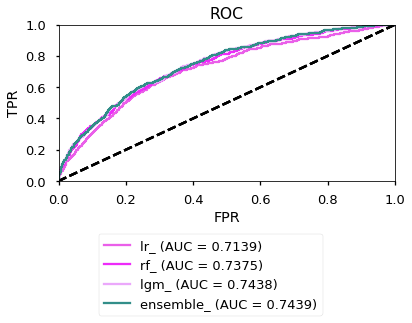

In [379]:
#Demonstrate on test set
from imblearn.over_sampling import SMOTE

#smote = SMOTE(ratio='minority')
#X_Train, Y_Train = smote.fit_sample(X_Train, Y_Train)

ens = [0.1,0.2,0.7]
predall_noselect = []
trainedall_noselect = []
for model in ['lr','rf','lgm']:
    (pred,tra) = getprediction(model,X_Train,Y_Train,X_Test)
    predall_noselect.append(pred)
    trainedall_noselect.append(tra)
    plotAUC(Y_Test,pred,model)
plotAUC(Y_Test,ens[0]*predall_noselect[0]+ens[1]*predall_noselect[1]+ens[2]*predall_noselect[2],'ensemble')


In [309]:
def plotAUC(truth, pred, lab,other = ''):
    fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
    roc_auc = metrics.roc_auc_score(truth, pred)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= other+lab+'_'+' (AUC = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc='center left', bbox_to_anchor=(0.1,-0.6)) 
    #plt.legend(loc='center left', bbox_to_anchor=(1.2,0.5),ncol=2)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


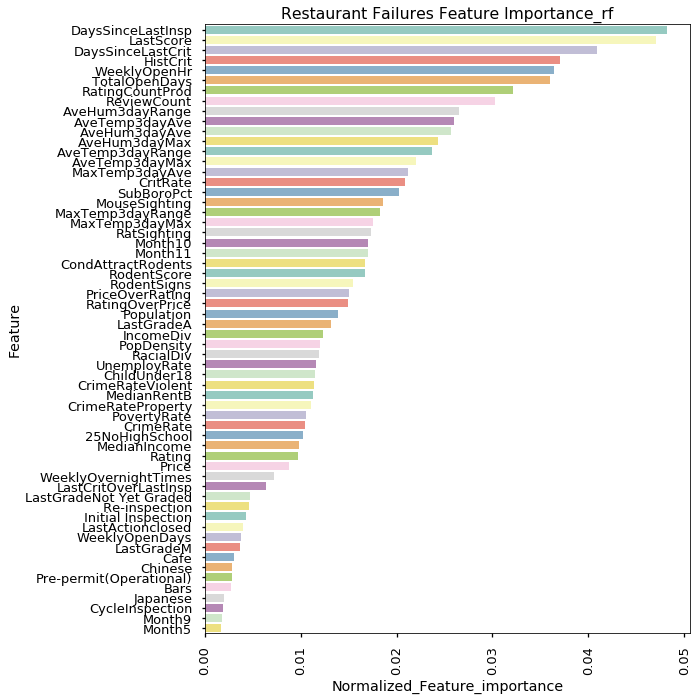

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


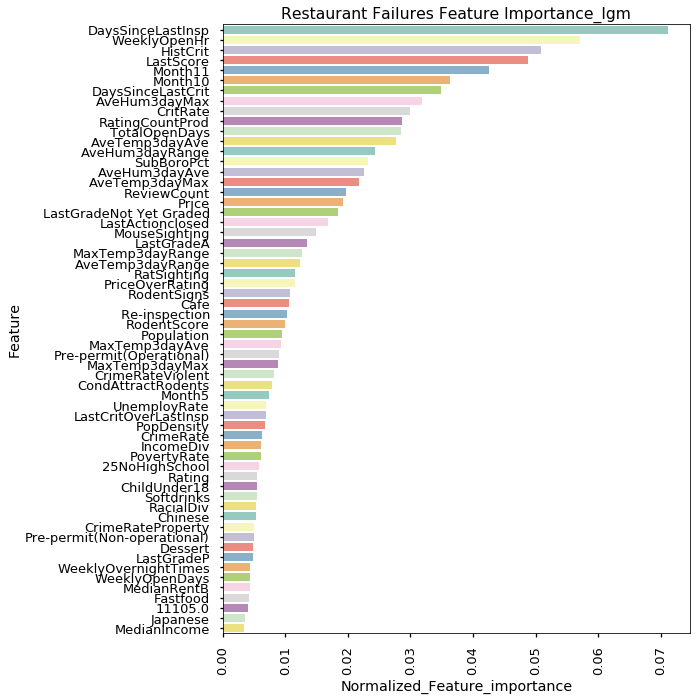

In [274]:


plt.figure(figsize=(10,10))
plt.rcParams.update({'figure.autolayout':True})
getfeatureimportance(X_Train,trainedall_noselect[1],model = 'rf',pl = True)
plt.figure(figsize=(10,10))
getfeatureimportance(X_Train,trainedall_noselect[2],model = 'lgm',pl=True)

# Feature Selection

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614604
[2]	training's binary_logloss: 0.613465
[3]	training's binary_logloss: 0.612375
[4]	training's binary_logloss: 0.611369
[5]	training's binary_logloss: 0.610328
[6]	training's binary_logloss: 0.609358
[7]	training's binary_logloss: 0.608369
[8]	training's binary_logloss: 0.60742
[9]	training's binary_logloss: 0.606624
[10]	training's binary_logloss: 0.605892
[11]	training's binary_logloss: 0.605062
[12]	training's binary_logloss: 0.60429
[13]	training's binary_logloss: 0.603511
[14]	training's binary_logloss: 0.602763
[15]	training's binary_logloss: 0.602157
[16]	training's binary_logloss: 0.601593
[17]	training's binary_logloss: 0.600931
[18]	training's binary_logloss: 0.600385
[19]	training's binary_logloss: 0.599818
[20]	training's binary_logloss: 0.599204
[21]	training's binary_logloss: 0.598661
[22]	training's binary_logloss: 0.598143
[23]	training's binary_logloss: 0.597643
[24]	training's binary_logloss: 0.597148
[25]	training's binary_logl

[218]	training's binary_logloss: 0.586606
[219]	training's binary_logloss: 0.586564
[220]	training's binary_logloss: 0.586541
[221]	training's binary_logloss: 0.586504
[222]	training's binary_logloss: 0.586471
[223]	training's binary_logloss: 0.586438
[224]	training's binary_logloss: 0.586402
[225]	training's binary_logloss: 0.586389
[226]	training's binary_logloss: 0.586375
[227]	training's binary_logloss: 0.586352
[228]	training's binary_logloss: 0.58631
[229]	training's binary_logloss: 0.586289
[230]	training's binary_logloss: 0.586267
[231]	training's binary_logloss: 0.586266
[232]	training's binary_logloss: 0.586242
[233]	training's binary_logloss: 0.586241
[234]	training's binary_logloss: 0.586242
[235]	training's binary_logloss: 0.586241
[236]	training's binary_logloss: 0.586204
[237]	training's binary_logloss: 0.586163
[238]	training's binary_logloss: 0.586133
[239]	training's binary_logloss: 0.586114
[240]	training's binary_logloss: 0.586085
[241]	training's binary_logloss: 0.

[466]	training's binary_logloss: 0.573299
[467]	training's binary_logloss: 0.573226
[468]	training's binary_logloss: 0.573158
[469]	training's binary_logloss: 0.573096
[470]	training's binary_logloss: 0.573026
[471]	training's binary_logloss: 0.572927
[472]	training's binary_logloss: 0.57283
[473]	training's binary_logloss: 0.572731
[474]	training's binary_logloss: 0.572645
[475]	training's binary_logloss: 0.572551
[476]	training's binary_logloss: 0.572472
[477]	training's binary_logloss: 0.572412
[478]	training's binary_logloss: 0.572335
[479]	training's binary_logloss: 0.572279
[480]	training's binary_logloss: 0.57222
[481]	training's binary_logloss: 0.572173
[482]	training's binary_logloss: 0.572122
[483]	training's binary_logloss: 0.572077
[484]	training's binary_logloss: 0.572037
[485]	training's binary_logloss: 0.572002
[486]	training's binary_logloss: 0.571893
[487]	training's binary_logloss: 0.571801
[488]	training's binary_logloss: 0.57171
[489]	training's binary_logloss: 0.57

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614676
[2]	training's binary_logloss: 0.61358
[3]	training's binary_logloss: 0.612584
[4]	training's binary_logloss: 0.611584
[5]	training's binary_logloss: 0.610567
[6]	training's binary_logloss: 0.609578
[7]	training's binary_logloss: 0.608663
[8]	training's binary_logloss: 0.607848
[9]	training's binary_logloss: 0.607022
[10]	training's binary_logloss: 0.606174
[11]	training's binary_logloss: 0.6054
[12]	training's binary_logloss: 0.604613
[13]	training's binary_logloss: 0.603966
[14]	training's binary_logloss: 0.603329
[15]	training's binary_logloss: 0.60271
[16]	training's binary_logloss: 0.602007
[17]	training's binary_logloss: 0.601332
[18]	training's binary_logloss: 0.600687
[19]	training's binary_logloss: 0.600068
[20]	training's binary_logloss: 0.599476
[21]	training's binary_logloss: 0.598959
[22]	training's binary_logloss: 0.598456
[23]	training's binary_logloss: 0.597979
[24]	training's binary_logloss: 0.597498
[25]	training's binary_loglos

[256]	training's binary_logloss: 0.586509
[257]	training's binary_logloss: 0.586484
[258]	training's binary_logloss: 0.586462
[259]	training's binary_logloss: 0.58644
[260]	training's binary_logloss: 0.58642
[261]	training's binary_logloss: 0.586401
[262]	training's binary_logloss: 0.586412
[263]	training's binary_logloss: 0.586399
[264]	training's binary_logloss: 0.586407
[265]	training's binary_logloss: 0.586356
[266]	training's binary_logloss: 0.586345
[267]	training's binary_logloss: 0.586336
[268]	training's binary_logloss: 0.586326
[269]	training's binary_logloss: 0.586324
[270]	training's binary_logloss: 0.586316
[271]	training's binary_logloss: 0.586278
[272]	training's binary_logloss: 0.586231
[273]	training's binary_logloss: 0.586196
[274]	training's binary_logloss: 0.586152
[275]	training's binary_logloss: 0.586105
[276]	training's binary_logloss: 0.586056
[277]	training's binary_logloss: 0.586015
[278]	training's binary_logloss: 0.585968
[279]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614677
[2]	training's binary_logloss: 0.613685
[3]	training's binary_logloss: 0.612641
[4]	training's binary_logloss: 0.611655
[5]	training's binary_logloss: 0.610787
[6]	training's binary_logloss: 0.609765
[7]	training's binary_logloss: 0.608873
[8]	training's binary_logloss: 0.608039
[9]	training's binary_logloss: 0.607193
[10]	training's binary_logloss: 0.606427
[11]	training's binary_logloss: 0.605647
[12]	training's binary_logloss: 0.60492
[13]	training's binary_logloss: 0.604191
[14]	training's binary_logloss: 0.603528
[15]	training's binary_logloss: 0.602869
[16]	training's binary_logloss: 0.60233
[17]	training's binary_logloss: 0.601689
[18]	training's binary_logloss: 0.601017
[19]	training's binary_logloss: 0.60043
[20]	training's binary_logloss: 0.599811
[21]	training's binary_logloss: 0.599282
[22]	training's binary_logloss: 0.598772
[23]	training's binary_logloss: 0.598284
[24]	training's binary_logloss: 0.597808
[25]	training's binary_loglo

[234]	training's binary_logloss: 0.587338
[235]	training's binary_logloss: 0.587346
[236]	training's binary_logloss: 0.587323
[237]	training's binary_logloss: 0.587284
[238]	training's binary_logloss: 0.587264
[239]	training's binary_logloss: 0.58723
[240]	training's binary_logloss: 0.587196
[241]	training's binary_logloss: 0.587169
[242]	training's binary_logloss: 0.58714
[243]	training's binary_logloss: 0.587122
[244]	training's binary_logloss: 0.587104
[245]	training's binary_logloss: 0.587078
[246]	training's binary_logloss: 0.587028
[247]	training's binary_logloss: 0.586954
[248]	training's binary_logloss: 0.586886
[249]	training's binary_logloss: 0.586816
[250]	training's binary_logloss: 0.586754
[251]	training's binary_logloss: 0.586674
[252]	training's binary_logloss: 0.586612
[253]	training's binary_logloss: 0.586565
[254]	training's binary_logloss: 0.586501
[255]	training's binary_logloss: 0.586427
[256]	training's binary_logloss: 0.586415
[257]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614604
[2]	training's binary_logloss: 0.613462
[3]	training's binary_logloss: 0.612402
[4]	training's binary_logloss: 0.611395
[5]	training's binary_logloss: 0.610357
[6]	training's binary_logloss: 0.609406
[7]	training's binary_logloss: 0.608501
[8]	training's binary_logloss: 0.607645
[9]	training's binary_logloss: 0.606771
[10]	training's binary_logloss: 0.605991
[11]	training's binary_logloss: 0.605246
[12]	training's binary_logloss: 0.604435
[13]	training's binary_logloss: 0.603656
[14]	training's binary_logloss: 0.602907
[15]	training's binary_logloss: 0.6022
[16]	training's binary_logloss: 0.601523
[17]	training's binary_logloss: 0.600879
[18]	training's binary_logloss: 0.600226
[19]	training's binary_logloss: 0.599602
[20]	training's binary_logloss: 0.599016
[21]	training's binary_logloss: 0.598496
[22]	training's binary_logloss: 0.597952
[23]	training's binary_logloss: 0.597448
[24]	training's binary_logloss: 0.596971
[25]	training's binary_logl

[264]	training's binary_logloss: 0.585225
[265]	training's binary_logloss: 0.585195
[266]	training's binary_logloss: 0.585195
[267]	training's binary_logloss: 0.585198
[268]	training's binary_logloss: 0.585203
[269]	training's binary_logloss: 0.585197
[270]	training's binary_logloss: 0.585175
[271]	training's binary_logloss: 0.585115
[272]	training's binary_logloss: 0.585088
[273]	training's binary_logloss: 0.585063
[274]	training's binary_logloss: 0.585051
[275]	training's binary_logloss: 0.585022
[276]	training's binary_logloss: 0.584976
[277]	training's binary_logloss: 0.584927
[278]	training's binary_logloss: 0.584881
[279]	training's binary_logloss: 0.584835
[280]	training's binary_logloss: 0.58479
[281]	training's binary_logloss: 0.584762
[282]	training's binary_logloss: 0.58475
[283]	training's binary_logloss: 0.584745
[284]	training's binary_logloss: 0.584723
[285]	training's binary_logloss: 0.584709
[286]	training's binary_logloss: 0.584659
[287]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614721
[2]	training's binary_logloss: 0.613575
[3]	training's binary_logloss: 0.612596
[4]	training's binary_logloss: 0.611666
[5]	training's binary_logloss: 0.610606
[6]	training's binary_logloss: 0.609718
[7]	training's binary_logloss: 0.608737
[8]	training's binary_logloss: 0.607816
[9]	training's binary_logloss: 0.606951
[10]	training's binary_logloss: 0.606099
[11]	training's binary_logloss: 0.605331
[12]	training's binary_logloss: 0.604524
[13]	training's binary_logloss: 0.603858
[14]	training's binary_logloss: 0.603123
[15]	training's binary_logloss: 0.602471
[16]	training's binary_logloss: 0.601759
[17]	training's binary_logloss: 0.601075
[18]	training's binary_logloss: 0.600424
[19]	training's binary_logloss: 0.599796
[20]	training's binary_logloss: 0.599283
[21]	training's binary_logloss: 0.598739
[22]	training's binary_logloss: 0.598261
[23]	training's binary_logloss: 0.597754
[24]	training's binary_logloss: 0.597257
[25]	training's binary_lo

[210]	training's binary_logloss: 0.586586
[211]	training's binary_logloss: 0.586615
[212]	training's binary_logloss: 0.586621
[213]	training's binary_logloss: 0.58664
[214]	training's binary_logloss: 0.586647
[215]	training's binary_logloss: 0.586677
[216]	training's binary_logloss: 0.586656
[217]	training's binary_logloss: 0.586628
[218]	training's binary_logloss: 0.586611
[219]	training's binary_logloss: 0.586594
[220]	training's binary_logloss: 0.586572
[221]	training's binary_logloss: 0.586533
[222]	training's binary_logloss: 0.586493
[223]	training's binary_logloss: 0.586458
[224]	training's binary_logloss: 0.586439
[225]	training's binary_logloss: 0.58641
[226]	training's binary_logloss: 0.586403
[227]	training's binary_logloss: 0.586377
[228]	training's binary_logloss: 0.586348
[229]	training's binary_logloss: 0.586322
[230]	training's binary_logloss: 0.586298
[231]	training's binary_logloss: 0.586299
[232]	training's binary_logloss: 0.586298
[233]	training's binary_logloss: 0.5

[429]	training's binary_logloss: 0.576142
[430]	training's binary_logloss: 0.576081
[431]	training's binary_logloss: 0.576009
[432]	training's binary_logloss: 0.575933
[433]	training's binary_logloss: 0.575867
[434]	training's binary_logloss: 0.575796
[435]	training's binary_logloss: 0.575721
[436]	training's binary_logloss: 0.575659
[437]	training's binary_logloss: 0.575598
[438]	training's binary_logloss: 0.575547
[439]	training's binary_logloss: 0.575481
[440]	training's binary_logloss: 0.575417
[441]	training's binary_logloss: 0.575344
[442]	training's binary_logloss: 0.575269
[443]	training's binary_logloss: 0.575196
[444]	training's binary_logloss: 0.575133
[445]	training's binary_logloss: 0.575066
[446]	training's binary_logloss: 0.574975
[447]	training's binary_logloss: 0.574885
[448]	training's binary_logloss: 0.574779
[449]	training's binary_logloss: 0.574679
[450]	training's binary_logloss: 0.574589
[451]	training's binary_logloss: 0.57451
[452]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


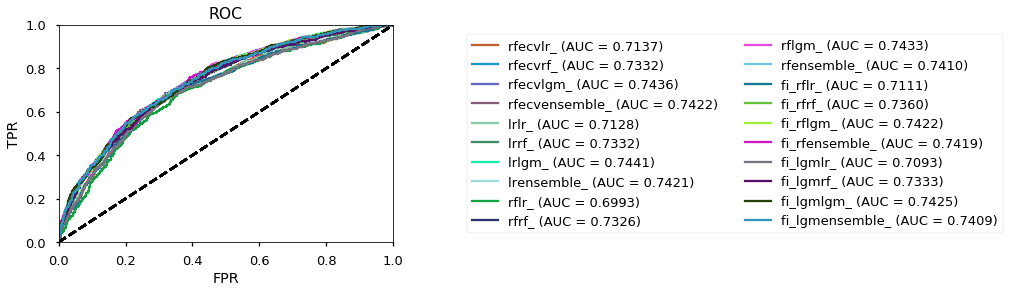

In [111]:
percent = 0.95
ens = [0.2,0.3,0.5]
for met in ['rfecv','lr','rf','fi_rf','fi_lgm']:
    if met in ['rfecv','lr','rf']:
        feat = getfeaturesets(X_Train,Y_Train,method  = met)
    elif met == 'fi_rf':
        feat = getfeaturesets(X_Train,Y_Train,method  = 'fi_rf',
                              weights = getfeatureimportance(X_Train,trainedall_noselect[1],'rf',ret = True),perc = percent)
    elif met == 'fi_lgm':
        feat = getfeaturesets(X_Train,Y_Train,method  = 'fi_rf',
                              weights = getfeatureimportance(X_Train,trainedall_noselect[2],'lgm',ret = True),perc = percent)
    
    X_featTrain = X_Train[feat]
    X_featTest = X_Test[feat]
    predall_select = []
    trainedall_select = []
    for model in ['lr','rf','lgm']:
        (pred,tra) = getprediction(model,X_featTrain,Y_Train,X_featTest)
        predall_select.append(pred)
        trainedall_select.append(tra)
        plotAUC(Y_Test,pred,model,other = met)
    plotAUC(Y_Test,ens[0]*predall_select[0]+ens[1]*predall_select[1]+ens[2]*predall_select[2],'ensemble',other = met)



# Cross Validation to find best parameters


#lightgbm
#num_of_leave
#min_data_in_leave 20

#rf
#n_estimators=1200, max_features='sqrt'

#testRF(X_Train,Y_Train,X_Test,Y_Test, nestimator, maxfeat)


In [ ]:
max_features_values = [0.2,'sqrt']
n_estimators_values = [600,750,900,1050,1200,1350,1500,1650]

res = dict()
for s in max_features_values:
    res[s] = list()

#Now train and get results for each option
for s in max_features_values:
    for l in n_estimators_values:
        res[s].append(testRF(X_Train,Y_Train,X_Test,Y_Test, l, s))  
        


In [218]:
leavenumber_values = [10,20,30,40]
min_data_in_leave_values = [10,20,30,40]

res2 = dict()
for s2 in min_data_in_leave_values:
    res2[s2] = list()

#Now train and get results for each option
for s2 in min_data_in_leave_values:
    for l2 in leavenumber_values:
        res2[s2].append(testLGM(X_Train,Y_Train,X_Test,Y_Test, l2, s2))

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614787
[2]	training's binary_logloss: 0.613724
[3]	training's binary_logloss: 0.612709
[4]	training's binary_logloss: 0.611737
[5]	training's binary_logloss: 0.610853
[6]	training's binary_logloss: 0.609993
[7]	training's binary_logloss: 0.609191
[8]	training's binary_logloss: 0.608402
[9]	training's binary_logloss: 0.607647
[10]	training's binary_logloss: 0.606854
[11]	training's binary_logloss: 0.606073
[12]	training's binary_logloss: 0.605323
[13]	training's binary_logloss: 0.604662
[14]	training's binary_logloss: 0.603961
[15]	training's binary_logloss: 0.603282
[16]	training's binary_logloss: 0.602686
[17]	training's binary_logloss: 0.602075
[18]	training's binary_logloss: 0.60146
[19]	training's binary_logloss: 0.600892
[20]	training's binary_logloss: 0.600326
[21]	training's binary_logloss: 0.5998
[22]	training's binary_logloss: 0.599349
[23]	training's binary_logloss: 0.598867
[24]	training's binary_logloss: 0.5984
[25]	training's binary_logloss

[236]	training's binary_logloss: 0.591538
[237]	training's binary_logloss: 0.591518
[238]	training's binary_logloss: 0.591496
[239]	training's binary_logloss: 0.591474
[240]	training's binary_logloss: 0.591444
[241]	training's binary_logloss: 0.591423
[242]	training's binary_logloss: 0.591424
[243]	training's binary_logloss: 0.591425
[244]	training's binary_logloss: 0.591433
[245]	training's binary_logloss: 0.591441
[246]	training's binary_logloss: 0.591397
[247]	training's binary_logloss: 0.591335
[248]	training's binary_logloss: 0.591275
[249]	training's binary_logloss: 0.591222
[250]	training's binary_logloss: 0.591163
[251]	training's binary_logloss: 0.591117
[252]	training's binary_logloss: 0.591093
[253]	training's binary_logloss: 0.591037
[254]	training's binary_logloss: 0.590996
[255]	training's binary_logloss: 0.590949
[256]	training's binary_logloss: 0.590946
[257]	training's binary_logloss: 0.590946
[258]	training's binary_logloss: 0.590937
[259]	training's binary_logloss: 0

[435]	training's binary_logloss: 0.583272
[436]	training's binary_logloss: 0.583223
[437]	training's binary_logloss: 0.583164
[438]	training's binary_logloss: 0.583123
[439]	training's binary_logloss: 0.583079
[440]	training's binary_logloss: 0.583036
[441]	training's binary_logloss: 0.582986
[442]	training's binary_logloss: 0.582926
[443]	training's binary_logloss: 0.582871
[444]	training's binary_logloss: 0.582818
[445]	training's binary_logloss: 0.582771
[446]	training's binary_logloss: 0.582678
[447]	training's binary_logloss: 0.582588
[448]	training's binary_logloss: 0.582502
[449]	training's binary_logloss: 0.582414
[450]	training's binary_logloss: 0.582338
[451]	training's binary_logloss: 0.58227
[452]	training's binary_logloss: 0.5822
[453]	training's binary_logloss: 0.582138
[454]	training's binary_logloss: 0.582083
[455]	training's binary_logloss: 0.582023
[456]	training's binary_logloss: 0.581958
[457]	training's binary_logloss: 0.581902
[458]	training's binary_logloss: 0.58

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614441
[2]	training's binary_logloss: 0.61311
[3]	training's binary_logloss: 0.611812
[4]	training's binary_logloss: 0.610567
[5]	training's binary_logloss: 0.609378
[6]	training's binary_logloss: 0.608204
[7]	training's binary_logloss: 0.607092
[8]	training's binary_logloss: 0.606031
[9]	training's binary_logloss: 0.604997
[10]	training's binary_logloss: 0.604
[11]	training's binary_logloss: 0.60306
[12]	training's binary_logloss: 0.602115
[13]	training's binary_logloss: 0.601214
[14]	training's binary_logloss: 0.600346
[15]	training's binary_logloss: 0.599514
[16]	training's binary_logloss: 0.598748
[17]	training's binary_logloss: 0.597942
[18]	training's binary_logloss: 0.597168
[19]	training's binary_logloss: 0.596424
[20]	training's binary_logloss: 0.595668
[21]	training's binary_logloss: 0.595003
[22]	training's binary_logloss: 0.594404
[23]	training's binary_logloss: 0.593773
[24]	training's binary_logloss: 0.59319
[25]	training's binary_logloss:

[222]	training's binary_logloss: 0.568264
[223]	training's binary_logloss: 0.568183
[224]	training's binary_logloss: 0.568094
[225]	training's binary_logloss: 0.568017
[226]	training's binary_logloss: 0.567924
[227]	training's binary_logloss: 0.567833
[228]	training's binary_logloss: 0.567731
[229]	training's binary_logloss: 0.567632
[230]	training's binary_logloss: 0.567544
[231]	training's binary_logloss: 0.567465
[232]	training's binary_logloss: 0.567401
[233]	training's binary_logloss: 0.567339
[234]	training's binary_logloss: 0.56726
[235]	training's binary_logloss: 0.567186
[236]	training's binary_logloss: 0.567084
[237]	training's binary_logloss: 0.566991
[238]	training's binary_logloss: 0.5669
[239]	training's binary_logloss: 0.566802
[240]	training's binary_logloss: 0.566703
[241]	training's binary_logloss: 0.566631
[242]	training's binary_logloss: 0.566545
[243]	training's binary_logloss: 0.566468
[244]	training's binary_logloss: 0.566427
[245]	training's binary_logloss: 0.56

[433]	training's binary_logloss: 0.547129
[434]	training's binary_logloss: 0.547018
[435]	training's binary_logloss: 0.546909
[436]	training's binary_logloss: 0.546808
[437]	training's binary_logloss: 0.546703
[438]	training's binary_logloss: 0.546605
[439]	training's binary_logloss: 0.546483
[440]	training's binary_logloss: 0.546407
[441]	training's binary_logloss: 0.546294
[442]	training's binary_logloss: 0.546169
[443]	training's binary_logloss: 0.54603
[444]	training's binary_logloss: 0.545922
[445]	training's binary_logloss: 0.545793
[446]	training's binary_logloss: 0.545641
[447]	training's binary_logloss: 0.54549
[448]	training's binary_logloss: 0.54534
[449]	training's binary_logloss: 0.545188
[450]	training's binary_logloss: 0.545043
[451]	training's binary_logloss: 0.544893
[452]	training's binary_logloss: 0.544743
[453]	training's binary_logloss: 0.544611
[454]	training's binary_logloss: 0.544494
[455]	training's binary_logloss: 0.544348
[456]	training's binary_logloss: 0.54

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614302
[2]	training's binary_logloss: 0.612831
[3]	training's binary_logloss: 0.611385
[4]	training's binary_logloss: 0.60998
[5]	training's binary_logloss: 0.608641
[6]	training's binary_logloss: 0.60731
[7]	training's binary_logloss: 0.606048
[8]	training's binary_logloss: 0.604823
[9]	training's binary_logloss: 0.603623
[10]	training's binary_logloss: 0.602499
[11]	training's binary_logloss: 0.601412
[12]	training's binary_logloss: 0.600319
[13]	training's binary_logloss: 0.599297
[14]	training's binary_logloss: 0.59831
[15]	training's binary_logloss: 0.597315
[16]	training's binary_logloss: 0.596384
[17]	training's binary_logloss: 0.595465
[18]	training's binary_logloss: 0.594581
[19]	training's binary_logloss: 0.593718
[20]	training's binary_logloss: 0.592841
[21]	training's binary_logloss: 0.592074
[22]	training's binary_logloss: 0.591367
[23]	training's binary_logloss: 0.590619
[24]	training's binary_logloss: 0.589927
[25]	training's binary_loglo

[227]	training's binary_logloss: 0.547557
[228]	training's binary_logloss: 0.547387
[229]	training's binary_logloss: 0.547215
[230]	training's binary_logloss: 0.547044
[231]	training's binary_logloss: 0.546913
[232]	training's binary_logloss: 0.546781
[233]	training's binary_logloss: 0.546653
[234]	training's binary_logloss: 0.546482
[235]	training's binary_logloss: 0.546366
[236]	training's binary_logloss: 0.546187
[237]	training's binary_logloss: 0.546019
[238]	training's binary_logloss: 0.545879
[239]	training's binary_logloss: 0.545725
[240]	training's binary_logloss: 0.545566
[241]	training's binary_logloss: 0.54543
[242]	training's binary_logloss: 0.545296
[243]	training's binary_logloss: 0.545171
[244]	training's binary_logloss: 0.545074
[245]	training's binary_logloss: 0.54495
[246]	training's binary_logloss: 0.544745
[247]	training's binary_logloss: 0.544575
[248]	training's binary_logloss: 0.544379
[249]	training's binary_logloss: 0.544183
[250]	training's binary_logloss: 0.5

[455]	training's binary_logloss: 0.512507
[456]	training's binary_logloss: 0.512368
[457]	training's binary_logloss: 0.512227
[458]	training's binary_logloss: 0.512089
[459]	training's binary_logloss: 0.511946
[460]	training's binary_logloss: 0.511813
[461]	training's binary_logloss: 0.511661
[462]	training's binary_logloss: 0.511496
[463]	training's binary_logloss: 0.511355
[464]	training's binary_logloss: 0.511197
[465]	training's binary_logloss: 0.511033
[466]	training's binary_logloss: 0.510852
[467]	training's binary_logloss: 0.510691
[468]	training's binary_logloss: 0.510536
[469]	training's binary_logloss: 0.510364
[470]	training's binary_logloss: 0.510199
[471]	training's binary_logloss: 0.510027
[472]	training's binary_logloss: 0.50986
[473]	training's binary_logloss: 0.509678
[474]	training's binary_logloss: 0.509512
[475]	training's binary_logloss: 0.509339
[476]	training's binary_logloss: 0.509205
[477]	training's binary_logloss: 0.509059
[478]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614173
[2]	training's binary_logloss: 0.612578
[3]	training's binary_logloss: 0.611014
[4]	training's binary_logloss: 0.60949
[5]	training's binary_logloss: 0.608035
[6]	training's binary_logloss: 0.606571
[7]	training's binary_logloss: 0.605185
[8]	training's binary_logloss: 0.603844
[9]	training's binary_logloss: 0.602511
[10]	training's binary_logloss: 0.601275
[11]	training's binary_logloss: 0.600055
[12]	training's binary_logloss: 0.598843
[13]	training's binary_logloss: 0.597707
[14]	training's binary_logloss: 0.596591
[15]	training's binary_logloss: 0.595475
[16]	training's binary_logloss: 0.594419
[17]	training's binary_logloss: 0.593396
[18]	training's binary_logloss: 0.592403
[19]	training's binary_logloss: 0.591434
[20]	training's binary_logloss: 0.590459
[21]	training's binary_logloss: 0.589579
[22]	training's binary_logloss: 0.588746
[23]	training's binary_logloss: 0.587907
[24]	training's binary_logloss: 0.587122
[25]	training's binary_log

[210]	training's binary_logloss: 0.532783
[211]	training's binary_logloss: 0.532599
[212]	training's binary_logloss: 0.532404
[213]	training's binary_logloss: 0.532222
[214]	training's binary_logloss: 0.532046
[215]	training's binary_logloss: 0.531883
[216]	training's binary_logloss: 0.53168
[217]	training's binary_logloss: 0.531456
[218]	training's binary_logloss: 0.531225
[219]	training's binary_logloss: 0.531
[220]	training's binary_logloss: 0.530775
[221]	training's binary_logloss: 0.530534
[222]	training's binary_logloss: 0.530363
[223]	training's binary_logloss: 0.53016
[224]	training's binary_logloss: 0.529923
[225]	training's binary_logloss: 0.529737
[226]	training's binary_logloss: 0.529495
[227]	training's binary_logloss: 0.529252
[228]	training's binary_logloss: 0.529014
[229]	training's binary_logloss: 0.528789
[230]	training's binary_logloss: 0.528561
[231]	training's binary_logloss: 0.528354
[232]	training's binary_logloss: 0.52814
[233]	training's binary_logloss: 0.52792

[415]	training's binary_logloss: 0.491612
[416]	training's binary_logloss: 0.491406
[417]	training's binary_logloss: 0.491198
[418]	training's binary_logloss: 0.490999
[419]	training's binary_logloss: 0.490814
[420]	training's binary_logloss: 0.490632
[421]	training's binary_logloss: 0.49044
[422]	training's binary_logloss: 0.490261
[423]	training's binary_logloss: 0.490043
[424]	training's binary_logloss: 0.489868
[425]	training's binary_logloss: 0.489678
[426]	training's binary_logloss: 0.489512
[427]	training's binary_logloss: 0.489283
[428]	training's binary_logloss: 0.489126
[429]	training's binary_logloss: 0.488956
[430]	training's binary_logloss: 0.488753
[431]	training's binary_logloss: 0.488522
[432]	training's binary_logloss: 0.488321
[433]	training's binary_logloss: 0.488127
[434]	training's binary_logloss: 0.487935
[435]	training's binary_logloss: 0.487736
[436]	training's binary_logloss: 0.487561
[437]	training's binary_logloss: 0.487362
[438]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614697
[2]	training's binary_logloss: 0.613765
[3]	training's binary_logloss: 0.612858
[4]	training's binary_logloss: 0.611944
[5]	training's binary_logloss: 0.611012
[6]	training's binary_logloss: 0.610177
[7]	training's binary_logloss: 0.609357
[8]	training's binary_logloss: 0.608572
[9]	training's binary_logloss: 0.607822
[10]	training's binary_logloss: 0.607103
[11]	training's binary_logloss: 0.606306
[12]	training's binary_logloss: 0.605594
[13]	training's binary_logloss: 0.604975
[14]	training's binary_logloss: 0.604325
[15]	training's binary_logloss: 0.603641
[16]	training's binary_logloss: 0.602985
[17]	training's binary_logloss: 0.602353
[18]	training's binary_logloss: 0.601745
[19]	training's binary_logloss: 0.601166
[20]	training's binary_logloss: 0.600614
[21]	training's binary_logloss: 0.60008
[22]	training's binary_logloss: 0.599575
[23]	training's binary_logloss: 0.599065
[24]	training's binary_logloss: 0.598542
[25]	training's binary_log

[249]	training's binary_logloss: 0.591346
[250]	training's binary_logloss: 0.591294
[251]	training's binary_logloss: 0.591234
[252]	training's binary_logloss: 0.591188
[253]	training's binary_logloss: 0.591136
[254]	training's binary_logloss: 0.59108
[255]	training's binary_logloss: 0.591039
[256]	training's binary_logloss: 0.591025
[257]	training's binary_logloss: 0.591013
[258]	training's binary_logloss: 0.591006
[259]	training's binary_logloss: 0.591007
[260]	training's binary_logloss: 0.591003
[261]	training's binary_logloss: 0.591026
[262]	training's binary_logloss: 0.591043
[263]	training's binary_logloss: 0.591023
[264]	training's binary_logloss: 0.591044
[265]	training's binary_logloss: 0.591062
[266]	training's binary_logloss: 0.591072
[267]	training's binary_logloss: 0.591078
[268]	training's binary_logloss: 0.591089
[269]	training's binary_logloss: 0.591097
[270]	training's binary_logloss: 0.591108
[271]	training's binary_logloss: 0.591086
[272]	training's binary_logloss: 0.

[488]	training's binary_logloss: 0.580336
[489]	training's binary_logloss: 0.580254
[490]	training's binary_logloss: 0.580174
[491]	training's binary_logloss: 0.58007
[492]	training's binary_logloss: 0.579986
[493]	training's binary_logloss: 0.579901
[494]	training's binary_logloss: 0.579803
[495]	training's binary_logloss: 0.579721
[496]	training's binary_logloss: 0.579657
[497]	training's binary_logloss: 0.579601
[498]	training's binary_logloss: 0.579528
[499]	training's binary_logloss: 0.579455
[500]	training's binary_logloss: 0.579384


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614399
[2]	training's binary_logloss: 0.613184
[3]	training's binary_logloss: 0.611976
[4]	training's binary_logloss: 0.61075
[5]	training's binary_logloss: 0.609543
[6]	training's binary_logloss: 0.608394
[7]	training's binary_logloss: 0.607259
[8]	training's binary_logloss: 0.60618
[9]	training's binary_logloss: 0.605143
[10]	training's binary_logloss: 0.604154
[11]	training's binary_logloss: 0.603194
[12]	training's binary_logloss: 0.602335
[13]	training's binary_logloss: 0.601475
[14]	training's binary_logloss: 0.600682
[15]	training's binary_logloss: 0.599855
[16]	training's binary_logloss: 0.59903
[17]	training's binary_logloss: 0.598234
[18]	training's binary_logloss: 0.597455
[19]	training's binary_logloss: 0.596694
[20]	training's binary_logloss: 0.595965
[21]	training's binary_logloss: 0.595294
[22]	training's binary_logloss: 0.594649
[23]	training's binary_logloss: 0.593992
[24]	training's binary_logloss: 0.593347
[25]	training's binary_loglo

[205]	training's binary_logloss: 0.569989
[206]	training's binary_logloss: 0.569881
[207]	training's binary_logloss: 0.569789
[208]	training's binary_logloss: 0.569694
[209]	training's binary_logloss: 0.5696
[210]	training's binary_logloss: 0.569515
[211]	training's binary_logloss: 0.569485
[212]	training's binary_logloss: 0.569444
[213]	training's binary_logloss: 0.569415
[214]	training's binary_logloss: 0.569376
[215]	training's binary_logloss: 0.569355
[216]	training's binary_logloss: 0.569274
[217]	training's binary_logloss: 0.569197
[218]	training's binary_logloss: 0.569127
[219]	training's binary_logloss: 0.569051
[220]	training's binary_logloss: 0.568979
[221]	training's binary_logloss: 0.568905
[222]	training's binary_logloss: 0.568837
[223]	training's binary_logloss: 0.568763
[224]	training's binary_logloss: 0.568697
[225]	training's binary_logloss: 0.568635
[226]	training's binary_logloss: 0.568566
[227]	training's binary_logloss: 0.568462
[228]	training's binary_logloss: 0.5

[427]	training's binary_logloss: 0.548888
[428]	training's binary_logloss: 0.548789
[429]	training's binary_logloss: 0.548684
[430]	training's binary_logloss: 0.54861
[431]	training's binary_logloss: 0.548496
[432]	training's binary_logloss: 0.548397
[433]	training's binary_logloss: 0.54829
[434]	training's binary_logloss: 0.548185
[435]	training's binary_logloss: 0.548082
[436]	training's binary_logloss: 0.547959
[437]	training's binary_logloss: 0.547846
[438]	training's binary_logloss: 0.547727
[439]	training's binary_logloss: 0.54762
[440]	training's binary_logloss: 0.547503
[441]	training's binary_logloss: 0.547393
[442]	training's binary_logloss: 0.547283
[443]	training's binary_logloss: 0.547162
[444]	training's binary_logloss: 0.547048
[445]	training's binary_logloss: 0.546936
[446]	training's binary_logloss: 0.546776
[447]	training's binary_logloss: 0.546637
[448]	training's binary_logloss: 0.546484
[449]	training's binary_logloss: 0.546335
[450]	training's binary_logloss: 0.54

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614248
[2]	training's binary_logloss: 0.612857
[3]	training's binary_logloss: 0.611508
[4]	training's binary_logloss: 0.61015
[5]	training's binary_logloss: 0.608807
[6]	training's binary_logloss: 0.607496
[7]	training's binary_logloss: 0.606207
[8]	training's binary_logloss: 0.60498
[9]	training's binary_logloss: 0.603786
[10]	training's binary_logloss: 0.602645
[11]	training's binary_logloss: 0.60151
[12]	training's binary_logloss: 0.600467
[13]	training's binary_logloss: 0.599447
[14]	training's binary_logloss: 0.598472
[15]	training's binary_logloss: 0.597495
[16]	training's binary_logloss: 0.596542
[17]	training's binary_logloss: 0.595618
[18]	training's binary_logloss: 0.594708
[19]	training's binary_logloss: 0.593835
[20]	training's binary_logloss: 0.592993
[21]	training's binary_logloss: 0.592218
[22]	training's binary_logloss: 0.591466
[23]	training's binary_logloss: 0.590664
[24]	training's binary_logloss: 0.58991
[25]	training's binary_loglos

[200]	training's binary_logloss: 0.552129
[201]	training's binary_logloss: 0.55205
[202]	training's binary_logloss: 0.551933
[203]	training's binary_logloss: 0.551822
[204]	training's binary_logloss: 0.551735
[205]	training's binary_logloss: 0.55163
[206]	training's binary_logloss: 0.551465
[207]	training's binary_logloss: 0.551316
[208]	training's binary_logloss: 0.551179
[209]	training's binary_logloss: 0.551036
[210]	training's binary_logloss: 0.550895
[211]	training's binary_logloss: 0.55079
[212]	training's binary_logloss: 0.550687
[213]	training's binary_logloss: 0.550573
[214]	training's binary_logloss: 0.550482
[215]	training's binary_logloss: 0.550397
[216]	training's binary_logloss: 0.550253
[217]	training's binary_logloss: 0.550103
[218]	training's binary_logloss: 0.549965
[219]	training's binary_logloss: 0.549822
[220]	training's binary_logloss: 0.549693
[221]	training's binary_logloss: 0.549535
[222]	training's binary_logloss: 0.549395
[223]	training's binary_logloss: 0.54

[404]	training's binary_logloss: 0.522148
[405]	training's binary_logloss: 0.521996
[406]	training's binary_logloss: 0.521864
[407]	training's binary_logloss: 0.521735
[408]	training's binary_logloss: 0.521609
[409]	training's binary_logloss: 0.521472
[410]	training's binary_logloss: 0.521348
[411]	training's binary_logloss: 0.521214
[412]	training's binary_logloss: 0.521084
[413]	training's binary_logloss: 0.520942
[414]	training's binary_logloss: 0.520797
[415]	training's binary_logloss: 0.520659
[416]	training's binary_logloss: 0.520504
[417]	training's binary_logloss: 0.520336
[418]	training's binary_logloss: 0.520159
[419]	training's binary_logloss: 0.520003
[420]	training's binary_logloss: 0.519839
[421]	training's binary_logloss: 0.519697
[422]	training's binary_logloss: 0.519554
[423]	training's binary_logloss: 0.519387
[424]	training's binary_logloss: 0.51924
[425]	training's binary_logloss: 0.51909
[426]	training's binary_logloss: 0.51893
[427]	training's binary_logloss: 0.51

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614122
[2]	training's binary_logloss: 0.612598
[3]	training's binary_logloss: 0.61113
[4]	training's binary_logloss: 0.609643
[5]	training's binary_logloss: 0.608182
[6]	training's binary_logloss: 0.606746
[7]	training's binary_logloss: 0.605329
[8]	training's binary_logloss: 0.60399
[9]	training's binary_logloss: 0.60269
[10]	training's binary_logloss: 0.601425
[11]	training's binary_logloss: 0.600203
[12]	training's binary_logloss: 0.599047
[13]	training's binary_logloss: 0.597918
[14]	training's binary_logloss: 0.596859
[15]	training's binary_logloss: 0.595756
[16]	training's binary_logloss: 0.594676
[17]	training's binary_logloss: 0.593651
[18]	training's binary_logloss: 0.592633
[19]	training's binary_logloss: 0.59166
[20]	training's binary_logloss: 0.590716
[21]	training's binary_logloss: 0.589823
[22]	training's binary_logloss: 0.588967
[23]	training's binary_logloss: 0.588058
[24]	training's binary_logloss: 0.58719
[25]	training's binary_logloss

[202]	training's binary_logloss: 0.535842
[203]	training's binary_logloss: 0.535654
[204]	training's binary_logloss: 0.53549
[205]	training's binary_logloss: 0.535318
[206]	training's binary_logloss: 0.535113
[207]	training's binary_logloss: 0.534897
[208]	training's binary_logloss: 0.534668
[209]	training's binary_logloss: 0.534469
[210]	training's binary_logloss: 0.534295
[211]	training's binary_logloss: 0.53411
[212]	training's binary_logloss: 0.533928
[213]	training's binary_logloss: 0.533767
[214]	training's binary_logloss: 0.533614
[215]	training's binary_logloss: 0.533451
[216]	training's binary_logloss: 0.533241
[217]	training's binary_logloss: 0.533049
[218]	training's binary_logloss: 0.532844
[219]	training's binary_logloss: 0.532642
[220]	training's binary_logloss: 0.532464
[221]	training's binary_logloss: 0.532255
[222]	training's binary_logloss: 0.532037
[223]	training's binary_logloss: 0.531828
[224]	training's binary_logloss: 0.531637
[225]	training's binary_logloss: 0.5

[419]	training's binary_logloss: 0.492659
[420]	training's binary_logloss: 0.492473
[421]	training's binary_logloss: 0.492308
[422]	training's binary_logloss: 0.492102
[423]	training's binary_logloss: 0.49195
[424]	training's binary_logloss: 0.491799
[425]	training's binary_logloss: 0.491635
[426]	training's binary_logloss: 0.491465
[427]	training's binary_logloss: 0.491314
[428]	training's binary_logloss: 0.491176
[429]	training's binary_logloss: 0.491034
[430]	training's binary_logloss: 0.490875
[431]	training's binary_logloss: 0.490697
[432]	training's binary_logloss: 0.490516
[433]	training's binary_logloss: 0.490326
[434]	training's binary_logloss: 0.490124
[435]	training's binary_logloss: 0.489944
[436]	training's binary_logloss: 0.489749
[437]	training's binary_logloss: 0.489536
[438]	training's binary_logloss: 0.48938
[439]	training's binary_logloss: 0.489182
[440]	training's binary_logloss: 0.489011
[441]	training's binary_logloss: 0.488827
[442]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614697
[2]	training's binary_logloss: 0.61365
[3]	training's binary_logloss: 0.612776
[4]	training's binary_logloss: 0.611906
[5]	training's binary_logloss: 0.61117
[6]	training's binary_logloss: 0.610319
[7]	training's binary_logloss: 0.609487
[8]	training's binary_logloss: 0.608698
[9]	training's binary_logloss: 0.607871
[10]	training's binary_logloss: 0.607132
[11]	training's binary_logloss: 0.606401
[12]	training's binary_logloss: 0.605642
[13]	training's binary_logloss: 0.604923
[14]	training's binary_logloss: 0.604228
[15]	training's binary_logloss: 0.603614
[16]	training's binary_logloss: 0.603019
[17]	training's binary_logloss: 0.602401
[18]	training's binary_logloss: 0.601813
[19]	training's binary_logloss: 0.601209
[20]	training's binary_logloss: 0.600749
[21]	training's binary_logloss: 0.600288
[22]	training's binary_logloss: 0.599895
[23]	training's binary_logloss: 0.599421
[24]	training's binary_logloss: 0.598977
[25]	training's binary_logl

[222]	training's binary_logloss: 0.59188
[223]	training's binary_logloss: 0.591874
[224]	training's binary_logloss: 0.591864
[225]	training's binary_logloss: 0.591855
[226]	training's binary_logloss: 0.591841
[227]	training's binary_logloss: 0.591828
[228]	training's binary_logloss: 0.591815
[229]	training's binary_logloss: 0.591818
[230]	training's binary_logloss: 0.591796
[231]	training's binary_logloss: 0.591809
[232]	training's binary_logloss: 0.591822
[233]	training's binary_logloss: 0.591839
[234]	training's binary_logloss: 0.591832
[235]	training's binary_logloss: 0.591827
[236]	training's binary_logloss: 0.591834
[237]	training's binary_logloss: 0.591805
[238]	training's binary_logloss: 0.591789
[239]	training's binary_logloss: 0.591767
[240]	training's binary_logloss: 0.591746
[241]	training's binary_logloss: 0.591742
[242]	training's binary_logloss: 0.591739
[243]	training's binary_logloss: 0.591749
[244]	training's binary_logloss: 0.591755
[245]	training's binary_logloss: 0.

[460]	training's binary_logloss: 0.582085
[461]	training's binary_logloss: 0.58202
[462]	training's binary_logloss: 0.581957
[463]	training's binary_logloss: 0.581895
[464]	training's binary_logloss: 0.581834
[465]	training's binary_logloss: 0.581776
[466]	training's binary_logloss: 0.581718
[467]	training's binary_logloss: 0.581659
[468]	training's binary_logloss: 0.581601
[469]	training's binary_logloss: 0.58155
[470]	training's binary_logloss: 0.581499
[471]	training's binary_logloss: 0.581416
[472]	training's binary_logloss: 0.581336
[473]	training's binary_logloss: 0.581257
[474]	training's binary_logloss: 0.58118
[475]	training's binary_logloss: 0.581105
[476]	training's binary_logloss: 0.581034
[477]	training's binary_logloss: 0.580982
[478]	training's binary_logloss: 0.58094
[479]	training's binary_logloss: 0.580907
[480]	training's binary_logloss: 0.58088
[481]	training's binary_logloss: 0.580852
[482]	training's binary_logloss: 0.580808
[483]	training's binary_logloss: 0.5807

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614407
[2]	training's binary_logloss: 0.613077
[3]	training's binary_logloss: 0.611914
[4]	training's binary_logloss: 0.610788
[5]	training's binary_logloss: 0.609783
[6]	training's binary_logloss: 0.608564
[7]	training's binary_logloss: 0.607422
[8]	training's binary_logloss: 0.606367
[9]	training's binary_logloss: 0.605378
[10]	training's binary_logloss: 0.604372
[11]	training's binary_logloss: 0.603446
[12]	training's binary_logloss: 0.602508
[13]	training's binary_logloss: 0.601629
[14]	training's binary_logloss: 0.600757
[15]	training's binary_logloss: 0.599996
[16]	training's binary_logloss: 0.599196
[17]	training's binary_logloss: 0.598403
[18]	training's binary_logloss: 0.597633
[19]	training's binary_logloss: 0.596878
[20]	training's binary_logloss: 0.596249
[21]	training's binary_logloss: 0.595585
[22]	training's binary_logloss: 0.59499
[23]	training's binary_logloss: 0.594381
[24]	training's binary_logloss: 0.593807
[25]	training's binary_log

[244]	training's binary_logloss: 0.567242
[245]	training's binary_logloss: 0.567176
[246]	training's binary_logloss: 0.567033
[247]	training's binary_logloss: 0.566916
[248]	training's binary_logloss: 0.566787
[249]	training's binary_logloss: 0.566674
[250]	training's binary_logloss: 0.566565
[251]	training's binary_logloss: 0.566435
[252]	training's binary_logloss: 0.566358
[253]	training's binary_logloss: 0.566286
[254]	training's binary_logloss: 0.566157
[255]	training's binary_logloss: 0.566034
[256]	training's binary_logloss: 0.565959
[257]	training's binary_logloss: 0.565884
[258]	training's binary_logloss: 0.565804
[259]	training's binary_logloss: 0.565731
[260]	training's binary_logloss: 0.565649
[261]	training's binary_logloss: 0.565568
[262]	training's binary_logloss: 0.5655
[263]	training's binary_logloss: 0.56544
[264]	training's binary_logloss: 0.565361
[265]	training's binary_logloss: 0.565291
[266]	training's binary_logloss: 0.565239
[267]	training's binary_logloss: 0.56

[464]	training's binary_logloss: 0.545507
[465]	training's binary_logloss: 0.545415
[466]	training's binary_logloss: 0.545296
[467]	training's binary_logloss: 0.545182
[468]	training's binary_logloss: 0.545076
[469]	training's binary_logloss: 0.544961
[470]	training's binary_logloss: 0.544855
[471]	training's binary_logloss: 0.544729
[472]	training's binary_logloss: 0.544604
[473]	training's binary_logloss: 0.544498
[474]	training's binary_logloss: 0.544395
[475]	training's binary_logloss: 0.544286
[476]	training's binary_logloss: 0.544199
[477]	training's binary_logloss: 0.544124
[478]	training's binary_logloss: 0.544041
[479]	training's binary_logloss: 0.543949
[480]	training's binary_logloss: 0.543853
[481]	training's binary_logloss: 0.543776
[482]	training's binary_logloss: 0.543683
[483]	training's binary_logloss: 0.543606
[484]	training's binary_logloss: 0.543516
[485]	training's binary_logloss: 0.543439
[486]	training's binary_logloss: 0.543298
[487]	training's binary_logloss: 0

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614261
[2]	training's binary_logloss: 0.612796
[3]	training's binary_logloss: 0.611476
[4]	training's binary_logloss: 0.610184
[5]	training's binary_logloss: 0.609034
[6]	training's binary_logloss: 0.607665
[7]	training's binary_logloss: 0.606377
[8]	training's binary_logloss: 0.605192
[9]	training's binary_logloss: 0.60414
[10]	training's binary_logloss: 0.602988
[11]	training's binary_logloss: 0.60191
[12]	training's binary_logloss: 0.600823
[13]	training's binary_logloss: 0.599788
[14]	training's binary_logloss: 0.598802
[15]	training's binary_logloss: 0.597896
[16]	training's binary_logloss: 0.596967
[17]	training's binary_logloss: 0.596068
[18]	training's binary_logloss: 0.595137
[19]	training's binary_logloss: 0.594266
[20]	training's binary_logloss: 0.593477
[21]	training's binary_logloss: 0.592693
[22]	training's binary_logloss: 0.59198
[23]	training's binary_logloss: 0.591264
[24]	training's binary_logloss: 0.590586
[25]	training's binary_loglo

[230]	training's binary_logloss: 0.548505
[231]	training's binary_logloss: 0.548409
[232]	training's binary_logloss: 0.548288
[233]	training's binary_logloss: 0.548183
[234]	training's binary_logloss: 0.548049
[235]	training's binary_logloss: 0.547907
[236]	training's binary_logloss: 0.547779
[237]	training's binary_logloss: 0.547634
[238]	training's binary_logloss: 0.547472
[239]	training's binary_logloss: 0.547318
[240]	training's binary_logloss: 0.547178
[241]	training's binary_logloss: 0.547051
[242]	training's binary_logloss: 0.546946
[243]	training's binary_logloss: 0.546844
[244]	training's binary_logloss: 0.546725
[245]	training's binary_logloss: 0.546597
[246]	training's binary_logloss: 0.546393
[247]	training's binary_logloss: 0.546197
[248]	training's binary_logloss: 0.546005
[249]	training's binary_logloss: 0.545825
[250]	training's binary_logloss: 0.545648
[251]	training's binary_logloss: 0.545475
[252]	training's binary_logloss: 0.545331
[253]	training's binary_logloss: 0

[442]	training's binary_logloss: 0.517532
[443]	training's binary_logloss: 0.517379
[444]	training's binary_logloss: 0.51724
[445]	training's binary_logloss: 0.517082
[446]	training's binary_logloss: 0.516889
[447]	training's binary_logloss: 0.516699
[448]	training's binary_logloss: 0.516513
[449]	training's binary_logloss: 0.516331
[450]	training's binary_logloss: 0.516154
[451]	training's binary_logloss: 0.515944
[452]	training's binary_logloss: 0.515736
[453]	training's binary_logloss: 0.515535
[454]	training's binary_logloss: 0.515325
[455]	training's binary_logloss: 0.515134
[456]	training's binary_logloss: 0.514942
[457]	training's binary_logloss: 0.514749
[458]	training's binary_logloss: 0.514549
[459]	training's binary_logloss: 0.514397
[460]	training's binary_logloss: 0.51426
[461]	training's binary_logloss: 0.514097
[462]	training's binary_logloss: 0.51394
[463]	training's binary_logloss: 0.51376
[464]	training's binary_logloss: 0.513607
[465]	training's binary_logloss: 0.513

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614135
[2]	training's binary_logloss: 0.612552
[3]	training's binary_logloss: 0.611104
[4]	training's binary_logloss: 0.609686
[5]	training's binary_logloss: 0.6084
[6]	training's binary_logloss: 0.606927
[7]	training's binary_logloss: 0.605523
[8]	training's binary_logloss: 0.604194
[9]	training's binary_logloss: 0.603018
[10]	training's binary_logloss: 0.601754
[11]	training's binary_logloss: 0.600573
[12]	training's binary_logloss: 0.599366
[13]	training's binary_logloss: 0.598205
[14]	training's binary_logloss: 0.597096
[15]	training's binary_logloss: 0.596067
[16]	training's binary_logloss: 0.595019
[17]	training's binary_logloss: 0.594004
[18]	training's binary_logloss: 0.592974
[19]	training's binary_logloss: 0.592009
[20]	training's binary_logloss: 0.5911
[21]	training's binary_logloss: 0.590223
[22]	training's binary_logloss: 0.58941
[23]	training's binary_logloss: 0.588599
[24]	training's binary_logloss: 0.587816
[25]	training's binary_logloss

[200]	training's binary_logloss: 0.537027
[201]	training's binary_logloss: 0.536867
[202]	training's binary_logloss: 0.53674
[203]	training's binary_logloss: 0.536555
[204]	training's binary_logloss: 0.536401
[205]	training's binary_logloss: 0.536242
[206]	training's binary_logloss: 0.536051
[207]	training's binary_logloss: 0.535842
[208]	training's binary_logloss: 0.535649
[209]	training's binary_logloss: 0.535463
[210]	training's binary_logloss: 0.535265
[211]	training's binary_logloss: 0.535094
[212]	training's binary_logloss: 0.534947
[213]	training's binary_logloss: 0.534782
[214]	training's binary_logloss: 0.534652
[215]	training's binary_logloss: 0.534489
[216]	training's binary_logloss: 0.534307
[217]	training's binary_logloss: 0.534115
[218]	training's binary_logloss: 0.533922
[219]	training's binary_logloss: 0.533734
[220]	training's binary_logloss: 0.533538
[221]	training's binary_logloss: 0.53335
[222]	training's binary_logloss: 0.533132
[223]	training's binary_logloss: 0.5

[415]	training's binary_logloss: 0.495468
[416]	training's binary_logloss: 0.495278
[417]	training's binary_logloss: 0.495107
[418]	training's binary_logloss: 0.494943
[419]	training's binary_logloss: 0.494736
[420]	training's binary_logloss: 0.494557
[421]	training's binary_logloss: 0.494354
[422]	training's binary_logloss: 0.494179
[423]	training's binary_logloss: 0.494
[424]	training's binary_logloss: 0.49386
[425]	training's binary_logloss: 0.49369
[426]	training's binary_logloss: 0.493486
[427]	training's binary_logloss: 0.493293
[428]	training's binary_logloss: 0.493111
[429]	training's binary_logloss: 0.492886
[430]	training's binary_logloss: 0.492689
[431]	training's binary_logloss: 0.492494
[432]	training's binary_logloss: 0.492306
[433]	training's binary_logloss: 0.492116
[434]	training's binary_logloss: 0.491927
[435]	training's binary_logloss: 0.49173
[436]	training's binary_logloss: 0.491557
[437]	training's binary_logloss: 0.491384
[438]	training's binary_logloss: 0.49121

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614726
[2]	training's binary_logloss: 0.61378
[3]	training's binary_logloss: 0.61288
[4]	training's binary_logloss: 0.612112
[5]	training's binary_logloss: 0.611156
[6]	training's binary_logloss: 0.610293
[7]	training's binary_logloss: 0.609467
[8]	training's binary_logloss: 0.608674
[9]	training's binary_logloss: 0.607937
[10]	training's binary_logloss: 0.607211
[11]	training's binary_logloss: 0.606419
[12]	training's binary_logloss: 0.605793
[13]	training's binary_logloss: 0.605108
[14]	training's binary_logloss: 0.604396
[15]	training's binary_logloss: 0.603708
[16]	training's binary_logloss: 0.603059
[17]	training's binary_logloss: 0.602439
[18]	training's binary_logloss: 0.601851
[19]	training's binary_logloss: 0.601247
[20]	training's binary_logloss: 0.60067
[21]	training's binary_logloss: 0.600144
[22]	training's binary_logloss: 0.599662
[23]	training's binary_logloss: 0.599137
[24]	training's binary_logloss: 0.598689
[25]	training's binary_loglo

[226]	training's binary_logloss: 0.591947
[227]	training's binary_logloss: 0.591929
[228]	training's binary_logloss: 0.591914
[229]	training's binary_logloss: 0.591893
[230]	training's binary_logloss: 0.591888
[231]	training's binary_logloss: 0.591873
[232]	training's binary_logloss: 0.591886
[233]	training's binary_logloss: 0.591898
[234]	training's binary_logloss: 0.591913
[235]	training's binary_logloss: 0.591932
[236]	training's binary_logloss: 0.591901
[237]	training's binary_logloss: 0.591886
[238]	training's binary_logloss: 0.591858
[239]	training's binary_logloss: 0.591837
[240]	training's binary_logloss: 0.591832
[241]	training's binary_logloss: 0.59184
[242]	training's binary_logloss: 0.591849
[243]	training's binary_logloss: 0.591851
[244]	training's binary_logloss: 0.591843
[245]	training's binary_logloss: 0.591827
[246]	training's binary_logloss: 0.591784
[247]	training's binary_logloss: 0.591721
[248]	training's binary_logloss: 0.591663
[249]	training's binary_logloss: 0.

[475]	training's binary_logloss: 0.581489
[476]	training's binary_logloss: 0.581436
[477]	training's binary_logloss: 0.581393
[478]	training's binary_logloss: 0.58133
[479]	training's binary_logloss: 0.581255
[480]	training's binary_logloss: 0.581209
[481]	training's binary_logloss: 0.581183
[482]	training's binary_logloss: 0.581157
[483]	training's binary_logloss: 0.581125
[484]	training's binary_logloss: 0.581095
[485]	training's binary_logloss: 0.58107
[486]	training's binary_logloss: 0.580994
[487]	training's binary_logloss: 0.580921
[488]	training's binary_logloss: 0.580843
[489]	training's binary_logloss: 0.58077
[490]	training's binary_logloss: 0.580686
[491]	training's binary_logloss: 0.580585
[492]	training's binary_logloss: 0.580487
[493]	training's binary_logloss: 0.580391
[494]	training's binary_logloss: 0.580309
[495]	training's binary_logloss: 0.580216
[496]	training's binary_logloss: 0.580138
[497]	training's binary_logloss: 0.580062
[498]	training's binary_logloss: 0.57

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614426
[2]	training's binary_logloss: 0.613176
[3]	training's binary_logloss: 0.612007
[4]	training's binary_logloss: 0.610984
[5]	training's binary_logloss: 0.609778
[6]	training's binary_logloss: 0.608699
[7]	training's binary_logloss: 0.60767
[8]	training's binary_logloss: 0.60656
[9]	training's binary_logloss: 0.605604
[10]	training's binary_logloss: 0.604582
[11]	training's binary_logloss: 0.603629
[12]	training's binary_logloss: 0.602772
[13]	training's binary_logloss: 0.601937
[14]	training's binary_logloss: 0.601041
[15]	training's binary_logloss: 0.600177
[16]	training's binary_logloss: 0.599338
[17]	training's binary_logloss: 0.598521
[18]	training's binary_logloss: 0.597771
[19]	training's binary_logloss: 0.597011
[20]	training's binary_logloss: 0.596309
[21]	training's binary_logloss: 0.595661
[22]	training's binary_logloss: 0.595056
[23]	training's binary_logloss: 0.594378
[24]	training's binary_logloss: 0.593816
[25]	training's binary_logl

[201]	training's binary_logloss: 0.570644
[202]	training's binary_logloss: 0.570609
[203]	training's binary_logloss: 0.570577
[204]	training's binary_logloss: 0.570545
[205]	training's binary_logloss: 0.570515
[206]	training's binary_logloss: 0.570423
[207]	training's binary_logloss: 0.570326
[208]	training's binary_logloss: 0.570259
[209]	training's binary_logloss: 0.57016
[210]	training's binary_logloss: 0.570092
[211]	training's binary_logloss: 0.570046
[212]	training's binary_logloss: 0.570003
[213]	training's binary_logloss: 0.569975
[214]	training's binary_logloss: 0.569947
[215]	training's binary_logloss: 0.569912
[216]	training's binary_logloss: 0.56984
[217]	training's binary_logloss: 0.569757
[218]	training's binary_logloss: 0.569694
[219]	training's binary_logloss: 0.569614
[220]	training's binary_logloss: 0.569523
[221]	training's binary_logloss: 0.569443
[222]	training's binary_logloss: 0.569362
[223]	training's binary_logloss: 0.569284
[224]	training's binary_logloss: 0.5

[424]	training's binary_logloss: 0.550457
[425]	training's binary_logloss: 0.550368
[426]	training's binary_logloss: 0.550263
[427]	training's binary_logloss: 0.550169
[428]	training's binary_logloss: 0.550076
[429]	training's binary_logloss: 0.549988
[430]	training's binary_logloss: 0.549873
[431]	training's binary_logloss: 0.549751
[432]	training's binary_logloss: 0.549647
[433]	training's binary_logloss: 0.549518
[434]	training's binary_logloss: 0.549407
[435]	training's binary_logloss: 0.549305
[436]	training's binary_logloss: 0.549215
[437]	training's binary_logloss: 0.549126
[438]	training's binary_logloss: 0.549034
[439]	training's binary_logloss: 0.54896
[440]	training's binary_logloss: 0.548873
[441]	training's binary_logloss: 0.548754
[442]	training's binary_logloss: 0.548652
[443]	training's binary_logloss: 0.548549
[444]	training's binary_logloss: 0.548439
[445]	training's binary_logloss: 0.548336
[446]	training's binary_logloss: 0.548186
[447]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614282
[2]	training's binary_logloss: 0.612887
[3]	training's binary_logloss: 0.611577
[4]	training's binary_logloss: 0.610386
[5]	training's binary_logloss: 0.609057
[6]	training's binary_logloss: 0.607843
[7]	training's binary_logloss: 0.606674
[8]	training's binary_logloss: 0.605408
[9]	training's binary_logloss: 0.604301
[10]	training's binary_logloss: 0.603142
[11]	training's binary_logloss: 0.602004
[12]	training's binary_logloss: 0.601024
[13]	training's binary_logloss: 0.600048
[14]	training's binary_logloss: 0.599011
[15]	training's binary_logloss: 0.59803
[16]	training's binary_logloss: 0.597093
[17]	training's binary_logloss: 0.596164
[18]	training's binary_logloss: 0.595304
[19]	training's binary_logloss: 0.594433
[20]	training's binary_logloss: 0.593614
[21]	training's binary_logloss: 0.592855
[22]	training's binary_logloss: 0.592142
[23]	training's binary_logloss: 0.59133
[24]	training's binary_logloss: 0.590656
[25]	training's binary_logl

[233]	training's binary_logloss: 0.549096
[234]	training's binary_logloss: 0.548988
[235]	training's binary_logloss: 0.548897
[236]	training's binary_logloss: 0.548748
[237]	training's binary_logloss: 0.548578
[238]	training's binary_logloss: 0.548397
[239]	training's binary_logloss: 0.548218
[240]	training's binary_logloss: 0.548053
[241]	training's binary_logloss: 0.547938
[242]	training's binary_logloss: 0.547817
[243]	training's binary_logloss: 0.547673
[244]	training's binary_logloss: 0.547549
[245]	training's binary_logloss: 0.547402
[246]	training's binary_logloss: 0.547247
[247]	training's binary_logloss: 0.547106
[248]	training's binary_logloss: 0.546905
[249]	training's binary_logloss: 0.546715
[250]	training's binary_logloss: 0.54654
[251]	training's binary_logloss: 0.546365
[252]	training's binary_logloss: 0.546228
[253]	training's binary_logloss: 0.54607
[254]	training's binary_logloss: 0.545942
[255]	training's binary_logloss: 0.545817
[256]	training's binary_logloss: 0.5

[450]	training's binary_logloss: 0.517243
[451]	training's binary_logloss: 0.517098
[452]	training's binary_logloss: 0.516908
[453]	training's binary_logloss: 0.516708
[454]	training's binary_logloss: 0.516514
[455]	training's binary_logloss: 0.516366
[456]	training's binary_logloss: 0.516207
[457]	training's binary_logloss: 0.516074
[458]	training's binary_logloss: 0.515913
[459]	training's binary_logloss: 0.51575
[460]	training's binary_logloss: 0.515587
[461]	training's binary_logloss: 0.515445
[462]	training's binary_logloss: 0.515276
[463]	training's binary_logloss: 0.515121
[464]	training's binary_logloss: 0.514972
[465]	training's binary_logloss: 0.514799
[466]	training's binary_logloss: 0.514658
[467]	training's binary_logloss: 0.514496
[468]	training's binary_logloss: 0.514334
[469]	training's binary_logloss: 0.514196
[470]	training's binary_logloss: 0.51406
[471]	training's binary_logloss: 0.513893
[472]	training's binary_logloss: 0.513748
[473]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614176
[2]	training's binary_logloss: 0.612677
[3]	training's binary_logloss: 0.611261
[4]	training's binary_logloss: 0.609946
[5]	training's binary_logloss: 0.608497
[6]	training's binary_logloss: 0.607152
[7]	training's binary_logloss: 0.605873
[8]	training's binary_logloss: 0.604491
[9]	training's binary_logloss: 0.603263
[10]	training's binary_logloss: 0.602003
[11]	training's binary_logloss: 0.600783
[12]	training's binary_logloss: 0.599697
[13]	training's binary_logloss: 0.598593
[14]	training's binary_logloss: 0.597437
[15]	training's binary_logloss: 0.59632
[16]	training's binary_logloss: 0.595287
[17]	training's binary_logloss: 0.594262
[18]	training's binary_logloss: 0.593297
[19]	training's binary_logloss: 0.592335
[20]	training's binary_logloss: 0.591444
[21]	training's binary_logloss: 0.590578
[22]	training's binary_logloss: 0.589762
[23]	training's binary_logloss: 0.58889
[24]	training's binary_logloss: 0.588119
[25]	training's binary_logl

[200]	training's binary_logloss: 0.538016
[201]	training's binary_logloss: 0.537857
[202]	training's binary_logloss: 0.537693
[203]	training's binary_logloss: 0.537522
[204]	training's binary_logloss: 0.53735
[205]	training's binary_logloss: 0.537186
[206]	training's binary_logloss: 0.53698
[207]	training's binary_logloss: 0.536773
[208]	training's binary_logloss: 0.536545
[209]	training's binary_logloss: 0.53632
[210]	training's binary_logloss: 0.536149
[211]	training's binary_logloss: 0.53599
[212]	training's binary_logloss: 0.535829
[213]	training's binary_logloss: 0.535683
[214]	training's binary_logloss: 0.535531
[215]	training's binary_logloss: 0.535402
[216]	training's binary_logloss: 0.535222
[217]	training's binary_logloss: 0.535023
[218]	training's binary_logloss: 0.534841
[219]	training's binary_logloss: 0.534655
[220]	training's binary_logloss: 0.534466
[221]	training's binary_logloss: 0.534294
[222]	training's binary_logloss: 0.534125
[223]	training's binary_logloss: 0.533

[420]	training's binary_logloss: 0.496412
[421]	training's binary_logloss: 0.496212
[422]	training's binary_logloss: 0.496052
[423]	training's binary_logloss: 0.495877
[424]	training's binary_logloss: 0.495683
[425]	training's binary_logloss: 0.495528
[426]	training's binary_logloss: 0.495366
[427]	training's binary_logloss: 0.495181
[428]	training's binary_logloss: 0.494988
[429]	training's binary_logloss: 0.49485
[430]	training's binary_logloss: 0.494691
[431]	training's binary_logloss: 0.494489
[432]	training's binary_logloss: 0.494319
[433]	training's binary_logloss: 0.494129
[434]	training's binary_logloss: 0.493948
[435]	training's binary_logloss: 0.493764
[436]	training's binary_logloss: 0.493612
[437]	training's binary_logloss: 0.493423
[438]	training's binary_logloss: 0.493262
[439]	training's binary_logloss: 0.493082
[440]	training's binary_logloss: 0.492935
[441]	training's binary_logloss: 0.492741
[442]	training's binary_logloss: 0.492558
[443]	training's binary_logloss: 0.

Text(0.5,1,'Holdout Accuracy by Hyperparameters')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


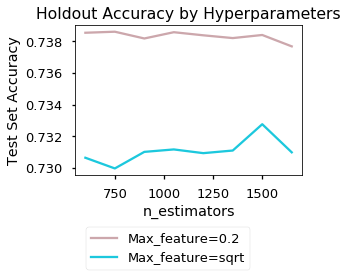

In [164]:
#testLGM(trainx,trainy,testx,testy, nleaves, mininleave):

def r():
    return np.random.rand()

#Now plot            
fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(111)

for s in max_features_values:
    plt.plot(n_estimators_values, res[s], 
             color=(r(),r(),r()), label='Max_feature={}'.format(s))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='best', bbox_to_anchor=(0.8, -0.3))
#plt.legend(loc=4, ncol=3, mode="expand")
ax.set_xlabel('n_estimators')
ax.set_ylabel('Test Set Accuracy')
plt.title('Holdout Accuracy by Hyperparameters')

#n_estimator made to 600

Text(0.5,1,'Holdout Accuracy by Hyperparameters')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


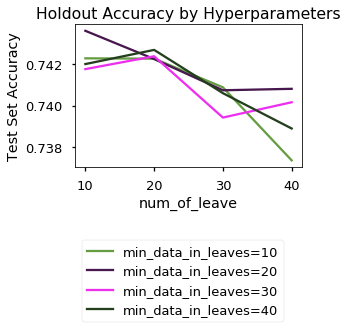

In [221]:
def r():
    return np.random.rand()

#Now plot            
fig = plt.figure(figsize = (5, 4))
ax = fig.add_subplot(111)

for s in min_data_in_leave_values:
    plt.plot(leavenumber_values, res2[s], 
             color=(r(),r(),r()), label='min_data_in_leaves={}'.format(s))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0, -0.8))
#plt.legend(loc=4, ncol=3, mode="expand")
ax.set_xlabel('num_of_leave')
ax.set_ylabel('Test Set Accuracy')
plt.title('Holdout Accuracy by Hyperparameters')

#n_estimator made to 600

In [171]:
#Cross Validation
def xValRF(dataset, lab, k, nes, maxf):
    '''
    Perform k-fold cross validation on RF and return the mean and std for this para setting
    '''
    n_samp = dataset.shape[0]
    cv = KFold(n = n_samp, n_folds = k)
    aucs = []

    for train_index, test_index in cv:
        tr_k = dataset.iloc[train_index]
        va_k = dataset.iloc[test_index]
        
        met = testRF(tr_k.drop(lab,1),tr_k[lab],va_k.drop(lab,1),va_k[lab],nes,maxf)
        aucs.append(met)
        
    
    return (np.mean(aucs),np.sqrt(np.array(aucs).var()/k))



In [169]:
dataset = pd.concat([X_Train,Y_Train],axis = 1)

In [172]:
max_features_values = [0.2,'sqrt']
n_estimators_values = [600,750,900,1050,1200,1350,1500,1650]
k = 5

res3mean = dict()
for s in max_features_values:
    res3mean[s] = list()
    
res3std = dict()
for s in max_features_values:
    res3std[s] = list()

#Now train and get results for each option
for s in max_features_values:
    for l in n_estimators_values:
        (a,b) = xValRF(dataset, 'Target', k, l, s)
        res3mean[s].append(a)
        res3std[s].append(b)
        

In [180]:
def xValLGM(dataset, lab, k, nl, ml):
    '''
    Perform k-fold cross validation on LGM and return the mean and std for this para setting
    '''
    n_samp = dataset.shape[0]
    cv = KFold(n = n_samp, n_folds = k)
    aucs = []

    for train_index, test_index in cv:
        tr_k = dataset.iloc[train_index]
        va_k = dataset.iloc[test_index]
        
        met = testLGM(tr_k.drop(lab,1),tr_k[lab],va_k.drop(lab,1),va_k[lab],nl,ml)
        aucs.append(met)
        
    
    return (np.mean(aucs),np.sqrt(np.array(aucs).var()/k))


In [181]:
leavenumber_values = [10,20,30,40]
min_data_in_leave_values = [10,20,30,40]
k = 5

res4mean = dict()
for s in min_data_in_leave_values:
    res4mean[s] = list()
    
res4std = dict()
for s in min_data_in_leave_values:
    res4std[s] = list()

#Now train and get results for each option
for s in min_data_in_leave_values:
    for l in leavenumber_values:
        (a,b) = xValLGM(dataset, 'Target', k, l, s)
        res4mean[s].append(a)
        res4std[s].append(b)

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614504
[2]	training's binary_logloss: 0.613479
[3]	training's binary_logloss: 0.612496
[4]	training's binary_logloss: 0.611552
[5]	training's binary_logloss: 0.610649
[6]	training's binary_logloss: 0.609737
[7]	training's binary_logloss: 0.608836
[8]	training's binary_logloss: 0.60809
[9]	training's binary_logloss: 0.607273
[10]	training's binary_logloss: 0.606471
[11]	training's binary_logloss: 0.605716
[12]	training's binary_logloss: 0.604997
[13]	training's binary_logloss: 0.604393
[14]	training's binary_logloss: 0.603696
[15]	training's binary_logloss: 0.603059
[16]	training's binary_logloss: 0.602578
[17]	training's binary_logloss: 0.602042
[18]	training's binary_logloss: 0.601557
[19]	training's binary_logloss: 0.600984
[20]	training's binary_logloss: 0.60057
[21]	training's binary_logloss: 0.600073
[22]	training's binary_logloss: 0.599521
[23]	training's binary_logloss: 0.598996
[24]	training's binary_logloss: 0.598485
[25]	training's binary_logl

[218]	training's binary_logloss: 0.592497
[219]	training's binary_logloss: 0.592488
[220]	training's binary_logloss: 0.592481
[221]	training's binary_logloss: 0.592483
[222]	training's binary_logloss: 0.592466
[223]	training's binary_logloss: 0.592468
[224]	training's binary_logloss: 0.592448
[225]	training's binary_logloss: 0.592431
[226]	training's binary_logloss: 0.592428
[227]	training's binary_logloss: 0.59244
[228]	training's binary_logloss: 0.592438
[229]	training's binary_logloss: 0.592451
[230]	training's binary_logloss: 0.592451
[231]	training's binary_logloss: 0.592422
[232]	training's binary_logloss: 0.592393
[233]	training's binary_logloss: 0.592367
[234]	training's binary_logloss: 0.59234
[235]	training's binary_logloss: 0.592315
[236]	training's binary_logloss: 0.592264
[237]	training's binary_logloss: 0.592232
[238]	training's binary_logloss: 0.592194
[239]	training's binary_logloss: 0.592152
[240]	training's binary_logloss: 0.592109
[241]	training's binary_logloss: 0.5

[476]	training's binary_logloss: 0.578953
[477]	training's binary_logloss: 0.578896
[478]	training's binary_logloss: 0.578838
[479]	training's binary_logloss: 0.578777
[480]	training's binary_logloss: 0.578716
[481]	training's binary_logloss: 0.578643
[482]	training's binary_logloss: 0.578582
[483]	training's binary_logloss: 0.578514
[484]	training's binary_logloss: 0.57845
[485]	training's binary_logloss: 0.578383
[486]	training's binary_logloss: 0.578274
[487]	training's binary_logloss: 0.578179
[488]	training's binary_logloss: 0.578092
[489]	training's binary_logloss: 0.578005
[490]	training's binary_logloss: 0.577919
[491]	training's binary_logloss: 0.577878
[492]	training's binary_logloss: 0.577842
[493]	training's binary_logloss: 0.577809
[494]	training's binary_logloss: 0.577775
[495]	training's binary_logloss: 0.57774
[496]	training's binary_logloss: 0.577651
[497]	training's binary_logloss: 0.577539
[498]	training's binary_logloss: 0.577449
[499]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614062
[2]	training's binary_logloss: 0.613016
[3]	training's binary_logloss: 0.612025
[4]	training's binary_logloss: 0.611069
[5]	training's binary_logloss: 0.610014
[6]	training's binary_logloss: 0.6091
[7]	training's binary_logloss: 0.608197
[8]	training's binary_logloss: 0.607337
[9]	training's binary_logloss: 0.606513
[10]	training's binary_logloss: 0.605837
[11]	training's binary_logloss: 0.604997
[12]	training's binary_logloss: 0.604193
[13]	training's binary_logloss: 0.603433
[14]	training's binary_logloss: 0.602798
[15]	training's binary_logloss: 0.60221
[16]	training's binary_logloss: 0.601497
[17]	training's binary_logloss: 0.600814
[18]	training's binary_logloss: 0.600185
[19]	training's binary_logloss: 0.599581
[20]	training's binary_logloss: 0.599041
[21]	training's binary_logloss: 0.598445
[22]	training's binary_logloss: 0.597914
[23]	training's binary_logloss: 0.597422
[24]	training's binary_logloss: 0.596921
[25]	training's binary_loglo

[254]	training's binary_logloss: 0.584988
[255]	training's binary_logloss: 0.584993
[256]	training's binary_logloss: 0.584961
[257]	training's binary_logloss: 0.58491
[258]	training's binary_logloss: 0.584858
[259]	training's binary_logloss: 0.584814
[260]	training's binary_logloss: 0.584769
[261]	training's binary_logloss: 0.584721
[262]	training's binary_logloss: 0.58469
[263]	training's binary_logloss: 0.584677
[264]	training's binary_logloss: 0.584664
[265]	training's binary_logloss: 0.58461
[266]	training's binary_logloss: 0.584632
[267]	training's binary_logloss: 0.584659
[268]	training's binary_logloss: 0.584678
[269]	training's binary_logloss: 0.584694
[270]	training's binary_logloss: 0.584711
[271]	training's binary_logloss: 0.584629
[272]	training's binary_logloss: 0.584536
[273]	training's binary_logloss: 0.584449
[274]	training's binary_logloss: 0.584363
[275]	training's binary_logloss: 0.58428
[276]	training's binary_logloss: 0.584208
[277]	training's binary_logloss: 0.584

[460]	training's binary_logloss: 0.571841
[461]	training's binary_logloss: 0.571751
[462]	training's binary_logloss: 0.571665
[463]	training's binary_logloss: 0.571568
[464]	training's binary_logloss: 0.571468
[465]	training's binary_logloss: 0.571386
[466]	training's binary_logloss: 0.57131
[467]	training's binary_logloss: 0.571221
[468]	training's binary_logloss: 0.571124
[469]	training's binary_logloss: 0.571045
[470]	training's binary_logloss: 0.570954
[471]	training's binary_logloss: 0.570891
[472]	training's binary_logloss: 0.570814
[473]	training's binary_logloss: 0.570737
[474]	training's binary_logloss: 0.570667
[475]	training's binary_logloss: 0.570609
[476]	training's binary_logloss: 0.570547
[477]	training's binary_logloss: 0.570487
[478]	training's binary_logloss: 0.570398
[479]	training's binary_logloss: 0.570322
[480]	training's binary_logloss: 0.570264
[481]	training's binary_logloss: 0.570191
[482]	training's binary_logloss: 0.570087
[483]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613332
[2]	training's binary_logloss: 0.612283
[3]	training's binary_logloss: 0.611278
[4]	training's binary_logloss: 0.610315
[5]	training's binary_logloss: 0.609302
[6]	training's binary_logloss: 0.608492
[7]	training's binary_logloss: 0.607667
[8]	training's binary_logloss: 0.606909
[9]	training's binary_logloss: 0.606124
[10]	training's binary_logloss: 0.605391
[11]	training's binary_logloss: 0.604529
[12]	training's binary_logloss: 0.603714
[13]	training's binary_logloss: 0.603046
[14]	training's binary_logloss: 0.602268
[15]	training's binary_logloss: 0.601535
[16]	training's binary_logloss: 0.600987
[17]	training's binary_logloss: 0.600293
[18]	training's binary_logloss: 0.599632
[19]	training's binary_logloss: 0.598994
[20]	training's binary_logloss: 0.598501
[21]	training's binary_logloss: 0.598033
[22]	training's binary_logloss: 0.597432
[23]	training's binary_logloss: 0.596861
[24]	training's binary_logloss: 0.5963
[25]	training's binary_logl

[258]	training's binary_logloss: 0.586621
[259]	training's binary_logloss: 0.586588
[260]	training's binary_logloss: 0.586538
[261]	training's binary_logloss: 0.586506
[262]	training's binary_logloss: 0.586486
[263]	training's binary_logloss: 0.586483
[264]	training's binary_logloss: 0.58647
[265]	training's binary_logloss: 0.586439
[266]	training's binary_logloss: 0.586443
[267]	training's binary_logloss: 0.586444
[268]	training's binary_logloss: 0.58645
[269]	training's binary_logloss: 0.586447
[270]	training's binary_logloss: 0.58645
[271]	training's binary_logloss: 0.58638
[272]	training's binary_logloss: 0.586294
[273]	training's binary_logloss: 0.586208
[274]	training's binary_logloss: 0.586127
[275]	training's binary_logloss: 0.586046
[276]	training's binary_logloss: 0.586004
[277]	training's binary_logloss: 0.585965
[278]	training's binary_logloss: 0.585937
[279]	training's binary_logloss: 0.585896
[280]	training's binary_logloss: 0.585869
[281]	training's binary_logloss: 0.585

[472]	training's binary_logloss: 0.573308
[473]	training's binary_logloss: 0.573249
[474]	training's binary_logloss: 0.573212
[475]	training's binary_logloss: 0.573159
[476]	training's binary_logloss: 0.573079
[477]	training's binary_logloss: 0.573015
[478]	training's binary_logloss: 0.572935
[479]	training's binary_logloss: 0.572876
[480]	training's binary_logloss: 0.572802
[481]	training's binary_logloss: 0.572728
[482]	training's binary_logloss: 0.572653
[483]	training's binary_logloss: 0.572581
[484]	training's binary_logloss: 0.572519
[485]	training's binary_logloss: 0.572451
[486]	training's binary_logloss: 0.572338
[487]	training's binary_logloss: 0.572226
[488]	training's binary_logloss: 0.572117
[489]	training's binary_logloss: 0.572004
[490]	training's binary_logloss: 0.571895
[491]	training's binary_logloss: 0.571812
[492]	training's binary_logloss: 0.571734
[493]	training's binary_logloss: 0.571648
[494]	training's binary_logloss: 0.571569
[495]	training's binary_logloss: 0

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617701
[2]	training's binary_logloss: 0.61669
[3]	training's binary_logloss: 0.615834
[4]	training's binary_logloss: 0.61486
[5]	training's binary_logloss: 0.613937
[6]	training's binary_logloss: 0.613041
[7]	training's binary_logloss: 0.612183
[8]	training's binary_logloss: 0.611359
[9]	training's binary_logloss: 0.610565
[10]	training's binary_logloss: 0.609817
[11]	training's binary_logloss: 0.609032
[12]	training's binary_logloss: 0.608312
[13]	training's binary_logloss: 0.60758
[14]	training's binary_logloss: 0.606802
[15]	training's binary_logloss: 0.60612
[16]	training's binary_logloss: 0.60552
[17]	training's binary_logloss: 0.604931
[18]	training's binary_logloss: 0.604278
[19]	training's binary_logloss: 0.603649
[20]	training's binary_logloss: 0.603045
[21]	training's binary_logloss: 0.602424
[22]	training's binary_logloss: 0.601917
[23]	training's binary_logloss: 0.601333
[24]	training's binary_logloss: 0.600778
[25]	training's binary_logloss

[257]	training's binary_logloss: 0.589057
[258]	training's binary_logloss: 0.589023
[259]	training's binary_logloss: 0.588966
[260]	training's binary_logloss: 0.588911
[261]	training's binary_logloss: 0.588878
[262]	training's binary_logloss: 0.588814
[263]	training's binary_logloss: 0.588734
[264]	training's binary_logloss: 0.588651
[265]	training's binary_logloss: 0.588585
[266]	training's binary_logloss: 0.588567
[267]	training's binary_logloss: 0.588548
[268]	training's binary_logloss: 0.588536
[269]	training's binary_logloss: 0.588521
[270]	training's binary_logloss: 0.588504
[271]	training's binary_logloss: 0.588484
[272]	training's binary_logloss: 0.588446
[273]	training's binary_logloss: 0.588395
[274]	training's binary_logloss: 0.588349
[275]	training's binary_logloss: 0.588304
[276]	training's binary_logloss: 0.58828
[277]	training's binary_logloss: 0.588242
[278]	training's binary_logloss: 0.588207
[279]	training's binary_logloss: 0.588172
[280]	training's binary_logloss: 0.

[467]	training's binary_logloss: 0.575673
[468]	training's binary_logloss: 0.575588
[469]	training's binary_logloss: 0.575498
[470]	training's binary_logloss: 0.575422
[471]	training's binary_logloss: 0.575368
[472]	training's binary_logloss: 0.575305
[473]	training's binary_logloss: 0.575242
[474]	training's binary_logloss: 0.575178
[475]	training's binary_logloss: 0.575117
[476]	training's binary_logloss: 0.575021
[477]	training's binary_logloss: 0.574926
[478]	training's binary_logloss: 0.574845
[479]	training's binary_logloss: 0.574741
[480]	training's binary_logloss: 0.574649
[481]	training's binary_logloss: 0.574559
[482]	training's binary_logloss: 0.574483
[483]	training's binary_logloss: 0.574409
[484]	training's binary_logloss: 0.574333
[485]	training's binary_logloss: 0.574253
[486]	training's binary_logloss: 0.574185
[487]	training's binary_logloss: 0.574118
[488]	training's binary_logloss: 0.574052
[489]	training's binary_logloss: 0.573988
[490]	training's binary_logloss: 0

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613828
[2]	training's binary_logloss: 0.612788
[3]	training's binary_logloss: 0.611792
[4]	training's binary_logloss: 0.61084
[5]	training's binary_logloss: 0.609872
[6]	training's binary_logloss: 0.609059
[7]	training's binary_logloss: 0.608226
[8]	training's binary_logloss: 0.607439
[9]	training's binary_logloss: 0.606668
[10]	training's binary_logloss: 0.605935
[11]	training's binary_logloss: 0.605233
[12]	training's binary_logloss: 0.604504
[13]	training's binary_logloss: 0.603871
[14]	training's binary_logloss: 0.603264
[15]	training's binary_logloss: 0.602609
[16]	training's binary_logloss: 0.602051
[17]	training's binary_logloss: 0.601427
[18]	training's binary_logloss: 0.600823
[19]	training's binary_logloss: 0.600245
[20]	training's binary_logloss: 0.599772
[21]	training's binary_logloss: 0.599294
[22]	training's binary_logloss: 0.59882
[23]	training's binary_logloss: 0.598396
[24]	training's binary_logloss: 0.597949
[25]	training's binary_logl

[260]	training's binary_logloss: 0.58941
[261]	training's binary_logloss: 0.589336
[262]	training's binary_logloss: 0.58927
[263]	training's binary_logloss: 0.589206
[264]	training's binary_logloss: 0.589146
[265]	training's binary_logloss: 0.589089
[266]	training's binary_logloss: 0.589054
[267]	training's binary_logloss: 0.589035
[268]	training's binary_logloss: 0.589021
[269]	training's binary_logloss: 0.589003
[270]	training's binary_logloss: 0.588969
[271]	training's binary_logloss: 0.588935
[272]	training's binary_logloss: 0.588919
[273]	training's binary_logloss: 0.588904
[274]	training's binary_logloss: 0.58889
[275]	training's binary_logloss: 0.588874
[276]	training's binary_logloss: 0.588826
[277]	training's binary_logloss: 0.588792
[278]	training's binary_logloss: 0.588757
[279]	training's binary_logloss: 0.588712
[280]	training's binary_logloss: 0.588678
[281]	training's binary_logloss: 0.58865
[282]	training's binary_logloss: 0.588628
[283]	training's binary_logloss: 0.588

[474]	training's binary_logloss: 0.57537
[475]	training's binary_logloss: 0.575303
[476]	training's binary_logloss: 0.575223
[477]	training's binary_logloss: 0.575141
[478]	training's binary_logloss: 0.575069
[479]	training's binary_logloss: 0.574996
[480]	training's binary_logloss: 0.574921
[481]	training's binary_logloss: 0.574836
[482]	training's binary_logloss: 0.574765
[483]	training's binary_logloss: 0.574694
[484]	training's binary_logloss: 0.57462
[485]	training's binary_logloss: 0.574553
[486]	training's binary_logloss: 0.574477
[487]	training's binary_logloss: 0.574403
[488]	training's binary_logloss: 0.574326
[489]	training's binary_logloss: 0.574252
[490]	training's binary_logloss: 0.574181
[491]	training's binary_logloss: 0.574096
[492]	training's binary_logloss: 0.574016
[493]	training's binary_logloss: 0.573933
[494]	training's binary_logloss: 0.573855
[495]	training's binary_logloss: 0.573777
[496]	training's binary_logloss: 0.573659
[497]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614271
[2]	training's binary_logloss: 0.613021
[3]	training's binary_logloss: 0.611814
[4]	training's binary_logloss: 0.610643
[5]	training's binary_logloss: 0.609525
[6]	training's binary_logloss: 0.608419
[7]	training's binary_logloss: 0.607297
[8]	training's binary_logloss: 0.60632
[9]	training's binary_logloss: 0.605238
[10]	training's binary_logloss: 0.604193
[11]	training's binary_logloss: 0.603208
[12]	training's binary_logloss: 0.602234
[13]	training's binary_logloss: 0.601398
[14]	training's binary_logloss: 0.600494
[15]	training's binary_logloss: 0.599637
[16]	training's binary_logloss: 0.598913
[17]	training's binary_logloss: 0.598044
[18]	training's binary_logloss: 0.597284
[19]	training's binary_logloss: 0.596473
[20]	training's binary_logloss: 0.595786
[21]	training's binary_logloss: 0.595089
[22]	training's binary_logloss: 0.59437
[23]	training's binary_logloss: 0.593685
[24]	training's binary_logloss: 0.592992
[25]	training's binary_logl

[237]	training's binary_logloss: 0.563577
[238]	training's binary_logloss: 0.563471
[239]	training's binary_logloss: 0.563341
[240]	training's binary_logloss: 0.563227
[241]	training's binary_logloss: 0.563127
[242]	training's binary_logloss: 0.563009
[243]	training's binary_logloss: 0.562898
[244]	training's binary_logloss: 0.562807
[245]	training's binary_logloss: 0.562694
[246]	training's binary_logloss: 0.562632
[247]	training's binary_logloss: 0.562578
[248]	training's binary_logloss: 0.562513
[249]	training's binary_logloss: 0.562455
[250]	training's binary_logloss: 0.562402
[251]	training's binary_logloss: 0.562296
[252]	training's binary_logloss: 0.562193
[253]	training's binary_logloss: 0.562086
[254]	training's binary_logloss: 0.561971
[255]	training's binary_logloss: 0.561839
[256]	training's binary_logloss: 0.561728
[257]	training's binary_logloss: 0.561616
[258]	training's binary_logloss: 0.561502
[259]	training's binary_logloss: 0.561395
[260]	training's binary_logloss: 0

[464]	training's binary_logloss: 0.534134
[465]	training's binary_logloss: 0.533982
[466]	training's binary_logloss: 0.533841
[467]	training's binary_logloss: 0.533697
[468]	training's binary_logloss: 0.533547
[469]	training's binary_logloss: 0.533388
[470]	training's binary_logloss: 0.533256
[471]	training's binary_logloss: 0.533128
[472]	training's binary_logloss: 0.533004
[473]	training's binary_logloss: 0.532872
[474]	training's binary_logloss: 0.53272
[475]	training's binary_logloss: 0.532611
[476]	training's binary_logloss: 0.532474
[477]	training's binary_logloss: 0.532342
[478]	training's binary_logloss: 0.532211
[479]	training's binary_logloss: 0.532081
[480]	training's binary_logloss: 0.531954
[481]	training's binary_logloss: 0.531827
[482]	training's binary_logloss: 0.531712
[483]	training's binary_logloss: 0.53158
[484]	training's binary_logloss: 0.53145
[485]	training's binary_logloss: 0.531309
[486]	training's binary_logloss: 0.531154
[487]	training's binary_logloss: 0.53

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613744
[2]	training's binary_logloss: 0.61239
[3]	training's binary_logloss: 0.611104
[4]	training's binary_logloss: 0.609801
[5]	training's binary_logloss: 0.608455
[6]	training's binary_logloss: 0.607281
[7]	training's binary_logloss: 0.606146
[8]	training's binary_logloss: 0.605042
[9]	training's binary_logloss: 0.603943
[10]	training's binary_logloss: 0.603021
[11]	training's binary_logloss: 0.601932
[12]	training's binary_logloss: 0.600886
[13]	training's binary_logloss: 0.599861
[14]	training's binary_logloss: 0.598979
[15]	training's binary_logloss: 0.598112
[16]	training's binary_logloss: 0.597198
[17]	training's binary_logloss: 0.596323
[18]	training's binary_logloss: 0.595473
[19]	training's binary_logloss: 0.594629
[20]	training's binary_logloss: 0.593894
[21]	training's binary_logloss: 0.59311
[22]	training's binary_logloss: 0.592352
[23]	training's binary_logloss: 0.591692
[24]	training's binary_logloss: 0.590999
[25]	training's binary_logl

[229]	training's binary_logloss: 0.556989
[230]	training's binary_logloss: 0.556901
[231]	training's binary_logloss: 0.5568
[232]	training's binary_logloss: 0.556718
[233]	training's binary_logloss: 0.556623
[234]	training's binary_logloss: 0.556536
[235]	training's binary_logloss: 0.556444
[236]	training's binary_logloss: 0.55633
[237]	training's binary_logloss: 0.556219
[238]	training's binary_logloss: 0.556111
[239]	training's binary_logloss: 0.556
[240]	training's binary_logloss: 0.555879
[241]	training's binary_logloss: 0.555759
[242]	training's binary_logloss: 0.555653
[243]	training's binary_logloss: 0.555547
[244]	training's binary_logloss: 0.55543
[245]	training's binary_logloss: 0.555318
[246]	training's binary_logloss: 0.555213
[247]	training's binary_logloss: 0.555098
[248]	training's binary_logloss: 0.55497
[249]	training's binary_logloss: 0.554849
[250]	training's binary_logloss: 0.554735
[251]	training's binary_logloss: 0.554627
[252]	training's binary_logloss: 0.554549


[451]	training's binary_logloss: 0.528196
[452]	training's binary_logloss: 0.528015
[453]	training's binary_logloss: 0.52788
[454]	training's binary_logloss: 0.527766
[455]	training's binary_logloss: 0.527626
[456]	training's binary_logloss: 0.527508
[457]	training's binary_logloss: 0.527401
[458]	training's binary_logloss: 0.527286
[459]	training's binary_logloss: 0.527175
[460]	training's binary_logloss: 0.527064
[461]	training's binary_logloss: 0.526897
[462]	training's binary_logloss: 0.526754
[463]	training's binary_logloss: 0.526596
[464]	training's binary_logloss: 0.526421
[465]	training's binary_logloss: 0.526246
[466]	training's binary_logloss: 0.526138
[467]	training's binary_logloss: 0.526008
[468]	training's binary_logloss: 0.525881
[469]	training's binary_logloss: 0.525764
[470]	training's binary_logloss: 0.5256
[471]	training's binary_logloss: 0.525486
[472]	training's binary_logloss: 0.525357
[473]	training's binary_logloss: 0.525226
[474]	training's binary_logloss: 0.52

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613033
[2]	training's binary_logloss: 0.611721
[3]	training's binary_logloss: 0.610453
[4]	training's binary_logloss: 0.609242
[5]	training's binary_logloss: 0.607963
[6]	training's binary_logloss: 0.606892
[7]	training's binary_logloss: 0.605777
[8]	training's binary_logloss: 0.604801
[9]	training's binary_logloss: 0.603697
[10]	training's binary_logloss: 0.602679
[11]	training's binary_logloss: 0.601622
[12]	training's binary_logloss: 0.60059
[13]	training's binary_logloss: 0.599666
[14]	training's binary_logloss: 0.598687
[15]	training's binary_logloss: 0.597744
[16]	training's binary_logloss: 0.597011
[17]	training's binary_logloss: 0.596065
[18]	training's binary_logloss: 0.595184
[19]	training's binary_logloss: 0.594303
[20]	training's binary_logloss: 0.593575
[21]	training's binary_logloss: 0.592848
[22]	training's binary_logloss: 0.59208
[23]	training's binary_logloss: 0.59138
[24]	training's binary_logloss: 0.590722
[25]	training's binary_loglo

[200]	training's binary_logloss: 0.561972
[201]	training's binary_logloss: 0.56187
[202]	training's binary_logloss: 0.561771
[203]	training's binary_logloss: 0.561678
[204]	training's binary_logloss: 0.561585
[205]	training's binary_logloss: 0.56153
[206]	training's binary_logloss: 0.561474
[207]	training's binary_logloss: 0.561417
[208]	training's binary_logloss: 0.56136
[209]	training's binary_logloss: 0.561287
[210]	training's binary_logloss: 0.561234
[211]	training's binary_logloss: 0.561167
[212]	training's binary_logloss: 0.561093
[213]	training's binary_logloss: 0.56103
[214]	training's binary_logloss: 0.560981
[215]	training's binary_logloss: 0.560923
[216]	training's binary_logloss: 0.560807
[217]	training's binary_logloss: 0.560692
[218]	training's binary_logloss: 0.560557
[219]	training's binary_logloss: 0.560448
[220]	training's binary_logloss: 0.56034
[221]	training's binary_logloss: 0.560218
[222]	training's binary_logloss: 0.560106
[223]	training's binary_logloss: 0.5599

[423]	training's binary_logloss: 0.534679
[424]	training's binary_logloss: 0.534571
[425]	training's binary_logloss: 0.534487
[426]	training's binary_logloss: 0.53434
[427]	training's binary_logloss: 0.534198
[428]	training's binary_logloss: 0.534064
[429]	training's binary_logloss: 0.533938
[430]	training's binary_logloss: 0.533805
[431]	training's binary_logloss: 0.533632
[432]	training's binary_logloss: 0.533452
[433]	training's binary_logloss: 0.533271
[434]	training's binary_logloss: 0.533108
[435]	training's binary_logloss: 0.532948
[436]	training's binary_logloss: 0.532821
[437]	training's binary_logloss: 0.532697
[438]	training's binary_logloss: 0.532565
[439]	training's binary_logloss: 0.532453
[440]	training's binary_logloss: 0.532355
[441]	training's binary_logloss: 0.532192
[442]	training's binary_logloss: 0.532042
[443]	training's binary_logloss: 0.531904
[444]	training's binary_logloss: 0.531765
[445]	training's binary_logloss: 0.53164
[446]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617428
[2]	training's binary_logloss: 0.616164
[3]	training's binary_logloss: 0.614987
[4]	training's binary_logloss: 0.613746
[5]	training's binary_logloss: 0.612571
[6]	training's binary_logloss: 0.611385
[7]	training's binary_logloss: 0.61024
[8]	training's binary_logloss: 0.609141
[9]	training's binary_logloss: 0.608076
[10]	training's binary_logloss: 0.607046
[11]	training's binary_logloss: 0.605994
[12]	training's binary_logloss: 0.605008
[13]	training's binary_logloss: 0.604053
[14]	training's binary_logloss: 0.603072
[15]	training's binary_logloss: 0.602127
[16]	training's binary_logloss: 0.601322
[17]	training's binary_logloss: 0.600533
[18]	training's binary_logloss: 0.5998
[19]	training's binary_logloss: 0.598956
[20]	training's binary_logloss: 0.598205
[21]	training's binary_logloss: 0.597434
[22]	training's binary_logloss: 0.596731
[23]	training's binary_logloss: 0.595956
[24]	training's binary_logloss: 0.595195
[25]	training's binary_loglo

[236]	training's binary_logloss: 0.561642
[237]	training's binary_logloss: 0.561511
[238]	training's binary_logloss: 0.561399
[239]	training's binary_logloss: 0.561295
[240]	training's binary_logloss: 0.561185
[241]	training's binary_logloss: 0.561048
[242]	training's binary_logloss: 0.560916
[243]	training's binary_logloss: 0.560753
[244]	training's binary_logloss: 0.560635
[245]	training's binary_logloss: 0.560501
[246]	training's binary_logloss: 0.560371
[247]	training's binary_logloss: 0.560235
[248]	training's binary_logloss: 0.560073
[249]	training's binary_logloss: 0.559954
[250]	training's binary_logloss: 0.559793
[251]	training's binary_logloss: 0.559683
[252]	training's binary_logloss: 0.559578
[253]	training's binary_logloss: 0.559477
[254]	training's binary_logloss: 0.559383
[255]	training's binary_logloss: 0.559275
[256]	training's binary_logloss: 0.55916
[257]	training's binary_logloss: 0.559058
[258]	training's binary_logloss: 0.558972
[259]	training's binary_logloss: 0.

[458]	training's binary_logloss: 0.532392
[459]	training's binary_logloss: 0.532226
[460]	training's binary_logloss: 0.532082
[461]	training's binary_logloss: 0.531966
[462]	training's binary_logloss: 0.531871
[463]	training's binary_logloss: 0.531761
[464]	training's binary_logloss: 0.531667
[465]	training's binary_logloss: 0.531581
[466]	training's binary_logloss: 0.531395
[467]	training's binary_logloss: 0.5312
[468]	training's binary_logloss: 0.53103
[469]	training's binary_logloss: 0.530862
[470]	training's binary_logloss: 0.53069
[471]	training's binary_logloss: 0.530548
[472]	training's binary_logloss: 0.530409
[473]	training's binary_logloss: 0.53028
[474]	training's binary_logloss: 0.530156
[475]	training's binary_logloss: 0.530031
[476]	training's binary_logloss: 0.529874
[477]	training's binary_logloss: 0.529717
[478]	training's binary_logloss: 0.529562
[479]	training's binary_logloss: 0.529417
[480]	training's binary_logloss: 0.529262
[481]	training's binary_logloss: 0.5290

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.61348
[2]	training's binary_logloss: 0.612143
[3]	training's binary_logloss: 0.610883
[4]	training's binary_logloss: 0.609594
[5]	training's binary_logloss: 0.608355
[6]	training's binary_logloss: 0.607225
[7]	training's binary_logloss: 0.606068
[8]	training's binary_logloss: 0.605025
[9]	training's binary_logloss: 0.603919
[10]	training's binary_logloss: 0.602868
[11]	training's binary_logloss: 0.6019
[12]	training's binary_logloss: 0.600961
[13]	training's binary_logloss: 0.600123
[14]	training's binary_logloss: 0.599227
[15]	training's binary_logloss: 0.598361
[16]	training's binary_logloss: 0.597618
[17]	training's binary_logloss: 0.596779
[18]	training's binary_logloss: 0.595972
[19]	training's binary_logloss: 0.595202
[20]	training's binary_logloss: 0.594541
[21]	training's binary_logloss: 0.593865
[22]	training's binary_logloss: 0.59322
[23]	training's binary_logloss: 0.5926
[24]	training's binary_logloss: 0.591903
[25]	training's binary_logloss:

[235]	training's binary_logloss: 0.560795
[236]	training's binary_logloss: 0.560696
[237]	training's binary_logloss: 0.560587
[238]	training's binary_logloss: 0.560487
[239]	training's binary_logloss: 0.560402
[240]	training's binary_logloss: 0.56027
[241]	training's binary_logloss: 0.560175
[242]	training's binary_logloss: 0.560081
[243]	training's binary_logloss: 0.559981
[244]	training's binary_logloss: 0.559895
[245]	training's binary_logloss: 0.559789
[246]	training's binary_logloss: 0.559664
[247]	training's binary_logloss: 0.55954
[248]	training's binary_logloss: 0.559406
[249]	training's binary_logloss: 0.559291
[250]	training's binary_logloss: 0.559178
[251]	training's binary_logloss: 0.559064
[252]	training's binary_logloss: 0.558954
[253]	training's binary_logloss: 0.558854
[254]	training's binary_logloss: 0.558752
[255]	training's binary_logloss: 0.558653
[256]	training's binary_logloss: 0.558527
[257]	training's binary_logloss: 0.558433
[258]	training's binary_logloss: 0.5

[459]	training's binary_logloss: 0.531532
[460]	training's binary_logloss: 0.531397
[461]	training's binary_logloss: 0.531227
[462]	training's binary_logloss: 0.531071
[463]	training's binary_logloss: 0.530928
[464]	training's binary_logloss: 0.530753
[465]	training's binary_logloss: 0.530603
[466]	training's binary_logloss: 0.530425
[467]	training's binary_logloss: 0.530254
[468]	training's binary_logloss: 0.53008
[469]	training's binary_logloss: 0.529911
[470]	training's binary_logloss: 0.529729
[471]	training's binary_logloss: 0.529585
[472]	training's binary_logloss: 0.529453
[473]	training's binary_logloss: 0.529279
[474]	training's binary_logloss: 0.52913
[475]	training's binary_logloss: 0.528989
[476]	training's binary_logloss: 0.528864
[477]	training's binary_logloss: 0.528728
[478]	training's binary_logloss: 0.528602
[479]	training's binary_logloss: 0.528477
[480]	training's binary_logloss: 0.528352
[481]	training's binary_logloss: 0.528195
[482]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.6141
[2]	training's binary_logloss: 0.612692
[3]	training's binary_logloss: 0.611316
[4]	training's binary_logloss: 0.610001
[5]	training's binary_logloss: 0.608715
[6]	training's binary_logloss: 0.607456
[7]	training's binary_logloss: 0.606187
[8]	training's binary_logloss: 0.605049
[9]	training's binary_logloss: 0.603859
[10]	training's binary_logloss: 0.602702
[11]	training's binary_logloss: 0.601586
[12]	training's binary_logloss: 0.600468
[13]	training's binary_logloss: 0.59945
[14]	training's binary_logloss: 0.598405
[15]	training's binary_logloss: 0.597398
[16]	training's binary_logloss: 0.596493
[17]	training's binary_logloss: 0.595482
[18]	training's binary_logloss: 0.594488
[19]	training's binary_logloss: 0.593574
[20]	training's binary_logloss: 0.592741
[21]	training's binary_logloss: 0.591913
[22]	training's binary_logloss: 0.591067
[23]	training's binary_logloss: 0.590278
[24]	training's binary_logloss: 0.589453
[25]	training's binary_loglo

[223]	training's binary_logloss: 0.541639
[224]	training's binary_logloss: 0.541438
[225]	training's binary_logloss: 0.541227
[226]	training's binary_logloss: 0.541058
[227]	training's binary_logloss: 0.540935
[228]	training's binary_logloss: 0.540775
[229]	training's binary_logloss: 0.540633
[230]	training's binary_logloss: 0.540473
[231]	training's binary_logloss: 0.540268
[232]	training's binary_logloss: 0.540102
[233]	training's binary_logloss: 0.539912
[234]	training's binary_logloss: 0.53974
[235]	training's binary_logloss: 0.539538
[236]	training's binary_logloss: 0.539345
[237]	training's binary_logloss: 0.539155
[238]	training's binary_logloss: 0.538969
[239]	training's binary_logloss: 0.538778
[240]	training's binary_logloss: 0.538594
[241]	training's binary_logloss: 0.538401
[242]	training's binary_logloss: 0.538238
[243]	training's binary_logloss: 0.538058
[244]	training's binary_logloss: 0.537886
[245]	training's binary_logloss: 0.53769
[246]	training's binary_logloss: 0.5

[424]	training's binary_logloss: 0.503691
[425]	training's binary_logloss: 0.503531
[426]	training's binary_logloss: 0.503366
[427]	training's binary_logloss: 0.503196
[428]	training's binary_logloss: 0.503033
[429]	training's binary_logloss: 0.50285
[430]	training's binary_logloss: 0.502687
[431]	training's binary_logloss: 0.502472
[432]	training's binary_logloss: 0.502252
[433]	training's binary_logloss: 0.502051
[434]	training's binary_logloss: 0.501804
[435]	training's binary_logloss: 0.501563
[436]	training's binary_logloss: 0.501359
[437]	training's binary_logloss: 0.501158
[438]	training's binary_logloss: 0.500963
[439]	training's binary_logloss: 0.500774
[440]	training's binary_logloss: 0.500586
[441]	training's binary_logloss: 0.500385
[442]	training's binary_logloss: 0.500195
[443]	training's binary_logloss: 0.500041
[444]	training's binary_logloss: 0.499868
[445]	training's binary_logloss: 0.499697
[446]	training's binary_logloss: 0.499522
[447]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613596
[2]	training's binary_logloss: 0.612097
[3]	training's binary_logloss: 0.610647
[4]	training's binary_logloss: 0.609184
[5]	training's binary_logloss: 0.607707
[6]	training's binary_logloss: 0.606381
[7]	training's binary_logloss: 0.605063
[8]	training's binary_logloss: 0.603803
[9]	training's binary_logloss: 0.602564
[10]	training's binary_logloss: 0.601475
[11]	training's binary_logloss: 0.600217
[12]	training's binary_logloss: 0.599021
[13]	training's binary_logloss: 0.597853
[14]	training's binary_logloss: 0.596826
[15]	training's binary_logloss: 0.59581
[16]	training's binary_logloss: 0.594744
[17]	training's binary_logloss: 0.593683
[18]	training's binary_logloss: 0.592677
[19]	training's binary_logloss: 0.591702
[20]	training's binary_logloss: 0.590809
[21]	training's binary_logloss: 0.589886
[22]	training's binary_logloss: 0.588979
[23]	training's binary_logloss: 0.588174
[24]	training's binary_logloss: 0.587306
[25]	training's binary_log

[207]	training's binary_logloss: 0.537017
[208]	training's binary_logloss: 0.536848
[209]	training's binary_logloss: 0.536716
[210]	training's binary_logloss: 0.536532
[211]	training's binary_logloss: 0.536382
[212]	training's binary_logloss: 0.536228
[213]	training's binary_logloss: 0.536088
[214]	training's binary_logloss: 0.535957
[215]	training's binary_logloss: 0.53582
[216]	training's binary_logloss: 0.535619
[217]	training's binary_logloss: 0.535413
[218]	training's binary_logloss: 0.535223
[219]	training's binary_logloss: 0.53502
[220]	training's binary_logloss: 0.534813
[221]	training's binary_logloss: 0.534577
[222]	training's binary_logloss: 0.53435
[223]	training's binary_logloss: 0.534127
[224]	training's binary_logloss: 0.533909
[225]	training's binary_logloss: 0.533705
[226]	training's binary_logloss: 0.53355
[227]	training's binary_logloss: 0.533408
[228]	training's binary_logloss: 0.533245
[229]	training's binary_logloss: 0.533091
[230]	training's binary_logloss: 0.532

[409]	training's binary_logloss: 0.499483
[410]	training's binary_logloss: 0.499292
[411]	training's binary_logloss: 0.499054
[412]	training's binary_logloss: 0.498797
[413]	training's binary_logloss: 0.498576
[414]	training's binary_logloss: 0.498363
[415]	training's binary_logloss: 0.498161
[416]	training's binary_logloss: 0.497951
[417]	training's binary_logloss: 0.497739
[418]	training's binary_logloss: 0.497526
[419]	training's binary_logloss: 0.497324
[420]	training's binary_logloss: 0.497071
[421]	training's binary_logloss: 0.496927
[422]	training's binary_logloss: 0.496758
[423]	training's binary_logloss: 0.496609
[424]	training's binary_logloss: 0.496447
[425]	training's binary_logloss: 0.496308
[426]	training's binary_logloss: 0.496154
[427]	training's binary_logloss: 0.495948
[428]	training's binary_logloss: 0.495767
[429]	training's binary_logloss: 0.495572
[430]	training's binary_logloss: 0.495367
[431]	training's binary_logloss: 0.49514
[432]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.612787
[2]	training's binary_logloss: 0.611259
[3]	training's binary_logloss: 0.609787
[4]	training's binary_logloss: 0.608383
[5]	training's binary_logloss: 0.606938
[6]	training's binary_logloss: 0.605696
[7]	training's binary_logloss: 0.604414
[8]	training's binary_logloss: 0.603262
[9]	training's binary_logloss: 0.602038
[10]	training's binary_logloss: 0.600825
[11]	training's binary_logloss: 0.599614
[12]	training's binary_logloss: 0.598433
[13]	training's binary_logloss: 0.597341
[14]	training's binary_logloss: 0.596221
[15]	training's binary_logloss: 0.595187
[16]	training's binary_logloss: 0.594317
[17]	training's binary_logloss: 0.593293
[18]	training's binary_logloss: 0.592303
[19]	training's binary_logloss: 0.591327
[20]	training's binary_logloss: 0.590448
[21]	training's binary_logloss: 0.589566
[22]	training's binary_logloss: 0.588639
[23]	training's binary_logloss: 0.587799
[24]	training's binary_logloss: 0.587006
[25]	training's binary_lo

[207]	training's binary_logloss: 0.53977
[208]	training's binary_logloss: 0.539629
[209]	training's binary_logloss: 0.53948
[210]	training's binary_logloss: 0.539348
[211]	training's binary_logloss: 0.539193
[212]	training's binary_logloss: 0.539028
[213]	training's binary_logloss: 0.538868
[214]	training's binary_logloss: 0.538739
[215]	training's binary_logloss: 0.538606
[216]	training's binary_logloss: 0.538428
[217]	training's binary_logloss: 0.538222
[218]	training's binary_logloss: 0.538034
[219]	training's binary_logloss: 0.53787
[220]	training's binary_logloss: 0.537684
[221]	training's binary_logloss: 0.537493
[222]	training's binary_logloss: 0.53732
[223]	training's binary_logloss: 0.537143
[224]	training's binary_logloss: 0.536966
[225]	training's binary_logloss: 0.536788
[226]	training's binary_logloss: 0.536594
[227]	training's binary_logloss: 0.536422
[228]	training's binary_logloss: 0.536239
[229]	training's binary_logloss: 0.536058
[230]	training's binary_logloss: 0.535

[409]	training's binary_logloss: 0.501361
[410]	training's binary_logloss: 0.501159
[411]	training's binary_logloss: 0.500933
[412]	training's binary_logloss: 0.500722
[413]	training's binary_logloss: 0.500524
[414]	training's binary_logloss: 0.500321
[415]	training's binary_logloss: 0.50012
[416]	training's binary_logloss: 0.499903
[417]	training's binary_logloss: 0.499707
[418]	training's binary_logloss: 0.499518
[419]	training's binary_logloss: 0.499299
[420]	training's binary_logloss: 0.499127
[421]	training's binary_logloss: 0.498986
[422]	training's binary_logloss: 0.498849
[423]	training's binary_logloss: 0.498716
[424]	training's binary_logloss: 0.498557
[425]	training's binary_logloss: 0.498401
[426]	training's binary_logloss: 0.498217
[427]	training's binary_logloss: 0.498044
[428]	training's binary_logloss: 0.497866
[429]	training's binary_logloss: 0.497683
[430]	training's binary_logloss: 0.497503
[431]	training's binary_logloss: 0.497285
[432]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617264
[2]	training's binary_logloss: 0.615832
[3]	training's binary_logloss: 0.614481
[4]	training's binary_logloss: 0.613073
[5]	training's binary_logloss: 0.611711
[6]	training's binary_logloss: 0.61036
[7]	training's binary_logloss: 0.609056
[8]	training's binary_logloss: 0.60779
[9]	training's binary_logloss: 0.606572
[10]	training's binary_logloss: 0.605392
[11]	training's binary_logloss: 0.604178
[12]	training's binary_logloss: 0.603032
[13]	training's binary_logloss: 0.601871
[14]	training's binary_logloss: 0.600763
[15]	training's binary_logloss: 0.599663
[16]	training's binary_logloss: 0.598658
[17]	training's binary_logloss: 0.597652
[18]	training's binary_logloss: 0.59674
[19]	training's binary_logloss: 0.595749
[20]	training's binary_logloss: 0.59485
[21]	training's binary_logloss: 0.593859
[22]	training's binary_logloss: 0.593013
[23]	training's binary_logloss: 0.592063
[24]	training's binary_logloss: 0.591164
[25]	training's binary_loglos

[209]	training's binary_logloss: 0.54215
[210]	training's binary_logloss: 0.542022
[211]	training's binary_logloss: 0.541838
[212]	training's binary_logloss: 0.541653
[213]	training's binary_logloss: 0.541487
[214]	training's binary_logloss: 0.541303
[215]	training's binary_logloss: 0.541144
[216]	training's binary_logloss: 0.540931
[217]	training's binary_logloss: 0.540749
[218]	training's binary_logloss: 0.540573
[219]	training's binary_logloss: 0.540389
[220]	training's binary_logloss: 0.54023
[221]	training's binary_logloss: 0.540066
[222]	training's binary_logloss: 0.539901
[223]	training's binary_logloss: 0.539745
[224]	training's binary_logloss: 0.539532
[225]	training's binary_logloss: 0.539333
[226]	training's binary_logloss: 0.539166
[227]	training's binary_logloss: 0.538991
[228]	training's binary_logloss: 0.538793
[229]	training's binary_logloss: 0.538609
[230]	training's binary_logloss: 0.538441
[231]	training's binary_logloss: 0.538265
[232]	training's binary_logloss: 0.5

[412]	training's binary_logloss: 0.502968
[413]	training's binary_logloss: 0.502791
[414]	training's binary_logloss: 0.5026
[415]	training's binary_logloss: 0.502445
[416]	training's binary_logloss: 0.502236
[417]	training's binary_logloss: 0.502029
[418]	training's binary_logloss: 0.501827
[419]	training's binary_logloss: 0.501649
[420]	training's binary_logloss: 0.501433
[421]	training's binary_logloss: 0.50127
[422]	training's binary_logloss: 0.501103
[423]	training's binary_logloss: 0.500913
[424]	training's binary_logloss: 0.500753
[425]	training's binary_logloss: 0.50057
[426]	training's binary_logloss: 0.500398
[427]	training's binary_logloss: 0.500213
[428]	training's binary_logloss: 0.500035
[429]	training's binary_logloss: 0.499837
[430]	training's binary_logloss: 0.499668
[431]	training's binary_logloss: 0.499476
[432]	training's binary_logloss: 0.499297
[433]	training's binary_logloss: 0.499139
[434]	training's binary_logloss: 0.498976
[435]	training's binary_logloss: 0.498

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613305
[2]	training's binary_logloss: 0.611789
[3]	training's binary_logloss: 0.610337
[4]	training's binary_logloss: 0.608855
[5]	training's binary_logloss: 0.607445
[6]	training's binary_logloss: 0.606142
[7]	training's binary_logloss: 0.604805
[8]	training's binary_logloss: 0.603593
[9]	training's binary_logloss: 0.602338
[10]	training's binary_logloss: 0.60113
[11]	training's binary_logloss: 0.599968
[12]	training's binary_logloss: 0.598877
[13]	training's binary_logloss: 0.597897
[14]	training's binary_logloss: 0.596856
[15]	training's binary_logloss: 0.595847
[16]	training's binary_logloss: 0.59495
[17]	training's binary_logloss: 0.593981
[18]	training's binary_logloss: 0.593041
[19]	training's binary_logloss: 0.592134
[20]	training's binary_logloss: 0.591334
[21]	training's binary_logloss: 0.590505
[22]	training's binary_logloss: 0.589709
[23]	training's binary_logloss: 0.588935
[24]	training's binary_logloss: 0.588102
[25]	training's binary_logl

[211]	training's binary_logloss: 0.540698
[212]	training's binary_logloss: 0.540511
[213]	training's binary_logloss: 0.540336
[214]	training's binary_logloss: 0.540167
[215]	training's binary_logloss: 0.539995
[216]	training's binary_logloss: 0.539807
[217]	training's binary_logloss: 0.539637
[218]	training's binary_logloss: 0.539445
[219]	training's binary_logloss: 0.539255
[220]	training's binary_logloss: 0.539049
[221]	training's binary_logloss: 0.538901
[222]	training's binary_logloss: 0.538736
[223]	training's binary_logloss: 0.538501
[224]	training's binary_logloss: 0.538338
[225]	training's binary_logloss: 0.538181
[226]	training's binary_logloss: 0.538015
[227]	training's binary_logloss: 0.537808
[228]	training's binary_logloss: 0.537617
[229]	training's binary_logloss: 0.537469
[230]	training's binary_logloss: 0.537314
[231]	training's binary_logloss: 0.537101
[232]	training's binary_logloss: 0.536885
[233]	training's binary_logloss: 0.536682
[234]	training's binary_logloss: 0

[411]	training's binary_logloss: 0.501834
[412]	training's binary_logloss: 0.501665
[413]	training's binary_logloss: 0.501457
[414]	training's binary_logloss: 0.50126
[415]	training's binary_logloss: 0.501071
[416]	training's binary_logloss: 0.500859
[417]	training's binary_logloss: 0.500677
[418]	training's binary_logloss: 0.500481
[419]	training's binary_logloss: 0.500287
[420]	training's binary_logloss: 0.500085
[421]	training's binary_logloss: 0.499958
[422]	training's binary_logloss: 0.499808
[423]	training's binary_logloss: 0.49967
[424]	training's binary_logloss: 0.499529
[425]	training's binary_logloss: 0.499378
[426]	training's binary_logloss: 0.499186
[427]	training's binary_logloss: 0.49898
[428]	training's binary_logloss: 0.498782
[429]	training's binary_logloss: 0.498595
[430]	training's binary_logloss: 0.498355
[431]	training's binary_logloss: 0.498207
[432]	training's binary_logloss: 0.498054
[433]	training's binary_logloss: 0.497887
[434]	training's binary_logloss: 0.49

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613955
[2]	training's binary_logloss: 0.61241
[3]	training's binary_logloss: 0.610885
[4]	training's binary_logloss: 0.609449
[5]	training's binary_logloss: 0.607986
[6]	training's binary_logloss: 0.606581
[7]	training's binary_logloss: 0.605169
[8]	training's binary_logloss: 0.603895
[9]	training's binary_logloss: 0.602563
[10]	training's binary_logloss: 0.601268
[11]	training's binary_logloss: 0.600027
[12]	training's binary_logloss: 0.598776
[13]	training's binary_logloss: 0.597609
[14]	training's binary_logloss: 0.596446
[15]	training's binary_logloss: 0.595334
[16]	training's binary_logloss: 0.59427
[17]	training's binary_logloss: 0.593208
[18]	training's binary_logloss: 0.592061
[19]	training's binary_logloss: 0.590976
[20]	training's binary_logloss: 0.59
[21]	training's binary_logloss: 0.58907
[22]	training's binary_logloss: 0.588102
[23]	training's binary_logloss: 0.587174
[24]	training's binary_logloss: 0.58625
[25]	training's binary_logloss: 0

[224]	training's binary_logloss: 0.52082
[225]	training's binary_logloss: 0.52056
[226]	training's binary_logloss: 0.520348
[227]	training's binary_logloss: 0.520143
[228]	training's binary_logloss: 0.519914
[229]	training's binary_logloss: 0.519698
[230]	training's binary_logloss: 0.519509
[231]	training's binary_logloss: 0.519254
[232]	training's binary_logloss: 0.519021
[233]	training's binary_logloss: 0.518791
[234]	training's binary_logloss: 0.51854
[235]	training's binary_logloss: 0.518278
[236]	training's binary_logloss: 0.518026
[237]	training's binary_logloss: 0.517769
[238]	training's binary_logloss: 0.517532
[239]	training's binary_logloss: 0.517279
[240]	training's binary_logloss: 0.517037
[241]	training's binary_logloss: 0.516764
[242]	training's binary_logloss: 0.516532
[243]	training's binary_logloss: 0.51628
[244]	training's binary_logloss: 0.516001
[245]	training's binary_logloss: 0.515749
[246]	training's binary_logloss: 0.515553
[247]	training's binary_logloss: 0.515

[420]	training's binary_logloss: 0.472992
[421]	training's binary_logloss: 0.472759
[422]	training's binary_logloss: 0.472575
[423]	training's binary_logloss: 0.472352
[424]	training's binary_logloss: 0.472135
[425]	training's binary_logloss: 0.471929
[426]	training's binary_logloss: 0.471723
[427]	training's binary_logloss: 0.471534
[428]	training's binary_logloss: 0.471334
[429]	training's binary_logloss: 0.471116
[430]	training's binary_logloss: 0.470923
[431]	training's binary_logloss: 0.470712
[432]	training's binary_logloss: 0.470486
[433]	training's binary_logloss: 0.470256
[434]	training's binary_logloss: 0.470024
[435]	training's binary_logloss: 0.469815
[436]	training's binary_logloss: 0.469538
[437]	training's binary_logloss: 0.469337
[438]	training's binary_logloss: 0.46908
[439]	training's binary_logloss: 0.468878
[440]	training's binary_logloss: 0.468609
[441]	training's binary_logloss: 0.468379
[442]	training's binary_logloss: 0.46813
[443]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613466
[2]	training's binary_logloss: 0.611816
[3]	training's binary_logloss: 0.610224
[4]	training's binary_logloss: 0.608618
[5]	training's binary_logloss: 0.607007
[6]	training's binary_logloss: 0.605537
[7]	training's binary_logloss: 0.604109
[8]	training's binary_logloss: 0.602686
[9]	training's binary_logloss: 0.601317
[10]	training's binary_logloss: 0.600082
[11]	training's binary_logloss: 0.598691
[12]	training's binary_logloss: 0.597348
[13]	training's binary_logloss: 0.596038
[14]	training's binary_logloss: 0.594873
[15]	training's binary_logloss: 0.593731
[16]	training's binary_logloss: 0.592484
[17]	training's binary_logloss: 0.59129
[18]	training's binary_logloss: 0.590125
[19]	training's binary_logloss: 0.589029
[20]	training's binary_logloss: 0.58798
[21]	training's binary_logloss: 0.586931
[22]	training's binary_logloss: 0.585893
[23]	training's binary_logloss: 0.584966
[24]	training's binary_logloss: 0.583978
[25]	training's binary_logl

[222]	training's binary_logloss: 0.513465
[223]	training's binary_logloss: 0.513182
[224]	training's binary_logloss: 0.512901
[225]	training's binary_logloss: 0.512633
[226]	training's binary_logloss: 0.512429
[227]	training's binary_logloss: 0.512218
[228]	training's binary_logloss: 0.511978
[229]	training's binary_logloss: 0.511777
[230]	training's binary_logloss: 0.511539
[231]	training's binary_logloss: 0.511308
[232]	training's binary_logloss: 0.511089
[233]	training's binary_logloss: 0.510866
[234]	training's binary_logloss: 0.510641
[235]	training's binary_logloss: 0.510421
[236]	training's binary_logloss: 0.510121
[237]	training's binary_logloss: 0.509835
[238]	training's binary_logloss: 0.509561
[239]	training's binary_logloss: 0.50928
[240]	training's binary_logloss: 0.50901
[241]	training's binary_logloss: 0.508766
[242]	training's binary_logloss: 0.508527
[243]	training's binary_logloss: 0.508266
[244]	training's binary_logloss: 0.50803
[245]	training's binary_logloss: 0.50

[419]	training's binary_logloss: 0.465858
[420]	training's binary_logloss: 0.46555
[421]	training's binary_logloss: 0.465316
[422]	training's binary_logloss: 0.465105
[423]	training's binary_logloss: 0.464879
[424]	training's binary_logloss: 0.464702
[425]	training's binary_logloss: 0.464491
[426]	training's binary_logloss: 0.464309
[427]	training's binary_logloss: 0.46406
[428]	training's binary_logloss: 0.46382
[429]	training's binary_logloss: 0.463579
[430]	training's binary_logloss: 0.463348
[431]	training's binary_logloss: 0.463079
[432]	training's binary_logloss: 0.462821
[433]	training's binary_logloss: 0.462534
[434]	training's binary_logloss: 0.462247
[435]	training's binary_logloss: 0.461974
[436]	training's binary_logloss: 0.461696
[437]	training's binary_logloss: 0.461392
[438]	training's binary_logloss: 0.461116
[439]	training's binary_logloss: 0.460836
[440]	training's binary_logloss: 0.46055
[441]	training's binary_logloss: 0.460285
[442]	training's binary_logloss: 0.460

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.612624
[2]	training's binary_logloss: 0.610937
[3]	training's binary_logloss: 0.60929
[4]	training's binary_logloss: 0.607711
[5]	training's binary_logloss: 0.606138
[6]	training's binary_logloss: 0.60475
[7]	training's binary_logloss: 0.603334
[8]	training's binary_logloss: 0.602037
[9]	training's binary_logloss: 0.600681
[10]	training's binary_logloss: 0.599323
[11]	training's binary_logloss: 0.597975
[12]	training's binary_logloss: 0.596664
[13]	training's binary_logloss: 0.595466
[14]	training's binary_logloss: 0.594218
[15]	training's binary_logloss: 0.593067
[16]	training's binary_logloss: 0.59205
[17]	training's binary_logloss: 0.590898
[18]	training's binary_logloss: 0.589775
[19]	training's binary_logloss: 0.588679
[20]	training's binary_logloss: 0.587651
[21]	training's binary_logloss: 0.586609
[22]	training's binary_logloss: 0.585563
[23]	training's binary_logloss: 0.584597
[24]	training's binary_logloss: 0.583638
[25]	training's binary_loglo

[222]	training's binary_logloss: 0.516282
[223]	training's binary_logloss: 0.516044
[224]	training's binary_logloss: 0.515804
[225]	training's binary_logloss: 0.515581
[226]	training's binary_logloss: 0.515332
[227]	training's binary_logloss: 0.515097
[228]	training's binary_logloss: 0.5148
[229]	training's binary_logloss: 0.514543
[230]	training's binary_logloss: 0.514298
[231]	training's binary_logloss: 0.514079
[232]	training's binary_logloss: 0.513835
[233]	training's binary_logloss: 0.51362
[234]	training's binary_logloss: 0.5134
[235]	training's binary_logloss: 0.513162
[236]	training's binary_logloss: 0.51295
[237]	training's binary_logloss: 0.512719
[238]	training's binary_logloss: 0.512503
[239]	training's binary_logloss: 0.512303
[240]	training's binary_logloss: 0.512077
[241]	training's binary_logloss: 0.511802
[242]	training's binary_logloss: 0.511528
[243]	training's binary_logloss: 0.511286
[244]	training's binary_logloss: 0.511026
[245]	training's binary_logloss: 0.51077

[442]	training's binary_logloss: 0.462082
[443]	training's binary_logloss: 0.46185
[444]	training's binary_logloss: 0.461605
[445]	training's binary_logloss: 0.461342
[446]	training's binary_logloss: 0.461073
[447]	training's binary_logloss: 0.460831
[448]	training's binary_logloss: 0.460589
[449]	training's binary_logloss: 0.460354
[450]	training's binary_logloss: 0.460183
[451]	training's binary_logloss: 0.459959
[452]	training's binary_logloss: 0.459714
[453]	training's binary_logloss: 0.459487
[454]	training's binary_logloss: 0.459255
[455]	training's binary_logloss: 0.459026
[456]	training's binary_logloss: 0.45879
[457]	training's binary_logloss: 0.458562
[458]	training's binary_logloss: 0.45834
[459]	training's binary_logloss: 0.45811
[460]	training's binary_logloss: 0.457879
[461]	training's binary_logloss: 0.457677
[462]	training's binary_logloss: 0.457439
[463]	training's binary_logloss: 0.457178
[464]	training's binary_logloss: 0.456921
[465]	training's binary_logloss: 0.456

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617107
[2]	training's binary_logloss: 0.615535
[3]	training's binary_logloss: 0.614047
[4]	training's binary_logloss: 0.612507
[5]	training's binary_logloss: 0.610989
[6]	training's binary_logloss: 0.609492
[7]	training's binary_logloss: 0.608047
[8]	training's binary_logloss: 0.606639
[9]	training's binary_logloss: 0.605273
[10]	training's binary_logloss: 0.603933
[11]	training's binary_logloss: 0.602604
[12]	training's binary_logloss: 0.601335
[13]	training's binary_logloss: 0.600101
[14]	training's binary_logloss: 0.59883
[15]	training's binary_logloss: 0.597595
[16]	training's binary_logloss: 0.596471
[17]	training's binary_logloss: 0.595364
[18]	training's binary_logloss: 0.594306
[19]	training's binary_logloss: 0.593186
[20]	training's binary_logloss: 0.592192
[21]	training's binary_logloss: 0.591057
[22]	training's binary_logloss: 0.590076
[23]	training's binary_logloss: 0.589015
[24]	training's binary_logloss: 0.587992
[25]	training's binary_log

[223]	training's binary_logloss: 0.518762
[224]	training's binary_logloss: 0.518474
[225]	training's binary_logloss: 0.518216
[226]	training's binary_logloss: 0.51793
[227]	training's binary_logloss: 0.517656
[228]	training's binary_logloss: 0.517396
[229]	training's binary_logloss: 0.517123
[230]	training's binary_logloss: 0.516847
[231]	training's binary_logloss: 0.5166
[232]	training's binary_logloss: 0.516396
[233]	training's binary_logloss: 0.516177
[234]	training's binary_logloss: 0.515926
[235]	training's binary_logloss: 0.515702
[236]	training's binary_logloss: 0.515444
[237]	training's binary_logloss: 0.515148
[238]	training's binary_logloss: 0.51487
[239]	training's binary_logloss: 0.514586
[240]	training's binary_logloss: 0.514324
[241]	training's binary_logloss: 0.514057
[242]	training's binary_logloss: 0.513799
[243]	training's binary_logloss: 0.513531
[244]	training's binary_logloss: 0.513277
[245]	training's binary_logloss: 0.513012
[246]	training's binary_logloss: 0.512

[445]	training's binary_logloss: 0.463729
[446]	training's binary_logloss: 0.463544
[447]	training's binary_logloss: 0.463358
[448]	training's binary_logloss: 0.463107
[449]	training's binary_logloss: 0.462936
[450]	training's binary_logloss: 0.462746
[451]	training's binary_logloss: 0.462519
[452]	training's binary_logloss: 0.462304
[453]	training's binary_logloss: 0.462097
[454]	training's binary_logloss: 0.461895
[455]	training's binary_logloss: 0.461676
[456]	training's binary_logloss: 0.461384
[457]	training's binary_logloss: 0.461099
[458]	training's binary_logloss: 0.460832
[459]	training's binary_logloss: 0.460539
[460]	training's binary_logloss: 0.460275
[461]	training's binary_logloss: 0.460055
[462]	training's binary_logloss: 0.459817
[463]	training's binary_logloss: 0.459623
[464]	training's binary_logloss: 0.459415
[465]	training's binary_logloss: 0.459191
[466]	training's binary_logloss: 0.458916
[467]	training's binary_logloss: 0.458657
[468]	training's binary_logloss: 0

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613164
[2]	training's binary_logloss: 0.611522
[3]	training's binary_logloss: 0.609919
[4]	training's binary_logloss: 0.608317
[5]	training's binary_logloss: 0.60675
[6]	training's binary_logloss: 0.605298
[7]	training's binary_logloss: 0.603826
[8]	training's binary_logloss: 0.602472
[9]	training's binary_logloss: 0.601092
[10]	training's binary_logloss: 0.59976
[11]	training's binary_logloss: 0.598489
[12]	training's binary_logloss: 0.597244
[13]	training's binary_logloss: 0.596144
[14]	training's binary_logloss: 0.594964
[15]	training's binary_logloss: 0.593835
[16]	training's binary_logloss: 0.59282
[17]	training's binary_logloss: 0.591728
[18]	training's binary_logloss: 0.590651
[19]	training's binary_logloss: 0.589603
[20]	training's binary_logloss: 0.588679
[21]	training's binary_logloss: 0.587724
[22]	training's binary_logloss: 0.586767
[23]	training's binary_logloss: 0.58587
[24]	training's binary_logloss: 0.584917
[25]	training's binary_loglos

[220]	training's binary_logloss: 0.519044
[221]	training's binary_logloss: 0.518804
[222]	training's binary_logloss: 0.518587
[223]	training's binary_logloss: 0.518286
[224]	training's binary_logloss: 0.51805
[225]	training's binary_logloss: 0.517829
[226]	training's binary_logloss: 0.517559
[227]	training's binary_logloss: 0.517298
[228]	training's binary_logloss: 0.517031
[229]	training's binary_logloss: 0.5168
[230]	training's binary_logloss: 0.516549
[231]	training's binary_logloss: 0.516281
[232]	training's binary_logloss: 0.516023
[233]	training's binary_logloss: 0.515762
[234]	training's binary_logloss: 0.515509
[235]	training's binary_logloss: 0.515257
[236]	training's binary_logloss: 0.515024
[237]	training's binary_logloss: 0.514802
[238]	training's binary_logloss: 0.514581
[239]	training's binary_logloss: 0.514352
[240]	training's binary_logloss: 0.514135
[241]	training's binary_logloss: 0.513887
[242]	training's binary_logloss: 0.51365
[243]	training's binary_logloss: 0.513

[442]	training's binary_logloss: 0.463778
[443]	training's binary_logloss: 0.463507
[444]	training's binary_logloss: 0.463267
[445]	training's binary_logloss: 0.462992
[446]	training's binary_logloss: 0.46278
[447]	training's binary_logloss: 0.462557
[448]	training's binary_logloss: 0.462341
[449]	training's binary_logloss: 0.462141
[450]	training's binary_logloss: 0.461953
[451]	training's binary_logloss: 0.461752
[452]	training's binary_logloss: 0.461538
[453]	training's binary_logloss: 0.461339
[454]	training's binary_logloss: 0.461149
[455]	training's binary_logloss: 0.460953
[456]	training's binary_logloss: 0.460708
[457]	training's binary_logloss: 0.460472
[458]	training's binary_logloss: 0.460256
[459]	training's binary_logloss: 0.460053
[460]	training's binary_logloss: 0.459842
[461]	training's binary_logloss: 0.459569
[462]	training's binary_logloss: 0.459289
[463]	training's binary_logloss: 0.459007
[464]	training's binary_logloss: 0.458747
[465]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614504
[2]	training's binary_logloss: 0.613487
[3]	training's binary_logloss: 0.612503
[4]	training's binary_logloss: 0.611564
[5]	training's binary_logloss: 0.61066
[6]	training's binary_logloss: 0.609886
[7]	training's binary_logloss: 0.608979
[8]	training's binary_logloss: 0.608133
[9]	training's binary_logloss: 0.607314
[10]	training's binary_logloss: 0.606675
[11]	training's binary_logloss: 0.606064
[12]	training's binary_logloss: 0.605349
[13]	training's binary_logloss: 0.604834
[14]	training's binary_logloss: 0.604148
[15]	training's binary_logloss: 0.603477
[16]	training's binary_logloss: 0.602915
[17]	training's binary_logloss: 0.602292
[18]	training's binary_logloss: 0.601694
[19]	training's binary_logloss: 0.601188
[20]	training's binary_logloss: 0.600635
[21]	training's binary_logloss: 0.600059
[22]	training's binary_logloss: 0.599615
[23]	training's binary_logloss: 0.599082
[24]	training's binary_logloss: 0.598573
[25]	training's binary_log

[228]	training's binary_logloss: 0.592804
[229]	training's binary_logloss: 0.592803
[230]	training's binary_logloss: 0.592817
[231]	training's binary_logloss: 0.592785
[232]	training's binary_logloss: 0.592752
[233]	training's binary_logloss: 0.592728
[234]	training's binary_logloss: 0.592698
[235]	training's binary_logloss: 0.592666
[236]	training's binary_logloss: 0.592638
[237]	training's binary_logloss: 0.592587
[238]	training's binary_logloss: 0.592537
[239]	training's binary_logloss: 0.592492
[240]	training's binary_logloss: 0.592453
[241]	training's binary_logloss: 0.592418
[242]	training's binary_logloss: 0.592409
[243]	training's binary_logloss: 0.592378
[244]	training's binary_logloss: 0.592345
[245]	training's binary_logloss: 0.592339
[246]	training's binary_logloss: 0.592373
[247]	training's binary_logloss: 0.592407
[248]	training's binary_logloss: 0.592447
[249]	training's binary_logloss: 0.592486
[250]	training's binary_logloss: 0.592491
[251]	training's binary_logloss: 0

[480]	training's binary_logloss: 0.579275
[481]	training's binary_logloss: 0.579205
[482]	training's binary_logloss: 0.579141
[483]	training's binary_logloss: 0.579083
[484]	training's binary_logloss: 0.579015
[485]	training's binary_logloss: 0.578964
[486]	training's binary_logloss: 0.578871
[487]	training's binary_logloss: 0.578768
[488]	training's binary_logloss: 0.57868
[489]	training's binary_logloss: 0.578594
[490]	training's binary_logloss: 0.57851
[491]	training's binary_logloss: 0.578469
[492]	training's binary_logloss: 0.578435
[493]	training's binary_logloss: 0.578393
[494]	training's binary_logloss: 0.578354
[495]	training's binary_logloss: 0.57832
[496]	training's binary_logloss: 0.578237
[497]	training's binary_logloss: 0.578139
[498]	training's binary_logloss: 0.578053
[499]	training's binary_logloss: 0.577944
[500]	training's binary_logloss: 0.577849


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614075
[2]	training's binary_logloss: 0.612915
[3]	training's binary_logloss: 0.611841
[4]	training's binary_logloss: 0.610732
[5]	training's binary_logloss: 0.609742
[6]	training's binary_logloss: 0.608809
[7]	training's binary_logloss: 0.607912
[8]	training's binary_logloss: 0.607071
[9]	training's binary_logloss: 0.606211
[10]	training's binary_logloss: 0.60541
[11]	training's binary_logloss: 0.604579
[12]	training's binary_logloss: 0.603929
[13]	training's binary_logloss: 0.603278
[14]	training's binary_logloss: 0.602547
[15]	training's binary_logloss: 0.601851
[16]	training's binary_logloss: 0.601148
[17]	training's binary_logloss: 0.600496
[18]	training's binary_logloss: 0.599847
[19]	training's binary_logloss: 0.59925
[20]	training's binary_logloss: 0.59877
[21]	training's binary_logloss: 0.598308
[22]	training's binary_logloss: 0.597813
[23]	training's binary_logloss: 0.597379
[24]	training's binary_logloss: 0.596839
[25]	training's binary_loglo

[201]	training's binary_logloss: 0.586333
[202]	training's binary_logloss: 0.586329
[203]	training's binary_logloss: 0.586338
[204]	training's binary_logloss: 0.586357
[205]	training's binary_logloss: 0.58637
[206]	training's binary_logloss: 0.586361
[207]	training's binary_logloss: 0.586368
[208]	training's binary_logloss: 0.586323
[209]	training's binary_logloss: 0.586315
[210]	training's binary_logloss: 0.586312
[211]	training's binary_logloss: 0.586327
[212]	training's binary_logloss: 0.586343
[213]	training's binary_logloss: 0.586378
[214]	training's binary_logloss: 0.58641
[215]	training's binary_logloss: 0.586433
[216]	training's binary_logloss: 0.586382
[217]	training's binary_logloss: 0.586333
[218]	training's binary_logloss: 0.586285
[219]	training's binary_logloss: 0.586238
[220]	training's binary_logloss: 0.586194
[221]	training's binary_logloss: 0.586126
[222]	training's binary_logloss: 0.586099
[223]	training's binary_logloss: 0.586033
[224]	training's binary_logloss: 0.5

[417]	training's binary_logloss: 0.57523
[418]	training's binary_logloss: 0.575151
[419]	training's binary_logloss: 0.575094
[420]	training's binary_logloss: 0.575015
[421]	training's binary_logloss: 0.574967
[422]	training's binary_logloss: 0.574932
[423]	training's binary_logloss: 0.574886
[424]	training's binary_logloss: 0.574838
[425]	training's binary_logloss: 0.574802
[426]	training's binary_logloss: 0.574743
[427]	training's binary_logloss: 0.574695
[428]	training's binary_logloss: 0.574617
[429]	training's binary_logloss: 0.574551
[430]	training's binary_logloss: 0.574496
[431]	training's binary_logloss: 0.574412
[432]	training's binary_logloss: 0.574331
[433]	training's binary_logloss: 0.574242
[434]	training's binary_logloss: 0.574133
[435]	training's binary_logloss: 0.574038
[436]	training's binary_logloss: 0.573942
[437]	training's binary_logloss: 0.573871
[438]	training's binary_logloss: 0.573789
[439]	training's binary_logloss: 0.573697
[440]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613304
[2]	training's binary_logloss: 0.612269
[3]	training's binary_logloss: 0.611291
[4]	training's binary_logloss: 0.610235
[5]	training's binary_logloss: 0.609346
[6]	training's binary_logloss: 0.608593
[7]	training's binary_logloss: 0.607767
[8]	training's binary_logloss: 0.607033
[9]	training's binary_logloss: 0.606275
[10]	training's binary_logloss: 0.605544
[11]	training's binary_logloss: 0.604855
[12]	training's binary_logloss: 0.604222
[13]	training's binary_logloss: 0.603417
[14]	training's binary_logloss: 0.602632
[15]	training's binary_logloss: 0.601892
[16]	training's binary_logloss: 0.601171
[17]	training's binary_logloss: 0.60048
[18]	training's binary_logloss: 0.599818
[19]	training's binary_logloss: 0.599268
[20]	training's binary_logloss: 0.59876
[21]	training's binary_logloss: 0.598148
[22]	training's binary_logloss: 0.597597
[23]	training's binary_logloss: 0.597086
[24]	training's binary_logloss: 0.596524
[25]	training's binary_logl

[202]	training's binary_logloss: 0.587974
[203]	training's binary_logloss: 0.587962
[204]	training's binary_logloss: 0.587965
[205]	training's binary_logloss: 0.58799
[206]	training's binary_logloss: 0.588025
[207]	training's binary_logloss: 0.588043
[208]	training's binary_logloss: 0.588079
[209]	training's binary_logloss: 0.588098
[210]	training's binary_logloss: 0.588119
[211]	training's binary_logloss: 0.588141
[212]	training's binary_logloss: 0.588164
[213]	training's binary_logloss: 0.588185
[214]	training's binary_logloss: 0.588221
[215]	training's binary_logloss: 0.588255
[216]	training's binary_logloss: 0.588216
[217]	training's binary_logloss: 0.588177
[218]	training's binary_logloss: 0.588143
[219]	training's binary_logloss: 0.588108
[220]	training's binary_logloss: 0.588075
[221]	training's binary_logloss: 0.588037
[222]	training's binary_logloss: 0.588002
[223]	training's binary_logloss: 0.587955
[224]	training's binary_logloss: 0.587915
[225]	training's binary_logloss: 0.

[425]	training's binary_logloss: 0.577368
[426]	training's binary_logloss: 0.577287
[427]	training's binary_logloss: 0.577201
[428]	training's binary_logloss: 0.577131
[429]	training's binary_logloss: 0.577056
[430]	training's binary_logloss: 0.576983
[431]	training's binary_logloss: 0.576886
[432]	training's binary_logloss: 0.576806
[433]	training's binary_logloss: 0.576716
[434]	training's binary_logloss: 0.576617
[435]	training's binary_logloss: 0.576537
[436]	training's binary_logloss: 0.576478
[437]	training's binary_logloss: 0.576421
[438]	training's binary_logloss: 0.576364
[439]	training's binary_logloss: 0.576313
[440]	training's binary_logloss: 0.576267
[441]	training's binary_logloss: 0.576213
[442]	training's binary_logloss: 0.576159
[443]	training's binary_logloss: 0.576087
[444]	training's binary_logloss: 0.576029
[445]	training's binary_logloss: 0.575972
[446]	training's binary_logloss: 0.575897
[447]	training's binary_logloss: 0.575823
[448]	training's binary_logloss: 0

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617701
[2]	training's binary_logloss: 0.616657
[3]	training's binary_logloss: 0.615676
[4]	training's binary_logloss: 0.614728
[5]	training's binary_logloss: 0.613818
[6]	training's binary_logloss: 0.612928
[7]	training's binary_logloss: 0.612076
[8]	training's binary_logloss: 0.611259
[9]	training's binary_logloss: 0.61049
[10]	training's binary_logloss: 0.609735
[11]	training's binary_logloss: 0.608976
[12]	training's binary_logloss: 0.608148
[13]	training's binary_logloss: 0.60743
[14]	training's binary_logloss: 0.606743
[15]	training's binary_logloss: 0.605997
[16]	training's binary_logloss: 0.605407
[17]	training's binary_logloss: 0.604856
[18]	training's binary_logloss: 0.604289
[19]	training's binary_logloss: 0.603743
[20]	training's binary_logloss: 0.603235
[21]	training's binary_logloss: 0.602677
[22]	training's binary_logloss: 0.602144
[23]	training's binary_logloss: 0.601644
[24]	training's binary_logloss: 0.601087
[25]	training's binary_logl

[201]	training's binary_logloss: 0.590642
[202]	training's binary_logloss: 0.590598
[203]	training's binary_logloss: 0.590601
[204]	training's binary_logloss: 0.590574
[205]	training's binary_logloss: 0.59057
[206]	training's binary_logloss: 0.590595
[207]	training's binary_logloss: 0.590589
[208]	training's binary_logloss: 0.590586
[209]	training's binary_logloss: 0.590629
[210]	training's binary_logloss: 0.590622
[211]	training's binary_logloss: 0.590625
[212]	training's binary_logloss: 0.590634
[213]	training's binary_logloss: 0.590614
[214]	training's binary_logloss: 0.590602
[215]	training's binary_logloss: 0.5906
[216]	training's binary_logloss: 0.590569
[217]	training's binary_logloss: 0.590542
[218]	training's binary_logloss: 0.590522
[219]	training's binary_logloss: 0.590501
[220]	training's binary_logloss: 0.590466
[221]	training's binary_logloss: 0.590446
[222]	training's binary_logloss: 0.590428
[223]	training's binary_logloss: 0.59041
[224]	training's binary_logloss: 0.590

[425]	training's binary_logloss: 0.579016
[426]	training's binary_logloss: 0.578942
[427]	training's binary_logloss: 0.578866
[428]	training's binary_logloss: 0.578791
[429]	training's binary_logloss: 0.578716
[430]	training's binary_logloss: 0.57863
[431]	training's binary_logloss: 0.578553
[432]	training's binary_logloss: 0.578483
[433]	training's binary_logloss: 0.578416
[434]	training's binary_logloss: 0.578343
[435]	training's binary_logloss: 0.578269
[436]	training's binary_logloss: 0.578205
[437]	training's binary_logloss: 0.578136
[438]	training's binary_logloss: 0.578078
[439]	training's binary_logloss: 0.578008
[440]	training's binary_logloss: 0.577936
[441]	training's binary_logloss: 0.577845
[442]	training's binary_logloss: 0.577759
[443]	training's binary_logloss: 0.577671
[444]	training's binary_logloss: 0.577584
[445]	training's binary_logloss: 0.577501
[446]	training's binary_logloss: 0.577439
[447]	training's binary_logloss: 0.577393
[448]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613828
[2]	training's binary_logloss: 0.612893
[3]	training's binary_logloss: 0.611894
[4]	training's binary_logloss: 0.610918
[5]	training's binary_logloss: 0.609983
[6]	training's binary_logloss: 0.609129
[7]	training's binary_logloss: 0.60831
[8]	training's binary_logloss: 0.607474
[9]	training's binary_logloss: 0.606701
[10]	training's binary_logloss: 0.605964
[11]	training's binary_logloss: 0.605238
[12]	training's binary_logloss: 0.604541
[13]	training's binary_logloss: 0.603838
[14]	training's binary_logloss: 0.603236
[15]	training's binary_logloss: 0.602542
[16]	training's binary_logloss: 0.601883
[17]	training's binary_logloss: 0.601261
[18]	training's binary_logloss: 0.600645
[19]	training's binary_logloss: 0.600052
[20]	training's binary_logloss: 0.599476
[21]	training's binary_logloss: 0.598991
[22]	training's binary_logloss: 0.598509
[23]	training's binary_logloss: 0.598058
[24]	training's binary_logloss: 0.597634
[25]	training's binary_log

[200]	training's binary_logloss: 0.590086
[201]	training's binary_logloss: 0.590059
[202]	training's binary_logloss: 0.590035
[203]	training's binary_logloss: 0.590032
[204]	training's binary_logloss: 0.590007
[205]	training's binary_logloss: 0.589981
[206]	training's binary_logloss: 0.590018
[207]	training's binary_logloss: 0.590045
[208]	training's binary_logloss: 0.590066
[209]	training's binary_logloss: 0.590076
[210]	training's binary_logloss: 0.590086
[211]	training's binary_logloss: 0.590072
[212]	training's binary_logloss: 0.590071
[213]	training's binary_logloss: 0.590062
[214]	training's binary_logloss: 0.590049
[215]	training's binary_logloss: 0.590025
[216]	training's binary_logloss: 0.590003
[217]	training's binary_logloss: 0.589956
[218]	training's binary_logloss: 0.589938
[219]	training's binary_logloss: 0.589901
[220]	training's binary_logloss: 0.589872
[221]	training's binary_logloss: 0.589889
[222]	training's binary_logloss: 0.589908
[223]	training's binary_logloss: 0

[409]	training's binary_logloss: 0.580169
[410]	training's binary_logloss: 0.580101
[411]	training's binary_logloss: 0.580023
[412]	training's binary_logloss: 0.579947
[413]	training's binary_logloss: 0.579874
[414]	training's binary_logloss: 0.579802
[415]	training's binary_logloss: 0.579733
[416]	training's binary_logloss: 0.579675
[417]	training's binary_logloss: 0.579612
[418]	training's binary_logloss: 0.579555
[419]	training's binary_logloss: 0.579504
[420]	training's binary_logloss: 0.579443
[421]	training's binary_logloss: 0.579434
[422]	training's binary_logloss: 0.579389
[423]	training's binary_logloss: 0.579379
[424]	training's binary_logloss: 0.579368
[425]	training's binary_logloss: 0.579341
[426]	training's binary_logloss: 0.579243
[427]	training's binary_logloss: 0.579162
[428]	training's binary_logloss: 0.579057
[429]	training's binary_logloss: 0.578954
[430]	training's binary_logloss: 0.57885
[431]	training's binary_logloss: 0.578795
[432]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614273
[2]	training's binary_logloss: 0.613032
[3]	training's binary_logloss: 0.611816
[4]	training's binary_logloss: 0.61066
[5]	training's binary_logloss: 0.609544
[6]	training's binary_logloss: 0.608458
[7]	training's binary_logloss: 0.607306
[8]	training's binary_logloss: 0.606207
[9]	training's binary_logloss: 0.605163
[10]	training's binary_logloss: 0.604339
[11]	training's binary_logloss: 0.603471
[12]	training's binary_logloss: 0.602529
[13]	training's binary_logloss: 0.601713
[14]	training's binary_logloss: 0.600804
[15]	training's binary_logloss: 0.599937
[16]	training's binary_logloss: 0.599085
[17]	training's binary_logloss: 0.598235
[18]	training's binary_logloss: 0.597481
[19]	training's binary_logloss: 0.596738
[20]	training's binary_logloss: 0.596036
[21]	training's binary_logloss: 0.595273
[22]	training's binary_logloss: 0.594627
[23]	training's binary_logloss: 0.593903
[24]	training's binary_logloss: 0.593215
[25]	training's binary_log

[214]	training's binary_logloss: 0.56652
[215]	training's binary_logloss: 0.566442
[216]	training's binary_logloss: 0.566372
[217]	training's binary_logloss: 0.566298
[218]	training's binary_logloss: 0.566228
[219]	training's binary_logloss: 0.566124
[220]	training's binary_logloss: 0.566042
[221]	training's binary_logloss: 0.565914
[222]	training's binary_logloss: 0.56582
[223]	training's binary_logloss: 0.565717
[224]	training's binary_logloss: 0.565612
[225]	training's binary_logloss: 0.565489
[226]	training's binary_logloss: 0.565417
[227]	training's binary_logloss: 0.565337
[228]	training's binary_logloss: 0.56528
[229]	training's binary_logloss: 0.565205
[230]	training's binary_logloss: 0.56514
[231]	training's binary_logloss: 0.565042
[232]	training's binary_logloss: 0.564924
[233]	training's binary_logloss: 0.564815
[234]	training's binary_logloss: 0.564698
[235]	training's binary_logloss: 0.564607
[236]	training's binary_logloss: 0.564519
[237]	training's binary_logloss: 0.564

[426]	training's binary_logloss: 0.540748
[427]	training's binary_logloss: 0.540632
[428]	training's binary_logloss: 0.540516
[429]	training's binary_logloss: 0.540422
[430]	training's binary_logloss: 0.540325
[431]	training's binary_logloss: 0.540177
[432]	training's binary_logloss: 0.540035
[433]	training's binary_logloss: 0.539885
[434]	training's binary_logloss: 0.539741
[435]	training's binary_logloss: 0.539606
[436]	training's binary_logloss: 0.539479
[437]	training's binary_logloss: 0.539347
[438]	training's binary_logloss: 0.539227
[439]	training's binary_logloss: 0.53909
[440]	training's binary_logloss: 0.538959
[441]	training's binary_logloss: 0.538819
[442]	training's binary_logloss: 0.538678
[443]	training's binary_logloss: 0.538528
[444]	training's binary_logloss: 0.53836
[445]	training's binary_logloss: 0.538218
[446]	training's binary_logloss: 0.538065
[447]	training's binary_logloss: 0.537925
[448]	training's binary_logloss: 0.537757
[449]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613761
[2]	training's binary_logloss: 0.612276
[3]	training's binary_logloss: 0.610845
[4]	training's binary_logloss: 0.60946
[5]	training's binary_logloss: 0.60818
[6]	training's binary_logloss: 0.606991
[7]	training's binary_logloss: 0.605854
[8]	training's binary_logloss: 0.604778
[9]	training's binary_logloss: 0.60372
[10]	training's binary_logloss: 0.602679
[11]	training's binary_logloss: 0.601574
[12]	training's binary_logloss: 0.600723
[13]	training's binary_logloss: 0.599859
[14]	training's binary_logloss: 0.598868
[15]	training's binary_logloss: 0.597943
[16]	training's binary_logloss: 0.597039
[17]	training's binary_logloss: 0.596174
[18]	training's binary_logloss: 0.595326
[19]	training's binary_logloss: 0.594513
[20]	training's binary_logloss: 0.593852
[21]	training's binary_logloss: 0.593178
[22]	training's binary_logloss: 0.592497
[23]	training's binary_logloss: 0.591867
[24]	training's binary_logloss: 0.59115
[25]	training's binary_loglos

[236]	training's binary_logloss: 0.55658
[237]	training's binary_logloss: 0.556452
[238]	training's binary_logloss: 0.556331
[239]	training's binary_logloss: 0.556206
[240]	training's binary_logloss: 0.556076
[241]	training's binary_logloss: 0.555959
[242]	training's binary_logloss: 0.55587
[243]	training's binary_logloss: 0.555758
[244]	training's binary_logloss: 0.555649
[245]	training's binary_logloss: 0.555544
[246]	training's binary_logloss: 0.555425
[247]	training's binary_logloss: 0.555317
[248]	training's binary_logloss: 0.555214
[249]	training's binary_logloss: 0.555102
[250]	training's binary_logloss: 0.554962
[251]	training's binary_logloss: 0.554875
[252]	training's binary_logloss: 0.554772
[253]	training's binary_logloss: 0.554684
[254]	training's binary_logloss: 0.554599
[255]	training's binary_logloss: 0.554522
[256]	training's binary_logloss: 0.554407
[257]	training's binary_logloss: 0.55426
[258]	training's binary_logloss: 0.554133
[259]	training's binary_logloss: 0.55

[469]	training's binary_logloss: 0.52644
[470]	training's binary_logloss: 0.526289
[471]	training's binary_logloss: 0.526165
[472]	training's binary_logloss: 0.526046
[473]	training's binary_logloss: 0.525927
[474]	training's binary_logloss: 0.525796
[475]	training's binary_logloss: 0.525683
[476]	training's binary_logloss: 0.525563
[477]	training's binary_logloss: 0.52544
[478]	training's binary_logloss: 0.52532
[479]	training's binary_logloss: 0.525202
[480]	training's binary_logloss: 0.525087
[481]	training's binary_logloss: 0.524936
[482]	training's binary_logloss: 0.524818
[483]	training's binary_logloss: 0.524679
[484]	training's binary_logloss: 0.524519
[485]	training's binary_logloss: 0.524384
[486]	training's binary_logloss: 0.524253
[487]	training's binary_logloss: 0.524113
[488]	training's binary_logloss: 0.523959
[489]	training's binary_logloss: 0.523819
[490]	training's binary_logloss: 0.523703
[491]	training's binary_logloss: 0.523592
[492]	training's binary_logloss: 0.52

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613033
[2]	training's binary_logloss: 0.611712
[3]	training's binary_logloss: 0.610451
[4]	training's binary_logloss: 0.609126
[5]	training's binary_logloss: 0.607908
[6]	training's binary_logloss: 0.606916
[7]	training's binary_logloss: 0.605773
[8]	training's binary_logloss: 0.604789
[9]	training's binary_logloss: 0.603701
[10]	training's binary_logloss: 0.602671
[11]	training's binary_logloss: 0.601736
[12]	training's binary_logloss: 0.600873
[13]	training's binary_logloss: 0.599872
[14]	training's binary_logloss: 0.598907
[15]	training's binary_logloss: 0.597976
[16]	training's binary_logloss: 0.59701
[17]	training's binary_logloss: 0.596091
[18]	training's binary_logloss: 0.595196
[19]	training's binary_logloss: 0.594418
[20]	training's binary_logloss: 0.593645
[21]	training's binary_logloss: 0.59292
[22]	training's binary_logloss: 0.592215
[23]	training's binary_logloss: 0.591556
[24]	training's binary_logloss: 0.590895
[25]	training's binary_logl

[209]	training's binary_logloss: 0.561984
[210]	training's binary_logloss: 0.561945
[211]	training's binary_logloss: 0.56187
[212]	training's binary_logloss: 0.561821
[213]	training's binary_logloss: 0.561749
[214]	training's binary_logloss: 0.561697
[215]	training's binary_logloss: 0.561643
[216]	training's binary_logloss: 0.561546
[217]	training's binary_logloss: 0.561448
[218]	training's binary_logloss: 0.561352
[219]	training's binary_logloss: 0.561254
[220]	training's binary_logloss: 0.561162
[221]	training's binary_logloss: 0.561043
[222]	training's binary_logloss: 0.560932
[223]	training's binary_logloss: 0.560823
[224]	training's binary_logloss: 0.560703
[225]	training's binary_logloss: 0.560587
[226]	training's binary_logloss: 0.560487
[227]	training's binary_logloss: 0.560375
[228]	training's binary_logloss: 0.56027
[229]	training's binary_logloss: 0.560157
[230]	training's binary_logloss: 0.560048
[231]	training's binary_logloss: 0.559962
[232]	training's binary_logloss: 0.5

[440]	training's binary_logloss: 0.534071
[441]	training's binary_logloss: 0.533929
[442]	training's binary_logloss: 0.53379
[443]	training's binary_logloss: 0.533657
[444]	training's binary_logloss: 0.533523
[445]	training's binary_logloss: 0.533399
[446]	training's binary_logloss: 0.533259
[447]	training's binary_logloss: 0.533136
[448]	training's binary_logloss: 0.53298
[449]	training's binary_logloss: 0.532823
[450]	training's binary_logloss: 0.532669
[451]	training's binary_logloss: 0.532551
[452]	training's binary_logloss: 0.532456
[453]	training's binary_logloss: 0.532353
[454]	training's binary_logloss: 0.532248
[455]	training's binary_logloss: 0.532148
[456]	training's binary_logloss: 0.532014
[457]	training's binary_logloss: 0.531882
[458]	training's binary_logloss: 0.531756
[459]	training's binary_logloss: 0.531617
[460]	training's binary_logloss: 0.53149
[461]	training's binary_logloss: 0.531371
[462]	training's binary_logloss: 0.531268
[463]	training's binary_logloss: 0.53

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617428
[2]	training's binary_logloss: 0.616097
[3]	training's binary_logloss: 0.614822
[4]	training's binary_logloss: 0.613607
[5]	training's binary_logloss: 0.612479
[6]	training's binary_logloss: 0.611309
[7]	training's binary_logloss: 0.610165
[8]	training's binary_logloss: 0.609054
[9]	training's binary_logloss: 0.608045
[10]	training's binary_logloss: 0.607015
[11]	training's binary_logloss: 0.606
[12]	training's binary_logloss: 0.604991
[13]	training's binary_logloss: 0.603996
[14]	training's binary_logloss: 0.60302
[15]	training's binary_logloss: 0.602101
[16]	training's binary_logloss: 0.601278
[17]	training's binary_logloss: 0.600485
[18]	training's binary_logloss: 0.599733
[19]	training's binary_logloss: 0.599004
[20]	training's binary_logloss: 0.598268
[21]	training's binary_logloss: 0.597492
[22]	training's binary_logloss: 0.596755
[23]	training's binary_logloss: 0.596081
[24]	training's binary_logloss: 0.595332
[25]	training's binary_loglos

[210]	training's binary_logloss: 0.56439
[211]	training's binary_logloss: 0.564317
[212]	training's binary_logloss: 0.564232
[213]	training's binary_logloss: 0.564158
[214]	training's binary_logloss: 0.564069
[215]	training's binary_logloss: 0.564004
[216]	training's binary_logloss: 0.563888
[217]	training's binary_logloss: 0.563771
[218]	training's binary_logloss: 0.563653
[219]	training's binary_logloss: 0.563536
[220]	training's binary_logloss: 0.563423
[221]	training's binary_logloss: 0.563333
[222]	training's binary_logloss: 0.56324
[223]	training's binary_logloss: 0.563141
[224]	training's binary_logloss: 0.563034
[225]	training's binary_logloss: 0.562938
[226]	training's binary_logloss: 0.562814
[227]	training's binary_logloss: 0.562698
[228]	training's binary_logloss: 0.562608
[229]	training's binary_logloss: 0.562489
[230]	training's binary_logloss: 0.562398
[231]	training's binary_logloss: 0.562319
[232]	training's binary_logloss: 0.562217
[233]	training's binary_logloss: 0.5

[419]	training's binary_logloss: 0.538036
[420]	training's binary_logloss: 0.537892
[421]	training's binary_logloss: 0.537797
[422]	training's binary_logloss: 0.537702
[423]	training's binary_logloss: 0.537595
[424]	training's binary_logloss: 0.537503
[425]	training's binary_logloss: 0.537408
[426]	training's binary_logloss: 0.537261
[427]	training's binary_logloss: 0.53713
[428]	training's binary_logloss: 0.536992
[429]	training's binary_logloss: 0.536858
[430]	training's binary_logloss: 0.536723
[431]	training's binary_logloss: 0.536587
[432]	training's binary_logloss: 0.536462
[433]	training's binary_logloss: 0.536312
[434]	training's binary_logloss: 0.53619
[435]	training's binary_logloss: 0.53606
[436]	training's binary_logloss: 0.535925
[437]	training's binary_logloss: 0.535782
[438]	training's binary_logloss: 0.535663
[439]	training's binary_logloss: 0.535542
[440]	training's binary_logloss: 0.535428
[441]	training's binary_logloss: 0.535263
[442]	training's binary_logloss: 0.53

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.61348
[2]	training's binary_logloss: 0.612193
[3]	training's binary_logloss: 0.61092
[4]	training's binary_logloss: 0.60965
[5]	training's binary_logloss: 0.6084
[6]	training's binary_logloss: 0.607296
[7]	training's binary_logloss: 0.606236
[8]	training's binary_logloss: 0.605133
[9]	training's binary_logloss: 0.604113
[10]	training's binary_logloss: 0.603136
[11]	training's binary_logloss: 0.602133
[12]	training's binary_logloss: 0.601233
[13]	training's binary_logloss: 0.600348
[14]	training's binary_logloss: 0.599515
[15]	training's binary_logloss: 0.598641
[16]	training's binary_logloss: 0.597772
[17]	training's binary_logloss: 0.596936
[18]	training's binary_logloss: 0.596092
[19]	training's binary_logloss: 0.595331
[20]	training's binary_logloss: 0.594562
[21]	training's binary_logloss: 0.593805
[22]	training's binary_logloss: 0.593108
[23]	training's binary_logloss: 0.592396
[24]	training's binary_logloss: 0.591734
[25]	training's binary_logloss

[206]	training's binary_logloss: 0.564402
[207]	training's binary_logloss: 0.564351
[208]	training's binary_logloss: 0.564276
[209]	training's binary_logloss: 0.564207
[210]	training's binary_logloss: 0.564113
[211]	training's binary_logloss: 0.564013
[212]	training's binary_logloss: 0.563893
[213]	training's binary_logloss: 0.563777
[214]	training's binary_logloss: 0.563675
[215]	training's binary_logloss: 0.563574
[216]	training's binary_logloss: 0.563439
[217]	training's binary_logloss: 0.563316
[218]	training's binary_logloss: 0.563193
[219]	training's binary_logloss: 0.563079
[220]	training's binary_logloss: 0.562965
[221]	training's binary_logloss: 0.562882
[222]	training's binary_logloss: 0.562799
[223]	training's binary_logloss: 0.562722
[224]	training's binary_logloss: 0.562638
[225]	training's binary_logloss: 0.562511
[226]	training's binary_logloss: 0.562425
[227]	training's binary_logloss: 0.562301
[228]	training's binary_logloss: 0.56221
[229]	training's binary_logloss: 0.

[430]	training's binary_logloss: 0.536555
[431]	training's binary_logloss: 0.53644
[432]	training's binary_logloss: 0.536331
[433]	training's binary_logloss: 0.536219
[434]	training's binary_logloss: 0.536089
[435]	training's binary_logloss: 0.535986
[436]	training's binary_logloss: 0.535806
[437]	training's binary_logloss: 0.535665
[438]	training's binary_logloss: 0.535519
[439]	training's binary_logloss: 0.53538
[440]	training's binary_logloss: 0.53524
[441]	training's binary_logloss: 0.535069
[442]	training's binary_logloss: 0.534889
[443]	training's binary_logloss: 0.534737
[444]	training's binary_logloss: 0.534565
[445]	training's binary_logloss: 0.534411
[446]	training's binary_logloss: 0.534288
[447]	training's binary_logloss: 0.534164
[448]	training's binary_logloss: 0.534047
[449]	training's binary_logloss: 0.533911
[450]	training's binary_logloss: 0.533802
[451]	training's binary_logloss: 0.533716
[452]	training's binary_logloss: 0.533632
[453]	training's binary_logloss: 0.53

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614103
[2]	training's binary_logloss: 0.612711
[3]	training's binary_logloss: 0.611346
[4]	training's binary_logloss: 0.610017
[5]	training's binary_logloss: 0.608763
[6]	training's binary_logloss: 0.607512
[7]	training's binary_logloss: 0.606224
[8]	training's binary_logloss: 0.604973
[9]	training's binary_logloss: 0.603769
[10]	training's binary_logloss: 0.602806
[11]	training's binary_logloss: 0.601801
[12]	training's binary_logloss: 0.600709
[13]	training's binary_logloss: 0.599723
[14]	training's binary_logloss: 0.598672
[15]	training's binary_logloss: 0.597665
[16]	training's binary_logloss: 0.596703
[17]	training's binary_logloss: 0.595753
[18]	training's binary_logloss: 0.594799
[19]	training's binary_logloss: 0.593946
[20]	training's binary_logloss: 0.593008
[21]	training's binary_logloss: 0.592126
[22]	training's binary_logloss: 0.591332
[23]	training's binary_logloss: 0.590498
[24]	training's binary_logloss: 0.589719
[25]	training's binary_lo

[230]	training's binary_logloss: 0.541772
[231]	training's binary_logloss: 0.541584
[232]	training's binary_logloss: 0.541397
[233]	training's binary_logloss: 0.541212
[234]	training's binary_logloss: 0.541022
[235]	training's binary_logloss: 0.540853
[236]	training's binary_logloss: 0.54067
[237]	training's binary_logloss: 0.540461
[238]	training's binary_logloss: 0.540254
[239]	training's binary_logloss: 0.540067
[240]	training's binary_logloss: 0.539872
[241]	training's binary_logloss: 0.539671
[242]	training's binary_logloss: 0.539482
[243]	training's binary_logloss: 0.539288
[244]	training's binary_logloss: 0.539133
[245]	training's binary_logloss: 0.538954
[246]	training's binary_logloss: 0.538836
[247]	training's binary_logloss: 0.538723
[248]	training's binary_logloss: 0.538616
[249]	training's binary_logloss: 0.538523
[250]	training's binary_logloss: 0.538374
[251]	training's binary_logloss: 0.538214
[252]	training's binary_logloss: 0.538058
[253]	training's binary_logloss: 0.

[435]	training's binary_logloss: 0.503263
[436]	training's binary_logloss: 0.503049
[437]	training's binary_logloss: 0.502851
[438]	training's binary_logloss: 0.502711
[439]	training's binary_logloss: 0.502535
[440]	training's binary_logloss: 0.502341
[441]	training's binary_logloss: 0.502164
[442]	training's binary_logloss: 0.501944
[443]	training's binary_logloss: 0.501752
[444]	training's binary_logloss: 0.501541
[445]	training's binary_logloss: 0.501327
[446]	training's binary_logloss: 0.50111
[447]	training's binary_logloss: 0.500895
[448]	training's binary_logloss: 0.50067
[449]	training's binary_logloss: 0.50046
[450]	training's binary_logloss: 0.500239
[451]	training's binary_logloss: 0.500067
[452]	training's binary_logloss: 0.499891
[453]	training's binary_logloss: 0.49972
[454]	training's binary_logloss: 0.499534
[455]	training's binary_logloss: 0.499346
[456]	training's binary_logloss: 0.499154
[457]	training's binary_logloss: 0.498972
[458]	training's binary_logloss: 0.498

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613595
[2]	training's binary_logloss: 0.611937
[3]	training's binary_logloss: 0.610313
[4]	training's binary_logloss: 0.608761
[5]	training's binary_logloss: 0.607272
[6]	training's binary_logloss: 0.605937
[7]	training's binary_logloss: 0.604632
[8]	training's binary_logloss: 0.603405
[9]	training's binary_logloss: 0.602205
[10]	training's binary_logloss: 0.601004
[11]	training's binary_logloss: 0.599755
[12]	training's binary_logloss: 0.59874
[13]	training's binary_logloss: 0.597731
[14]	training's binary_logloss: 0.596609
[15]	training's binary_logloss: 0.595556
[16]	training's binary_logloss: 0.594466
[17]	training's binary_logloss: 0.593441
[18]	training's binary_logloss: 0.592427
[19]	training's binary_logloss: 0.59145
[20]	training's binary_logloss: 0.590637
[21]	training's binary_logloss: 0.589814
[22]	training's binary_logloss: 0.589003
[23]	training's binary_logloss: 0.588235
[24]	training's binary_logloss: 0.587391
[25]	training's binary_logl

[226]	training's binary_logloss: 0.534185
[227]	training's binary_logloss: 0.534039
[228]	training's binary_logloss: 0.533897
[229]	training's binary_logloss: 0.53374
[230]	training's binary_logloss: 0.533578
[231]	training's binary_logloss: 0.533414
[232]	training's binary_logloss: 0.533228
[233]	training's binary_logloss: 0.533089
[234]	training's binary_logloss: 0.532939
[235]	training's binary_logloss: 0.532748
[236]	training's binary_logloss: 0.532544
[237]	training's binary_logloss: 0.532356
[238]	training's binary_logloss: 0.532174
[239]	training's binary_logloss: 0.531995
[240]	training's binary_logloss: 0.531782
[241]	training's binary_logloss: 0.531608
[242]	training's binary_logloss: 0.53143
[243]	training's binary_logloss: 0.531256
[244]	training's binary_logloss: 0.53108
[245]	training's binary_logloss: 0.530879
[246]	training's binary_logloss: 0.5307
[247]	training's binary_logloss: 0.530517
[248]	training's binary_logloss: 0.530314
[249]	training's binary_logloss: 0.5301

[452]	training's binary_logloss: 0.49189
[453]	training's binary_logloss: 0.491718
[454]	training's binary_logloss: 0.491521
[455]	training's binary_logloss: 0.491355
[456]	training's binary_logloss: 0.491171
[457]	training's binary_logloss: 0.491004
[458]	training's binary_logloss: 0.490824
[459]	training's binary_logloss: 0.490677
[460]	training's binary_logloss: 0.49051
[461]	training's binary_logloss: 0.490275
[462]	training's binary_logloss: 0.490093
[463]	training's binary_logloss: 0.489883
[464]	training's binary_logloss: 0.489663
[465]	training's binary_logloss: 0.489447
[466]	training's binary_logloss: 0.489245
[467]	training's binary_logloss: 0.489039
[468]	training's binary_logloss: 0.488844
[469]	training's binary_logloss: 0.488671
[470]	training's binary_logloss: 0.488477
[471]	training's binary_logloss: 0.488307
[472]	training's binary_logloss: 0.488129
[473]	training's binary_logloss: 0.487977
[474]	training's binary_logloss: 0.487799
[475]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.612774
[2]	training's binary_logloss: 0.611246
[3]	training's binary_logloss: 0.60982
[4]	training's binary_logloss: 0.608336
[5]	training's binary_logloss: 0.60695
[6]	training's binary_logloss: 0.6058
[7]	training's binary_logloss: 0.604495
[8]	training's binary_logloss: 0.603324
[9]	training's binary_logloss: 0.602065
[10]	training's binary_logloss: 0.600823
[11]	training's binary_logloss: 0.599709
[12]	training's binary_logloss: 0.598674
[13]	training's binary_logloss: 0.597522
[14]	training's binary_logloss: 0.596416
[15]	training's binary_logloss: 0.595374
[16]	training's binary_logloss: 0.594317
[17]	training's binary_logloss: 0.593297
[18]	training's binary_logloss: 0.592309
[19]	training's binary_logloss: 0.591383
[20]	training's binary_logloss: 0.590459
[21]	training's binary_logloss: 0.589603
[22]	training's binary_logloss: 0.588763
[23]	training's binary_logloss: 0.587969
[24]	training's binary_logloss: 0.587164
[25]	training's binary_loglos

[233]	training's binary_logloss: 0.536589
[234]	training's binary_logloss: 0.536446
[235]	training's binary_logloss: 0.536285
[236]	training's binary_logloss: 0.536124
[237]	training's binary_logloss: 0.535967
[238]	training's binary_logloss: 0.535826
[239]	training's binary_logloss: 0.535689
[240]	training's binary_logloss: 0.53551
[241]	training's binary_logloss: 0.535299
[242]	training's binary_logloss: 0.535124
[243]	training's binary_logloss: 0.534928
[244]	training's binary_logloss: 0.534734
[245]	training's binary_logloss: 0.534547
[246]	training's binary_logloss: 0.534374
[247]	training's binary_logloss: 0.534171
[248]	training's binary_logloss: 0.533974
[249]	training's binary_logloss: 0.533783
[250]	training's binary_logloss: 0.533596
[251]	training's binary_logloss: 0.533429
[252]	training's binary_logloss: 0.533288
[253]	training's binary_logloss: 0.533169
[254]	training's binary_logloss: 0.533035
[255]	training's binary_logloss: 0.532928
[256]	training's binary_logloss: 0.

[453]	training's binary_logloss: 0.495528
[454]	training's binary_logloss: 0.49536
[455]	training's binary_logloss: 0.4952
[456]	training's binary_logloss: 0.495007
[457]	training's binary_logloss: 0.494813
[458]	training's binary_logloss: 0.49461
[459]	training's binary_logloss: 0.494422
[460]	training's binary_logloss: 0.494225
[461]	training's binary_logloss: 0.49403
[462]	training's binary_logloss: 0.493849
[463]	training's binary_logloss: 0.493676
[464]	training's binary_logloss: 0.493547
[465]	training's binary_logloss: 0.493391
[466]	training's binary_logloss: 0.493176
[467]	training's binary_logloss: 0.492974
[468]	training's binary_logloss: 0.492784
[469]	training's binary_logloss: 0.49256
[470]	training's binary_logloss: 0.492388
[471]	training's binary_logloss: 0.492227
[472]	training's binary_logloss: 0.492078
[473]	training's binary_logloss: 0.491934
[474]	training's binary_logloss: 0.491795
[475]	training's binary_logloss: 0.491655
[476]	training's binary_logloss: 0.49145

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617263
[2]	training's binary_logloss: 0.615775
[3]	training's binary_logloss: 0.614343
[4]	training's binary_logloss: 0.612947
[5]	training's binary_logloss: 0.611634
[6]	training's binary_logloss: 0.61031
[7]	training's binary_logloss: 0.609007
[8]	training's binary_logloss: 0.607747
[9]	training's binary_logloss: 0.60659
[10]	training's binary_logloss: 0.605419
[11]	training's binary_logloss: 0.604265
[12]	training's binary_logloss: 0.603118
[13]	training's binary_logloss: 0.602014
[14]	training's binary_logloss: 0.600931
[15]	training's binary_logloss: 0.599843
[16]	training's binary_logloss: 0.598856
[17]	training's binary_logloss: 0.597922
[18]	training's binary_logloss: 0.597025
[19]	training's binary_logloss: 0.596105
[20]	training's binary_logloss: 0.595262
[21]	training's binary_logloss: 0.59435
[22]	training's binary_logloss: 0.593392
[23]	training's binary_logloss: 0.59257
[24]	training's binary_logloss: 0.591664
[25]	training's binary_loglos

[212]	training's binary_logloss: 0.542633
[213]	training's binary_logloss: 0.542498
[214]	training's binary_logloss: 0.542323
[215]	training's binary_logloss: 0.542197
[216]	training's binary_logloss: 0.541997
[217]	training's binary_logloss: 0.541811
[218]	training's binary_logloss: 0.54161
[219]	training's binary_logloss: 0.54145
[220]	training's binary_logloss: 0.541272
[221]	training's binary_logloss: 0.541098
[222]	training's binary_logloss: 0.540929
[223]	training's binary_logloss: 0.540758
[224]	training's binary_logloss: 0.540558
[225]	training's binary_logloss: 0.540359
[226]	training's binary_logloss: 0.540155
[227]	training's binary_logloss: 0.53997
[228]	training's binary_logloss: 0.539794
[229]	training's binary_logloss: 0.539613
[230]	training's binary_logloss: 0.539425
[231]	training's binary_logloss: 0.539263
[232]	training's binary_logloss: 0.539099
[233]	training's binary_logloss: 0.538936
[234]	training's binary_logloss: 0.538771
[235]	training's binary_logloss: 0.53

[425]	training's binary_logloss: 0.502351
[426]	training's binary_logloss: 0.502165
[427]	training's binary_logloss: 0.50198
[428]	training's binary_logloss: 0.501786
[429]	training's binary_logloss: 0.50161
[430]	training's binary_logloss: 0.501419
[431]	training's binary_logloss: 0.501218
[432]	training's binary_logloss: 0.50102
[433]	training's binary_logloss: 0.50082
[434]	training's binary_logloss: 0.500655
[435]	training's binary_logloss: 0.500453
[436]	training's binary_logloss: 0.500285
[437]	training's binary_logloss: 0.50007
[438]	training's binary_logloss: 0.499876
[439]	training's binary_logloss: 0.499689
[440]	training's binary_logloss: 0.499533
[441]	training's binary_logloss: 0.499313
[442]	training's binary_logloss: 0.499125
[443]	training's binary_logloss: 0.498932
[444]	training's binary_logloss: 0.498732
[445]	training's binary_logloss: 0.498504
[446]	training's binary_logloss: 0.498305
[447]	training's binary_logloss: 0.498145
[448]	training's binary_logloss: 0.4979

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613308
[2]	training's binary_logloss: 0.611821
[3]	training's binary_logloss: 0.610341
[4]	training's binary_logloss: 0.60889
[5]	training's binary_logloss: 0.607451
[6]	training's binary_logloss: 0.606187
[7]	training's binary_logloss: 0.604958
[8]	training's binary_logloss: 0.603702
[9]	training's binary_logloss: 0.602536
[10]	training's binary_logloss: 0.601376
[11]	training's binary_logloss: 0.600229
[12]	training's binary_logloss: 0.599211
[13]	training's binary_logloss: 0.59819
[14]	training's binary_logloss: 0.597214
[15]	training's binary_logloss: 0.596145
[16]	training's binary_logloss: 0.595145
[17]	training's binary_logloss: 0.594183
[18]	training's binary_logloss: 0.593223
[19]	training's binary_logloss: 0.592316
[20]	training's binary_logloss: 0.591424
[21]	training's binary_logloss: 0.59053
[22]	training's binary_logloss: 0.589673
[23]	training's binary_logloss: 0.588811
[24]	training's binary_logloss: 0.587987
[25]	training's binary_loglo

[222]	training's binary_logloss: 0.539579
[223]	training's binary_logloss: 0.539379
[224]	training's binary_logloss: 0.539224
[225]	training's binary_logloss: 0.539008
[226]	training's binary_logloss: 0.538844
[227]	training's binary_logloss: 0.538672
[228]	training's binary_logloss: 0.538521
[229]	training's binary_logloss: 0.53833
[230]	training's binary_logloss: 0.538187
[231]	training's binary_logloss: 0.537976
[232]	training's binary_logloss: 0.537769
[233]	training's binary_logloss: 0.537602
[234]	training's binary_logloss: 0.537417
[235]	training's binary_logloss: 0.537225
[236]	training's binary_logloss: 0.537045
[237]	training's binary_logloss: 0.536903
[238]	training's binary_logloss: 0.536768
[239]	training's binary_logloss: 0.536595
[240]	training's binary_logloss: 0.536445
[241]	training's binary_logloss: 0.536293
[242]	training's binary_logloss: 0.536117
[243]	training's binary_logloss: 0.535946
[244]	training's binary_logloss: 0.535761
[245]	training's binary_logloss: 0.

[435]	training's binary_logloss: 0.499306
[436]	training's binary_logloss: 0.499089
[437]	training's binary_logloss: 0.498862
[438]	training's binary_logloss: 0.498679
[439]	training's binary_logloss: 0.498467
[440]	training's binary_logloss: 0.498296
[441]	training's binary_logloss: 0.498092
[442]	training's binary_logloss: 0.497906
[443]	training's binary_logloss: 0.497689
[444]	training's binary_logloss: 0.497476
[445]	training's binary_logloss: 0.49729
[446]	training's binary_logloss: 0.497125
[447]	training's binary_logloss: 0.496953
[448]	training's binary_logloss: 0.496776
[449]	training's binary_logloss: 0.496605
[450]	training's binary_logloss: 0.496453
[451]	training's binary_logloss: 0.496332
[452]	training's binary_logloss: 0.496179
[453]	training's binary_logloss: 0.496039
[454]	training's binary_logloss: 0.495878
[455]	training's binary_logloss: 0.495676
[456]	training's binary_logloss: 0.495489
[457]	training's binary_logloss: 0.495333
[458]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613955
[2]	training's binary_logloss: 0.612409
[3]	training's binary_logloss: 0.610912
[4]	training's binary_logloss: 0.609429
[5]	training's binary_logloss: 0.608045
[6]	training's binary_logloss: 0.606648
[7]	training's binary_logloss: 0.605214
[8]	training's binary_logloss: 0.603823
[9]	training's binary_logloss: 0.60249
[10]	training's binary_logloss: 0.601388
[11]	training's binary_logloss: 0.600256
[12]	training's binary_logloss: 0.599003
[13]	training's binary_logloss: 0.597885
[14]	training's binary_logloss: 0.596709
[15]	training's binary_logloss: 0.595573
[16]	training's binary_logloss: 0.594488
[17]	training's binary_logloss: 0.59342
[18]	training's binary_logloss: 0.592338
[19]	training's binary_logloss: 0.591352
[20]	training's binary_logloss: 0.590291
[21]	training's binary_logloss: 0.589296
[22]	training's binary_logloss: 0.588386
[23]	training's binary_logloss: 0.587433
[24]	training's binary_logloss: 0.586539
[25]	training's binary_logl

[222]	training's binary_logloss: 0.523198
[223]	training's binary_logloss: 0.522971
[224]	training's binary_logloss: 0.522716
[225]	training's binary_logloss: 0.522469
[226]	training's binary_logloss: 0.522242
[227]	training's binary_logloss: 0.522048
[228]	training's binary_logloss: 0.521833
[229]	training's binary_logloss: 0.521625
[230]	training's binary_logloss: 0.52142
[231]	training's binary_logloss: 0.521213
[232]	training's binary_logloss: 0.520947
[233]	training's binary_logloss: 0.520703
[234]	training's binary_logloss: 0.520438
[235]	training's binary_logloss: 0.520226
[236]	training's binary_logloss: 0.519958
[237]	training's binary_logloss: 0.519695
[238]	training's binary_logloss: 0.519419
[239]	training's binary_logloss: 0.519147
[240]	training's binary_logloss: 0.5189
[241]	training's binary_logloss: 0.518655
[242]	training's binary_logloss: 0.518401
[243]	training's binary_logloss: 0.518137
[244]	training's binary_logloss: 0.517914
[245]	training's binary_logloss: 0.51

[433]	training's binary_logloss: 0.472573
[434]	training's binary_logloss: 0.472331
[435]	training's binary_logloss: 0.472122
[436]	training's binary_logloss: 0.47189
[437]	training's binary_logloss: 0.471633
[438]	training's binary_logloss: 0.471449
[439]	training's binary_logloss: 0.471197
[440]	training's binary_logloss: 0.470947
[441]	training's binary_logloss: 0.470715
[442]	training's binary_logloss: 0.470464
[443]	training's binary_logloss: 0.470228
[444]	training's binary_logloss: 0.469988
[445]	training's binary_logloss: 0.469755
[446]	training's binary_logloss: 0.46951
[447]	training's binary_logloss: 0.469255
[448]	training's binary_logloss: 0.469004
[449]	training's binary_logloss: 0.468771
[450]	training's binary_logloss: 0.468535
[451]	training's binary_logloss: 0.468321
[452]	training's binary_logloss: 0.468089
[453]	training's binary_logloss: 0.467876
[454]	training's binary_logloss: 0.467686
[455]	training's binary_logloss: 0.467454
[456]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613468
[2]	training's binary_logloss: 0.611694
[3]	training's binary_logloss: 0.609912
[4]	training's binary_logloss: 0.608258
[5]	training's binary_logloss: 0.606659
[6]	training's binary_logloss: 0.605204
[7]	training's binary_logloss: 0.603764
[8]	training's binary_logloss: 0.602383
[9]	training's binary_logloss: 0.601044
[10]	training's binary_logloss: 0.599728
[11]	training's binary_logloss: 0.598343
[12]	training's binary_logloss: 0.59721
[13]	training's binary_logloss: 0.596053
[14]	training's binary_logloss: 0.594807
[15]	training's binary_logloss: 0.593575
[16]	training's binary_logloss: 0.592333
[17]	training's binary_logloss: 0.591145
[18]	training's binary_logloss: 0.589999
[19]	training's binary_logloss: 0.588869
[20]	training's binary_logloss: 0.587886
[21]	training's binary_logloss: 0.586862
[22]	training's binary_logloss: 0.585895
[23]	training's binary_logloss: 0.585008
[24]	training's binary_logloss: 0.584037
[25]	training's binary_log

[217]	training's binary_logloss: 0.51611
[218]	training's binary_logloss: 0.515858
[219]	training's binary_logloss: 0.515617
[220]	training's binary_logloss: 0.515374
[221]	training's binary_logloss: 0.515096
[222]	training's binary_logloss: 0.514854
[223]	training's binary_logloss: 0.514573
[224]	training's binary_logloss: 0.514266
[225]	training's binary_logloss: 0.514026
[226]	training's binary_logloss: 0.513799
[227]	training's binary_logloss: 0.513599
[228]	training's binary_logloss: 0.513389
[229]	training's binary_logloss: 0.513165
[230]	training's binary_logloss: 0.512962
[231]	training's binary_logloss: 0.512747
[232]	training's binary_logloss: 0.512463
[233]	training's binary_logloss: 0.512247
[234]	training's binary_logloss: 0.512029
[235]	training's binary_logloss: 0.511772
[236]	training's binary_logloss: 0.511522
[237]	training's binary_logloss: 0.511278
[238]	training's binary_logloss: 0.511024
[239]	training's binary_logloss: 0.510784
[240]	training's binary_logloss: 0.

[432]	training's binary_logloss: 0.465381
[433]	training's binary_logloss: 0.465142
[434]	training's binary_logloss: 0.464892
[435]	training's binary_logloss: 0.464642
[436]	training's binary_logloss: 0.464361
[437]	training's binary_logloss: 0.464075
[438]	training's binary_logloss: 0.463808
[439]	training's binary_logloss: 0.46355
[440]	training's binary_logloss: 0.463282
[441]	training's binary_logloss: 0.463047
[442]	training's binary_logloss: 0.462822
[443]	training's binary_logloss: 0.462606
[444]	training's binary_logloss: 0.462355
[445]	training's binary_logloss: 0.462117
[446]	training's binary_logloss: 0.46182
[447]	training's binary_logloss: 0.461565
[448]	training's binary_logloss: 0.461294
[449]	training's binary_logloss: 0.461001
[450]	training's binary_logloss: 0.460787
[451]	training's binary_logloss: 0.460598
[452]	training's binary_logloss: 0.460383
[453]	training's binary_logloss: 0.460152
[454]	training's binary_logloss: 0.45994
[455]	training's binary_logloss: 0.45

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.612644
[2]	training's binary_logloss: 0.610944
[3]	training's binary_logloss: 0.609388
[4]	training's binary_logloss: 0.607775
[5]	training's binary_logloss: 0.606246
[6]	training's binary_logloss: 0.604948
[7]	training's binary_logloss: 0.603492
[8]	training's binary_logloss: 0.602171
[9]	training's binary_logloss: 0.60079
[10]	training's binary_logloss: 0.599473
[11]	training's binary_logloss: 0.598222
[12]	training's binary_logloss: 0.597054
[13]	training's binary_logloss: 0.595776
[14]	training's binary_logloss: 0.594551
[15]	training's binary_logloss: 0.593389
[16]	training's binary_logloss: 0.592217
[17]	training's binary_logloss: 0.591082
[18]	training's binary_logloss: 0.589986
[19]	training's binary_logloss: 0.58893
[20]	training's binary_logloss: 0.587873
[21]	training's binary_logloss: 0.5869
[22]	training's binary_logloss: 0.58594
[23]	training's binary_logloss: 0.585015
[24]	training's binary_logloss: 0.584092
[25]	training's binary_logloss

[218]	training's binary_logloss: 0.519218
[219]	training's binary_logloss: 0.518981
[220]	training's binary_logloss: 0.518757
[221]	training's binary_logloss: 0.518525
[222]	training's binary_logloss: 0.518262
[223]	training's binary_logloss: 0.518015
[224]	training's binary_logloss: 0.517745
[225]	training's binary_logloss: 0.517499
[226]	training's binary_logloss: 0.517262
[227]	training's binary_logloss: 0.517008
[228]	training's binary_logloss: 0.516763
[229]	training's binary_logloss: 0.516546
[230]	training's binary_logloss: 0.516312
[231]	training's binary_logloss: 0.516084
[232]	training's binary_logloss: 0.515873
[233]	training's binary_logloss: 0.51562
[234]	training's binary_logloss: 0.515418
[235]	training's binary_logloss: 0.515213
[236]	training's binary_logloss: 0.515002
[237]	training's binary_logloss: 0.514796
[238]	training's binary_logloss: 0.514597
[239]	training's binary_logloss: 0.514391
[240]	training's binary_logloss: 0.514184
[241]	training's binary_logloss: 0.

[426]	training's binary_logloss: 0.469245
[427]	training's binary_logloss: 0.469005
[428]	training's binary_logloss: 0.4688
[429]	training's binary_logloss: 0.468544
[430]	training's binary_logloss: 0.468312
[431]	training's binary_logloss: 0.468052
[432]	training's binary_logloss: 0.467795
[433]	training's binary_logloss: 0.467503
[434]	training's binary_logloss: 0.467232
[435]	training's binary_logloss: 0.466979
[436]	training's binary_logloss: 0.466767
[437]	training's binary_logloss: 0.466556
[438]	training's binary_logloss: 0.466335
[439]	training's binary_logloss: 0.466126
[440]	training's binary_logloss: 0.465925
[441]	training's binary_logloss: 0.465669
[442]	training's binary_logloss: 0.465419
[443]	training's binary_logloss: 0.465179
[444]	training's binary_logloss: 0.464932
[445]	training's binary_logloss: 0.464692
[446]	training's binary_logloss: 0.464443
[447]	training's binary_logloss: 0.464201
[448]	training's binary_logloss: 0.463963
[449]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617108
[2]	training's binary_logloss: 0.615476
[3]	training's binary_logloss: 0.613902
[4]	training's binary_logloss: 0.61236
[5]	training's binary_logloss: 0.610899
[6]	training's binary_logloss: 0.609431
[7]	training's binary_logloss: 0.607999
[8]	training's binary_logloss: 0.606615
[9]	training's binary_logloss: 0.605328
[10]	training's binary_logloss: 0.604026
[11]	training's binary_logloss: 0.60275
[12]	training's binary_logloss: 0.601476
[13]	training's binary_logloss: 0.600228
[14]	training's binary_logloss: 0.599014
[15]	training's binary_logloss: 0.597802
[16]	training's binary_logloss: 0.59669
[17]	training's binary_logloss: 0.595642
[18]	training's binary_logloss: 0.594567
[19]	training's binary_logloss: 0.593564
[20]	training's binary_logloss: 0.592582
[21]	training's binary_logloss: 0.59156
[22]	training's binary_logloss: 0.59047
[23]	training's binary_logloss: 0.589532
[24]	training's binary_logloss: 0.588576
[25]	training's binary_logloss

[215]	training's binary_logloss: 0.522547
[216]	training's binary_logloss: 0.522305
[217]	training's binary_logloss: 0.52204
[218]	training's binary_logloss: 0.521763
[219]	training's binary_logloss: 0.521525
[220]	training's binary_logloss: 0.521273
[221]	training's binary_logloss: 0.521009
[222]	training's binary_logloss: 0.520771
[223]	training's binary_logloss: 0.52053
[224]	training's binary_logloss: 0.520261
[225]	training's binary_logloss: 0.51999
[226]	training's binary_logloss: 0.519719
[227]	training's binary_logloss: 0.519467
[228]	training's binary_logloss: 0.519205
[229]	training's binary_logloss: 0.518953
[230]	training's binary_logloss: 0.518704
[231]	training's binary_logloss: 0.518475
[232]	training's binary_logloss: 0.518259
[233]	training's binary_logloss: 0.518024
[234]	training's binary_logloss: 0.517787
[235]	training's binary_logloss: 0.517559
[236]	training's binary_logloss: 0.517309
[237]	training's binary_logloss: 0.517083
[238]	training's binary_logloss: 0.51

[426]	training's binary_logloss: 0.47131
[427]	training's binary_logloss: 0.471106
[428]	training's binary_logloss: 0.470897
[429]	training's binary_logloss: 0.470688
[430]	training's binary_logloss: 0.470476
[431]	training's binary_logloss: 0.470208
[432]	training's binary_logloss: 0.469955
[433]	training's binary_logloss: 0.469693
[434]	training's binary_logloss: 0.469455
[435]	training's binary_logloss: 0.469249
[436]	training's binary_logloss: 0.469005
[437]	training's binary_logloss: 0.468763
[438]	training's binary_logloss: 0.468527
[439]	training's binary_logloss: 0.468294
[440]	training's binary_logloss: 0.468096
[441]	training's binary_logloss: 0.467835
[442]	training's binary_logloss: 0.467589
[443]	training's binary_logloss: 0.467334
[444]	training's binary_logloss: 0.46707
[445]	training's binary_logloss: 0.466844
[446]	training's binary_logloss: 0.466654
[447]	training's binary_logloss: 0.466461
[448]	training's binary_logloss: 0.466228
[449]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613172
[2]	training's binary_logloss: 0.611538
[3]	training's binary_logloss: 0.609942
[4]	training's binary_logloss: 0.608332
[5]	training's binary_logloss: 0.606827
[6]	training's binary_logloss: 0.605427
[7]	training's binary_logloss: 0.604053
[8]	training's binary_logloss: 0.602644
[9]	training's binary_logloss: 0.601348
[10]	training's binary_logloss: 0.600051
[11]	training's binary_logloss: 0.598776
[12]	training's binary_logloss: 0.597635
[13]	training's binary_logloss: 0.596456
[14]	training's binary_logloss: 0.595384
[15]	training's binary_logloss: 0.594207
[16]	training's binary_logloss: 0.593062
[17]	training's binary_logloss: 0.591947
[18]	training's binary_logloss: 0.590855
[19]	training's binary_logloss: 0.589791
[20]	training's binary_logloss: 0.588758
[21]	training's binary_logloss: 0.587727
[22]	training's binary_logloss: 0.586758
[23]	training's binary_logloss: 0.585777
[24]	training's binary_logloss: 0.58482
[25]	training's binary_log

[219]	training's binary_logloss: 0.520171
[220]	training's binary_logloss: 0.519936
[221]	training's binary_logloss: 0.519719
[222]	training's binary_logloss: 0.519377
[223]	training's binary_logloss: 0.519198
[224]	training's binary_logloss: 0.518877
[225]	training's binary_logloss: 0.51865
[226]	training's binary_logloss: 0.51841
[227]	training's binary_logloss: 0.518153
[228]	training's binary_logloss: 0.517901
[229]	training's binary_logloss: 0.517649
[230]	training's binary_logloss: 0.517401
[231]	training's binary_logloss: 0.517124
[232]	training's binary_logloss: 0.516849
[233]	training's binary_logloss: 0.516597
[234]	training's binary_logloss: 0.516334
[235]	training's binary_logloss: 0.516083
[236]	training's binary_logloss: 0.515859
[237]	training's binary_logloss: 0.515598
[238]	training's binary_logloss: 0.515363
[239]	training's binary_logloss: 0.515136
[240]	training's binary_logloss: 0.514959
[241]	training's binary_logloss: 0.514728
[242]	training's binary_logloss: 0.5

[427]	training's binary_logloss: 0.469741
[428]	training's binary_logloss: 0.469422
[429]	training's binary_logloss: 0.469161
[430]	training's binary_logloss: 0.4689
[431]	training's binary_logloss: 0.468698
[432]	training's binary_logloss: 0.468449
[433]	training's binary_logloss: 0.468224
[434]	training's binary_logloss: 0.468018
[435]	training's binary_logloss: 0.4678
[436]	training's binary_logloss: 0.467508
[437]	training's binary_logloss: 0.467242
[438]	training's binary_logloss: 0.466961
[439]	training's binary_logloss: 0.466714
[440]	training's binary_logloss: 0.466476
[441]	training's binary_logloss: 0.466228
[442]	training's binary_logloss: 0.465982
[443]	training's binary_logloss: 0.465706
[444]	training's binary_logloss: 0.465441
[445]	training's binary_logloss: 0.465196
[446]	training's binary_logloss: 0.464995
[447]	training's binary_logloss: 0.464773
[448]	training's binary_logloss: 0.464557
[449]	training's binary_logloss: 0.464337
[450]	training's binary_logloss: 0.464

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614504
[2]	training's binary_logloss: 0.613487
[3]	training's binary_logloss: 0.612503
[4]	training's binary_logloss: 0.611565
[5]	training's binary_logloss: 0.610787
[6]	training's binary_logloss: 0.609866
[7]	training's binary_logloss: 0.609111
[8]	training's binary_logloss: 0.608252
[9]	training's binary_logloss: 0.607411
[10]	training's binary_logloss: 0.606623
[11]	training's binary_logloss: 0.605867
[12]	training's binary_logloss: 0.605145
[13]	training's binary_logloss: 0.604523
[14]	training's binary_logloss: 0.603826
[15]	training's binary_logloss: 0.603181
[16]	training's binary_logloss: 0.602543
[17]	training's binary_logloss: 0.601996
[18]	training's binary_logloss: 0.601423
[19]	training's binary_logloss: 0.600956
[20]	training's binary_logloss: 0.600405
[21]	training's binary_logloss: 0.599883
[22]	training's binary_logloss: 0.599329
[23]	training's binary_logloss: 0.598798
[24]	training's binary_logloss: 0.598391
[25]	training's binary_lo

[227]	training's binary_logloss: 0.592592
[228]	training's binary_logloss: 0.592607
[229]	training's binary_logloss: 0.592614
[230]	training's binary_logloss: 0.592628
[231]	training's binary_logloss: 0.592593
[232]	training's binary_logloss: 0.592564
[233]	training's binary_logloss: 0.592542
[234]	training's binary_logloss: 0.592517
[235]	training's binary_logloss: 0.592493
[236]	training's binary_logloss: 0.592462
[237]	training's binary_logloss: 0.592419
[238]	training's binary_logloss: 0.592378
[239]	training's binary_logloss: 0.592342
[240]	training's binary_logloss: 0.592309
[241]	training's binary_logloss: 0.592299
[242]	training's binary_logloss: 0.592291
[243]	training's binary_logloss: 0.59227
[244]	training's binary_logloss: 0.592261
[245]	training's binary_logloss: 0.592256
[246]	training's binary_logloss: 0.592298
[247]	training's binary_logloss: 0.592342
[248]	training's binary_logloss: 0.592363
[249]	training's binary_logloss: 0.592377
[250]	training's binary_logloss: 0.

[472]	training's binary_logloss: 0.580047
[473]	training's binary_logloss: 0.580006
[474]	training's binary_logloss: 0.579966
[475]	training's binary_logloss: 0.579927
[476]	training's binary_logloss: 0.579869
[477]	training's binary_logloss: 0.579805
[478]	training's binary_logloss: 0.579739
[479]	training's binary_logloss: 0.579685
[480]	training's binary_logloss: 0.579628
[481]	training's binary_logloss: 0.579568
[482]	training's binary_logloss: 0.579509
[483]	training's binary_logloss: 0.579446
[484]	training's binary_logloss: 0.579389
[485]	training's binary_logloss: 0.579318
[486]	training's binary_logloss: 0.579214
[487]	training's binary_logloss: 0.579118
[488]	training's binary_logloss: 0.579029
[489]	training's binary_logloss: 0.578932
[490]	training's binary_logloss: 0.578839
[491]	training's binary_logloss: 0.578797
[492]	training's binary_logloss: 0.578757
[493]	training's binary_logloss: 0.578714
[494]	training's binary_logloss: 0.578677
[495]	training's binary_logloss: 0

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614062
[2]	training's binary_logloss: 0.612913
[3]	training's binary_logloss: 0.611767
[4]	training's binary_logloss: 0.610722
[5]	training's binary_logloss: 0.609925
[6]	training's binary_logloss: 0.609103
[7]	training's binary_logloss: 0.608201
[8]	training's binary_logloss: 0.607339
[9]	training's binary_logloss: 0.606484
[10]	training's binary_logloss: 0.605762
[11]	training's binary_logloss: 0.60508
[12]	training's binary_logloss: 0.604287
[13]	training's binary_logloss: 0.603512
[14]	training's binary_logloss: 0.602879
[15]	training's binary_logloss: 0.602175
[16]	training's binary_logloss: 0.601463
[17]	training's binary_logloss: 0.600805
[18]	training's binary_logloss: 0.60015
[19]	training's binary_logloss: 0.599524
[20]	training's binary_logloss: 0.598955
[21]	training's binary_logloss: 0.598359
[22]	training's binary_logloss: 0.59779
[23]	training's binary_logloss: 0.597248
[24]	training's binary_logloss: 0.596751
[25]	training's binary_loglo

[231]	training's binary_logloss: 0.586214
[232]	training's binary_logloss: 0.5862
[233]	training's binary_logloss: 0.586187
[234]	training's binary_logloss: 0.586166
[235]	training's binary_logloss: 0.586146
[236]	training's binary_logloss: 0.586089
[237]	training's binary_logloss: 0.586038
[238]	training's binary_logloss: 0.586002
[239]	training's binary_logloss: 0.58596
[240]	training's binary_logloss: 0.585913
[241]	training's binary_logloss: 0.585884
[242]	training's binary_logloss: 0.585832
[243]	training's binary_logloss: 0.585759
[244]	training's binary_logloss: 0.585694
[245]	training's binary_logloss: 0.585644
[246]	training's binary_logloss: 0.585601
[247]	training's binary_logloss: 0.585569
[248]	training's binary_logloss: 0.585537
[249]	training's binary_logloss: 0.585492
[250]	training's binary_logloss: 0.585463
[251]	training's binary_logloss: 0.585471
[252]	training's binary_logloss: 0.585468
[253]	training's binary_logloss: 0.585469
[254]	training's binary_logloss: 0.58

[489]	training's binary_logloss: 0.570216
[490]	training's binary_logloss: 0.570141
[491]	training's binary_logloss: 0.570069
[492]	training's binary_logloss: 0.569999
[493]	training's binary_logloss: 0.569931
[494]	training's binary_logloss: 0.569877
[495]	training's binary_logloss: 0.569822
[496]	training's binary_logloss: 0.569721
[497]	training's binary_logloss: 0.569625
[498]	training's binary_logloss: 0.56954
[499]	training's binary_logloss: 0.569461
[500]	training's binary_logloss: 0.56935


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613304
[2]	training's binary_logloss: 0.612283
[3]	training's binary_logloss: 0.611278
[4]	training's binary_logloss: 0.610315
[5]	training's binary_logloss: 0.60939
[6]	training's binary_logloss: 0.608569
[7]	training's binary_logloss: 0.607745
[8]	training's binary_logloss: 0.60693
[9]	training's binary_logloss: 0.606038
[10]	training's binary_logloss: 0.605303
[11]	training's binary_logloss: 0.60445
[12]	training's binary_logloss: 0.603633
[13]	training's binary_logloss: 0.602851
[14]	training's binary_logloss: 0.602186
[15]	training's binary_logloss: 0.601513
[16]	training's binary_logloss: 0.600793
[17]	training's binary_logloss: 0.60023
[18]	training's binary_logloss: 0.599563
[19]	training's binary_logloss: 0.598928
[20]	training's binary_logloss: 0.59831
[21]	training's binary_logloss: 0.597678
[22]	training's binary_logloss: 0.597211
[23]	training's binary_logloss: 0.596691
[24]	training's binary_logloss: 0.596126
[25]	training's binary_logloss

[233]	training's binary_logloss: 0.587305
[234]	training's binary_logloss: 0.587319
[235]	training's binary_logloss: 0.587296
[236]	training's binary_logloss: 0.58727
[237]	training's binary_logloss: 0.587251
[238]	training's binary_logloss: 0.587241
[239]	training's binary_logloss: 0.58723
[240]	training's binary_logloss: 0.587215
[241]	training's binary_logloss: 0.587165
[242]	training's binary_logloss: 0.587119
[243]	training's binary_logloss: 0.5871
[244]	training's binary_logloss: 0.587056
[245]	training's binary_logloss: 0.587014
[246]	training's binary_logloss: 0.586927
[247]	training's binary_logloss: 0.586851
[248]	training's binary_logloss: 0.586783
[249]	training's binary_logloss: 0.586704
[250]	training's binary_logloss: 0.586638
[251]	training's binary_logloss: 0.586629
[252]	training's binary_logloss: 0.586627
[253]	training's binary_logloss: 0.586623
[254]	training's binary_logloss: 0.586629
[255]	training's binary_logloss: 0.586618
[256]	training's binary_logloss: 0.586

[487]	training's binary_logloss: 0.573383
[488]	training's binary_logloss: 0.573277
[489]	training's binary_logloss: 0.573171
[490]	training's binary_logloss: 0.573067
[491]	training's binary_logloss: 0.57299
[492]	training's binary_logloss: 0.572916
[493]	training's binary_logloss: 0.572838
[494]	training's binary_logloss: 0.572769
[495]	training's binary_logloss: 0.572673
[496]	training's binary_logloss: 0.572604
[497]	training's binary_logloss: 0.57253
[498]	training's binary_logloss: 0.572451
[499]	training's binary_logloss: 0.572379
[500]	training's binary_logloss: 0.572307


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617701
[2]	training's binary_logloss: 0.616657
[3]	training's binary_logloss: 0.615671
[4]	training's binary_logloss: 0.614708
[5]	training's binary_logloss: 0.6138
[6]	training's binary_logloss: 0.612919
[7]	training's binary_logloss: 0.612073
[8]	training's binary_logloss: 0.61118
[9]	training's binary_logloss: 0.610394
[10]	training's binary_logloss: 0.609569
[11]	training's binary_logloss: 0.608792
[12]	training's binary_logloss: 0.608027
[13]	training's binary_logloss: 0.607246
[14]	training's binary_logloss: 0.606635
[15]	training's binary_logloss: 0.605892
[16]	training's binary_logloss: 0.605305
[17]	training's binary_logloss: 0.604716
[18]	training's binary_logloss: 0.604172
[19]	training's binary_logloss: 0.603628
[20]	training's binary_logloss: 0.603134
[21]	training's binary_logloss: 0.602536
[22]	training's binary_logloss: 0.601993
[23]	training's binary_logloss: 0.601502
[24]	training's binary_logloss: 0.601012
[25]	training's binary_loglo

[226]	training's binary_logloss: 0.590382
[227]	training's binary_logloss: 0.590366
[228]	training's binary_logloss: 0.590338
[229]	training's binary_logloss: 0.590307
[230]	training's binary_logloss: 0.590283
[231]	training's binary_logloss: 0.590279
[232]	training's binary_logloss: 0.590289
[233]	training's binary_logloss: 0.590301
[234]	training's binary_logloss: 0.590302
[235]	training's binary_logloss: 0.590295
[236]	training's binary_logloss: 0.590259
[237]	training's binary_logloss: 0.590223
[238]	training's binary_logloss: 0.590187
[239]	training's binary_logloss: 0.590158
[240]	training's binary_logloss: 0.590121
[241]	training's binary_logloss: 0.590068
[242]	training's binary_logloss: 0.590018
[243]	training's binary_logloss: 0.589954
[244]	training's binary_logloss: 0.589902
[245]	training's binary_logloss: 0.589867
[246]	training's binary_logloss: 0.589811
[247]	training's binary_logloss: 0.589768
[248]	training's binary_logloss: 0.589726
[249]	training's binary_logloss: 0

[480]	training's binary_logloss: 0.575656
[481]	training's binary_logloss: 0.575572
[482]	training's binary_logloss: 0.57549
[483]	training's binary_logloss: 0.575405
[484]	training's binary_logloss: 0.575322
[485]	training's binary_logloss: 0.575245
[486]	training's binary_logloss: 0.575193
[487]	training's binary_logloss: 0.575127
[488]	training's binary_logloss: 0.575071
[489]	training's binary_logloss: 0.57499
[490]	training's binary_logloss: 0.574926
[491]	training's binary_logloss: 0.574832
[492]	training's binary_logloss: 0.574726
[493]	training's binary_logloss: 0.574623
[494]	training's binary_logloss: 0.57452
[495]	training's binary_logloss: 0.574443
[496]	training's binary_logloss: 0.574297
[497]	training's binary_logloss: 0.574158
[498]	training's binary_logloss: 0.57403
[499]	training's binary_logloss: 0.573902
[500]	training's binary_logloss: 0.573789


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613828
[2]	training's binary_logloss: 0.612798
[3]	training's binary_logloss: 0.611799
[4]	training's binary_logloss: 0.610848
[5]	training's binary_logloss: 0.609937
[6]	training's binary_logloss: 0.609072
[7]	training's binary_logloss: 0.608249
[8]	training's binary_logloss: 0.607479
[9]	training's binary_logloss: 0.606606
[10]	training's binary_logloss: 0.605811
[11]	training's binary_logloss: 0.605105
[12]	training's binary_logloss: 0.604416
[13]	training's binary_logloss: 0.603826
[14]	training's binary_logloss: 0.603196
[15]	training's binary_logloss: 0.602497
[16]	training's binary_logloss: 0.601904
[17]	training's binary_logloss: 0.601296
[18]	training's binary_logloss: 0.60068
[19]	training's binary_logloss: 0.60012
[20]	training's binary_logloss: 0.599606
[21]	training's binary_logloss: 0.599128
[22]	training's binary_logloss: 0.598673
[23]	training's binary_logloss: 0.598212
[24]	training's binary_logloss: 0.597774
[25]	training's binary_logl

[225]	training's binary_logloss: 0.590025
[226]	training's binary_logloss: 0.590027
[227]	training's binary_logloss: 0.590018
[228]	training's binary_logloss: 0.590009
[229]	training's binary_logloss: 0.589999
[230]	training's binary_logloss: 0.590003
[231]	training's binary_logloss: 0.589976
[232]	training's binary_logloss: 0.589934
[233]	training's binary_logloss: 0.589894
[234]	training's binary_logloss: 0.589857
[235]	training's binary_logloss: 0.589823
[236]	training's binary_logloss: 0.589809
[237]	training's binary_logloss: 0.5898
[238]	training's binary_logloss: 0.589791
[239]	training's binary_logloss: 0.589776
[240]	training's binary_logloss: 0.589765
[241]	training's binary_logloss: 0.589762
[242]	training's binary_logloss: 0.589751
[243]	training's binary_logloss: 0.589751
[244]	training's binary_logloss: 0.589749
[245]	training's binary_logloss: 0.589711
[246]	training's binary_logloss: 0.589664
[247]	training's binary_logloss: 0.589626
[248]	training's binary_logloss: 0.5

[474]	training's binary_logloss: 0.576018
[475]	training's binary_logloss: 0.575948
[476]	training's binary_logloss: 0.575884
[477]	training's binary_logloss: 0.575823
[478]	training's binary_logloss: 0.575764
[479]	training's binary_logloss: 0.575698
[480]	training's binary_logloss: 0.575641
[481]	training's binary_logloss: 0.575564
[482]	training's binary_logloss: 0.575492
[483]	training's binary_logloss: 0.575419
[484]	training's binary_logloss: 0.575345
[485]	training's binary_logloss: 0.575273
[486]	training's binary_logloss: 0.575208
[487]	training's binary_logloss: 0.575135
[488]	training's binary_logloss: 0.575066
[489]	training's binary_logloss: 0.57499
[490]	training's binary_logloss: 0.574926
[491]	training's binary_logloss: 0.574849
[492]	training's binary_logloss: 0.574768
[493]	training's binary_logloss: 0.574695
[494]	training's binary_logloss: 0.574638
[495]	training's binary_logloss: 0.574554
[496]	training's binary_logloss: 0.574442
[497]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614273
[2]	training's binary_logloss: 0.613032
[3]	training's binary_logloss: 0.611817
[4]	training's binary_logloss: 0.610663
[5]	training's binary_logloss: 0.609598
[6]	training's binary_logloss: 0.608435
[7]	training's binary_logloss: 0.607342
[8]	training's binary_logloss: 0.606251
[9]	training's binary_logloss: 0.605176
[10]	training's binary_logloss: 0.604161
[11]	training's binary_logloss: 0.603172
[12]	training's binary_logloss: 0.602213
[13]	training's binary_logloss: 0.601354
[14]	training's binary_logloss: 0.600468
[15]	training's binary_logloss: 0.599635
[16]	training's binary_logloss: 0.598762
[17]	training's binary_logloss: 0.597992
[18]	training's binary_logloss: 0.597246
[19]	training's binary_logloss: 0.59653
[20]	training's binary_logloss: 0.595741
[21]	training's binary_logloss: 0.595005
[22]	training's binary_logloss: 0.594285
[23]	training's binary_logloss: 0.593586
[24]	training's binary_logloss: 0.592972
[25]	training's binary_log

[247]	training's binary_logloss: 0.563747
[248]	training's binary_logloss: 0.563701
[249]	training's binary_logloss: 0.563661
[250]	training's binary_logloss: 0.563619
[251]	training's binary_logloss: 0.563505
[252]	training's binary_logloss: 0.563394
[253]	training's binary_logloss: 0.563308
[254]	training's binary_logloss: 0.56322
[255]	training's binary_logloss: 0.563115
[256]	training's binary_logloss: 0.562996
[257]	training's binary_logloss: 0.562893
[258]	training's binary_logloss: 0.562783
[259]	training's binary_logloss: 0.562671
[260]	training's binary_logloss: 0.562576
[261]	training's binary_logloss: 0.562461
[262]	training's binary_logloss: 0.562363
[263]	training's binary_logloss: 0.562255
[264]	training's binary_logloss: 0.562179
[265]	training's binary_logloss: 0.562074
[266]	training's binary_logloss: 0.562018
[267]	training's binary_logloss: 0.561949
[268]	training's binary_logloss: 0.561877
[269]	training's binary_logloss: 0.561809
[270]	training's binary_logloss: 0.

[479]	training's binary_logloss: 0.53467
[480]	training's binary_logloss: 0.534568
[481]	training's binary_logloss: 0.534436
[482]	training's binary_logloss: 0.534311
[483]	training's binary_logloss: 0.53419
[484]	training's binary_logloss: 0.534071
[485]	training's binary_logloss: 0.53396
[486]	training's binary_logloss: 0.533796
[487]	training's binary_logloss: 0.533643
[488]	training's binary_logloss: 0.533492
[489]	training's binary_logloss: 0.533335
[490]	training's binary_logloss: 0.533181
[491]	training's binary_logloss: 0.533076
[492]	training's binary_logloss: 0.532977
[493]	training's binary_logloss: 0.532889
[494]	training's binary_logloss: 0.532805
[495]	training's binary_logloss: 0.532721
[496]	training's binary_logloss: 0.532568
[497]	training's binary_logloss: 0.532449
[498]	training's binary_logloss: 0.532314
[499]	training's binary_logloss: 0.532191
[500]	training's binary_logloss: 0.532079


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613752
[2]	training's binary_logloss: 0.612334
[3]	training's binary_logloss: 0.610924
[4]	training's binary_logloss: 0.609525
[5]	training's binary_logloss: 0.608428
[6]	training's binary_logloss: 0.607366
[7]	training's binary_logloss: 0.606175
[8]	training's binary_logloss: 0.605078
[9]	training's binary_logloss: 0.604016
[10]	training's binary_logloss: 0.603081
[11]	training's binary_logloss: 0.602075
[12]	training's binary_logloss: 0.601005
[13]	training's binary_logloss: 0.599971
[14]	training's binary_logloss: 0.599135
[15]	training's binary_logloss: 0.598213
[16]	training's binary_logloss: 0.597307
[17]	training's binary_logloss: 0.596409
[18]	training's binary_logloss: 0.595574
[19]	training's binary_logloss: 0.594768
[20]	training's binary_logloss: 0.594078
[21]	training's binary_logloss: 0.593306
[22]	training's binary_logloss: 0.592561
[23]	training's binary_logloss: 0.591848
[24]	training's binary_logloss: 0.591133
[25]	training's binary_lo

[252]	training's binary_logloss: 0.555657
[253]	training's binary_logloss: 0.555597
[254]	training's binary_logloss: 0.555512
[255]	training's binary_logloss: 0.555425
[256]	training's binary_logloss: 0.55529
[257]	training's binary_logloss: 0.555137
[258]	training's binary_logloss: 0.555011
[259]	training's binary_logloss: 0.554875
[260]	training's binary_logloss: 0.554743
[261]	training's binary_logloss: 0.554641
[262]	training's binary_logloss: 0.554524
[263]	training's binary_logloss: 0.554444
[264]	training's binary_logloss: 0.554347
[265]	training's binary_logloss: 0.55425
[266]	training's binary_logloss: 0.554187
[267]	training's binary_logloss: 0.554133
[268]	training's binary_logloss: 0.554098
[269]	training's binary_logloss: 0.554066
[270]	training's binary_logloss: 0.554026
[271]	training's binary_logloss: 0.553869
[272]	training's binary_logloss: 0.553722
[273]	training's binary_logloss: 0.55357
[274]	training's binary_logloss: 0.553428
[275]	training's binary_logloss: 0.55

[488]	training's binary_logloss: 0.525528
[489]	training's binary_logloss: 0.525384
[490]	training's binary_logloss: 0.525251
[491]	training's binary_logloss: 0.525124
[492]	training's binary_logloss: 0.525009
[493]	training's binary_logloss: 0.524895
[494]	training's binary_logloss: 0.524774
[495]	training's binary_logloss: 0.524665
[496]	training's binary_logloss: 0.524483
[497]	training's binary_logloss: 0.524335
[498]	training's binary_logloss: 0.524191
[499]	training's binary_logloss: 0.524047
[500]	training's binary_logloss: 0.523902


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613033
[2]	training's binary_logloss: 0.611725
[3]	training's binary_logloss: 0.610468
[4]	training's binary_logloss: 0.609246
[5]	training's binary_logloss: 0.608083
[6]	training's binary_logloss: 0.60702
[7]	training's binary_logloss: 0.605884
[8]	training's binary_logloss: 0.604787
[9]	training's binary_logloss: 0.603683
[10]	training's binary_logloss: 0.602613
[11]	training's binary_logloss: 0.601557
[12]	training's binary_logloss: 0.600545
[13]	training's binary_logloss: 0.599581
[14]	training's binary_logloss: 0.598666
[15]	training's binary_logloss: 0.597788
[16]	training's binary_logloss: 0.596862
[17]	training's binary_logloss: 0.596055
[18]	training's binary_logloss: 0.595169
[19]	training's binary_logloss: 0.594351
[20]	training's binary_logloss: 0.593522
[21]	training's binary_logloss: 0.592793
[22]	training's binary_logloss: 0.592134
[23]	training's binary_logloss: 0.591461
[24]	training's binary_logloss: 0.590815
[25]	training's binary_log

[202]	training's binary_logloss: 0.562979
[203]	training's binary_logloss: 0.562889
[204]	training's binary_logloss: 0.562813
[205]	training's binary_logloss: 0.562736
[206]	training's binary_logloss: 0.562692
[207]	training's binary_logloss: 0.562655
[208]	training's binary_logloss: 0.562598
[209]	training's binary_logloss: 0.56256
[210]	training's binary_logloss: 0.562508
[211]	training's binary_logloss: 0.56246
[212]	training's binary_logloss: 0.562398
[213]	training's binary_logloss: 0.56234
[214]	training's binary_logloss: 0.562293
[215]	training's binary_logloss: 0.562216
[216]	training's binary_logloss: 0.562101
[217]	training's binary_logloss: 0.561999
[218]	training's binary_logloss: 0.561917
[219]	training's binary_logloss: 0.561805
[220]	training's binary_logloss: 0.561697
[221]	training's binary_logloss: 0.561585
[222]	training's binary_logloss: 0.561464
[223]	training's binary_logloss: 0.561348
[224]	training's binary_logloss: 0.561239
[225]	training's binary_logloss: 0.56

[425]	training's binary_logloss: 0.537322
[426]	training's binary_logloss: 0.537196
[427]	training's binary_logloss: 0.537079
[428]	training's binary_logloss: 0.536965
[429]	training's binary_logloss: 0.536857
[430]	training's binary_logloss: 0.536714
[431]	training's binary_logloss: 0.536546
[432]	training's binary_logloss: 0.536408
[433]	training's binary_logloss: 0.536234
[434]	training's binary_logloss: 0.536047
[435]	training's binary_logloss: 0.535887
[436]	training's binary_logloss: 0.535758
[437]	training's binary_logloss: 0.535644
[438]	training's binary_logloss: 0.535536
[439]	training's binary_logloss: 0.535438
[440]	training's binary_logloss: 0.53533
[441]	training's binary_logloss: 0.535199
[442]	training's binary_logloss: 0.535062
[443]	training's binary_logloss: 0.534917
[444]	training's binary_logloss: 0.534781
[445]	training's binary_logloss: 0.534645
[446]	training's binary_logloss: 0.534489
[447]	training's binary_logloss: 0.534343
[448]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617439
[2]	training's binary_logloss: 0.616123
[3]	training's binary_logloss: 0.614849
[4]	training's binary_logloss: 0.613659
[5]	training's binary_logloss: 0.612461
[6]	training's binary_logloss: 0.611287
[7]	training's binary_logloss: 0.610151
[8]	training's binary_logloss: 0.60902
[9]	training's binary_logloss: 0.607951
[10]	training's binary_logloss: 0.606884
[11]	training's binary_logloss: 0.605829
[12]	training's binary_logloss: 0.604847
[13]	training's binary_logloss: 0.603896
[14]	training's binary_logloss: 0.603049
[15]	training's binary_logloss: 0.602079
[16]	training's binary_logloss: 0.601257
[17]	training's binary_logloss: 0.600482
[18]	training's binary_logloss: 0.599768
[19]	training's binary_logloss: 0.599038
[20]	training's binary_logloss: 0.598338
[21]	training's binary_logloss: 0.597561
[22]	training's binary_logloss: 0.596839
[23]	training's binary_logloss: 0.596196
[24]	training's binary_logloss: 0.595445
[25]	training's binary_log

[201]	training's binary_logloss: 0.565834
[202]	training's binary_logloss: 0.565725
[203]	training's binary_logloss: 0.565616
[204]	training's binary_logloss: 0.565509
[205]	training's binary_logloss: 0.565427
[206]	training's binary_logloss: 0.56536
[207]	training's binary_logloss: 0.565315
[208]	training's binary_logloss: 0.565267
[209]	training's binary_logloss: 0.565213
[210]	training's binary_logloss: 0.565169
[211]	training's binary_logloss: 0.565085
[212]	training's binary_logloss: 0.565009
[213]	training's binary_logloss: 0.564949
[214]	training's binary_logloss: 0.564859
[215]	training's binary_logloss: 0.564765
[216]	training's binary_logloss: 0.564713
[217]	training's binary_logloss: 0.564592
[218]	training's binary_logloss: 0.564488
[219]	training's binary_logloss: 0.564407
[220]	training's binary_logloss: 0.56433
[221]	training's binary_logloss: 0.56423
[222]	training's binary_logloss: 0.564133
[223]	training's binary_logloss: 0.564038
[224]	training's binary_logloss: 0.56

[425]	training's binary_logloss: 0.538943
[426]	training's binary_logloss: 0.538812
[427]	training's binary_logloss: 0.538683
[428]	training's binary_logloss: 0.538556
[429]	training's binary_logloss: 0.538434
[430]	training's binary_logloss: 0.538321
[431]	training's binary_logloss: 0.538178
[432]	training's binary_logloss: 0.538047
[433]	training's binary_logloss: 0.537892
[434]	training's binary_logloss: 0.537752
[435]	training's binary_logloss: 0.537624
[436]	training's binary_logloss: 0.537526
[437]	training's binary_logloss: 0.537387
[438]	training's binary_logloss: 0.537263
[439]	training's binary_logloss: 0.537162
[440]	training's binary_logloss: 0.537058
[441]	training's binary_logloss: 0.536915
[442]	training's binary_logloss: 0.536769
[443]	training's binary_logloss: 0.536617
[444]	training's binary_logloss: 0.536476
[445]	training's binary_logloss: 0.536335
[446]	training's binary_logloss: 0.536188
[447]	training's binary_logloss: 0.536052
[448]	training's binary_logloss: 0

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613486
[2]	training's binary_logloss: 0.612135
[3]	training's binary_logloss: 0.610852
[4]	training's binary_logloss: 0.609579
[5]	training's binary_logloss: 0.608361
[6]	training's binary_logloss: 0.607153
[7]	training's binary_logloss: 0.606004
[8]	training's binary_logloss: 0.604878
[9]	training's binary_logloss: 0.603931
[10]	training's binary_logloss: 0.6029
[11]	training's binary_logloss: 0.601937
[12]	training's binary_logloss: 0.600981
[13]	training's binary_logloss: 0.600107
[14]	training's binary_logloss: 0.599224
[15]	training's binary_logloss: 0.598349
[16]	training's binary_logloss: 0.597569
[17]	training's binary_logloss: 0.596766
[18]	training's binary_logloss: 0.595985
[19]	training's binary_logloss: 0.595211
[20]	training's binary_logloss: 0.594445
[21]	training's binary_logloss: 0.593701
[22]	training's binary_logloss: 0.592982
[23]	training's binary_logloss: 0.592282
[24]	training's binary_logloss: 0.591615
[25]	training's binary_logl

[202]	training's binary_logloss: 0.564804
[203]	training's binary_logloss: 0.564707
[204]	training's binary_logloss: 0.564576
[205]	training's binary_logloss: 0.564489
[206]	training's binary_logloss: 0.564406
[207]	training's binary_logloss: 0.564319
[208]	training's binary_logloss: 0.564258
[209]	training's binary_logloss: 0.564189
[210]	training's binary_logloss: 0.564103
[211]	training's binary_logloss: 0.563998
[212]	training's binary_logloss: 0.563888
[213]	training's binary_logloss: 0.563787
[214]	training's binary_logloss: 0.56369
[215]	training's binary_logloss: 0.563593
[216]	training's binary_logloss: 0.563466
[217]	training's binary_logloss: 0.563325
[218]	training's binary_logloss: 0.563199
[219]	training's binary_logloss: 0.563094
[220]	training's binary_logloss: 0.563007
[221]	training's binary_logloss: 0.562882
[222]	training's binary_logloss: 0.562814
[223]	training's binary_logloss: 0.562739
[224]	training's binary_logloss: 0.562627
[225]	training's binary_logloss: 0.

[427]	training's binary_logloss: 0.537972
[428]	training's binary_logloss: 0.537799
[429]	training's binary_logloss: 0.537617
[430]	training's binary_logloss: 0.537443
[431]	training's binary_logloss: 0.537329
[432]	training's binary_logloss: 0.537209
[433]	training's binary_logloss: 0.537104
[434]	training's binary_logloss: 0.537005
[435]	training's binary_logloss: 0.536905
[436]	training's binary_logloss: 0.536753
[437]	training's binary_logloss: 0.536596
[438]	training's binary_logloss: 0.536485
[439]	training's binary_logloss: 0.536334
[440]	training's binary_logloss: 0.536185
[441]	training's binary_logloss: 0.536032
[442]	training's binary_logloss: 0.535898
[443]	training's binary_logloss: 0.53575
[444]	training's binary_logloss: 0.535613
[445]	training's binary_logloss: 0.535485
[446]	training's binary_logloss: 0.535369
[447]	training's binary_logloss: 0.535262
[448]	training's binary_logloss: 0.535157
[449]	training's binary_logloss: 0.535052
[450]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614111
[2]	training's binary_logloss: 0.61272
[3]	training's binary_logloss: 0.611351
[4]	training's binary_logloss: 0.610022
[5]	training's binary_logloss: 0.608785
[6]	training's binary_logloss: 0.607465
[7]	training's binary_logloss: 0.606241
[8]	training's binary_logloss: 0.605004
[9]	training's binary_logloss: 0.603787
[10]	training's binary_logloss: 0.602615
[11]	training's binary_logloss: 0.601485
[12]	training's binary_logloss: 0.600372
[13]	training's binary_logloss: 0.599362
[14]	training's binary_logloss: 0.598339
[15]	training's binary_logloss: 0.597343
[16]	training's binary_logloss: 0.596342
[17]	training's binary_logloss: 0.595388
[18]	training's binary_logloss: 0.59447
[19]	training's binary_logloss: 0.593541
[20]	training's binary_logloss: 0.592685
[21]	training's binary_logloss: 0.591812
[22]	training's binary_logloss: 0.59098
[23]	training's binary_logloss: 0.590166
[24]	training's binary_logloss: 0.589408
[25]	training's binary_loglo

[208]	training's binary_logloss: 0.546829
[209]	training's binary_logloss: 0.546709
[210]	training's binary_logloss: 0.546539
[211]	training's binary_logloss: 0.546392
[212]	training's binary_logloss: 0.546249
[213]	training's binary_logloss: 0.54609
[214]	training's binary_logloss: 0.545935
[215]	training's binary_logloss: 0.545779
[216]	training's binary_logloss: 0.545598
[217]	training's binary_logloss: 0.545473
[218]	training's binary_logloss: 0.545274
[219]	training's binary_logloss: 0.545155
[220]	training's binary_logloss: 0.545025
[221]	training's binary_logloss: 0.544828
[222]	training's binary_logloss: 0.544659
[223]	training's binary_logloss: 0.544492
[224]	training's binary_logloss: 0.544315
[225]	training's binary_logloss: 0.54414
[226]	training's binary_logloss: 0.543984
[227]	training's binary_logloss: 0.543808
[228]	training's binary_logloss: 0.543684
[229]	training's binary_logloss: 0.543512
[230]	training's binary_logloss: 0.543354
[231]	training's binary_logloss: 0.5

[419]	training's binary_logloss: 0.508711
[420]	training's binary_logloss: 0.508542
[421]	training's binary_logloss: 0.508405
[422]	training's binary_logloss: 0.508254
[423]	training's binary_logloss: 0.508091
[424]	training's binary_logloss: 0.507903
[425]	training's binary_logloss: 0.507732
[426]	training's binary_logloss: 0.507569
[427]	training's binary_logloss: 0.507427
[428]	training's binary_logloss: 0.507258
[429]	training's binary_logloss: 0.5071
[430]	training's binary_logloss: 0.50694
[431]	training's binary_logloss: 0.506733
[432]	training's binary_logloss: 0.506518
[433]	training's binary_logloss: 0.506334
[434]	training's binary_logloss: 0.506106
[435]	training's binary_logloss: 0.505891
[436]	training's binary_logloss: 0.505727
[437]	training's binary_logloss: 0.505566
[438]	training's binary_logloss: 0.505412
[439]	training's binary_logloss: 0.505249
[440]	training's binary_logloss: 0.505072
[441]	training's binary_logloss: 0.504859
[442]	training's binary_logloss: 0.50

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613603
[2]	training's binary_logloss: 0.61198
[3]	training's binary_logloss: 0.610405
[4]	training's binary_logloss: 0.608864
[5]	training's binary_logloss: 0.60758
[6]	training's binary_logloss: 0.606346
[7]	training's binary_logloss: 0.604997
[8]	training's binary_logloss: 0.60375
[9]	training's binary_logloss: 0.602534
[10]	training's binary_logloss: 0.601463
[11]	training's binary_logloss: 0.600291
[12]	training's binary_logloss: 0.599086
[13]	training's binary_logloss: 0.597903
[14]	training's binary_logloss: 0.596909
[15]	training's binary_logloss: 0.595806
[16]	training's binary_logloss: 0.594745
[17]	training's binary_logloss: 0.593713
[18]	training's binary_logloss: 0.592702
[19]	training's binary_logloss: 0.591749
[20]	training's binary_logloss: 0.59091
[21]	training's binary_logloss: 0.590009
[22]	training's binary_logloss: 0.58913
[23]	training's binary_logloss: 0.588286
[24]	training's binary_logloss: 0.587415
[25]	training's binary_logloss

[235]	training's binary_logloss: 0.533984
[236]	training's binary_logloss: 0.533782
[237]	training's binary_logloss: 0.533597
[238]	training's binary_logloss: 0.53344
[239]	training's binary_logloss: 0.533246
[240]	training's binary_logloss: 0.533051
[241]	training's binary_logloss: 0.532889
[242]	training's binary_logloss: 0.53271
[243]	training's binary_logloss: 0.532534
[244]	training's binary_logloss: 0.532351
[245]	training's binary_logloss: 0.53219
[246]	training's binary_logloss: 0.532033
[247]	training's binary_logloss: 0.531859
[248]	training's binary_logloss: 0.531658
[249]	training's binary_logloss: 0.531484
[250]	training's binary_logloss: 0.531335
[251]	training's binary_logloss: 0.531159
[252]	training's binary_logloss: 0.531001
[253]	training's binary_logloss: 0.530845
[254]	training's binary_logloss: 0.530695
[255]	training's binary_logloss: 0.53055
[256]	training's binary_logloss: 0.530326
[257]	training's binary_logloss: 0.530132
[258]	training's binary_logloss: 0.529

[454]	training's binary_logloss: 0.49365
[455]	training's binary_logloss: 0.493488
[456]	training's binary_logloss: 0.49329
[457]	training's binary_logloss: 0.493128
[458]	training's binary_logloss: 0.492933
[459]	training's binary_logloss: 0.492754
[460]	training's binary_logloss: 0.492585
[461]	training's binary_logloss: 0.492359
[462]	training's binary_logloss: 0.492161
[463]	training's binary_logloss: 0.491954
[464]	training's binary_logloss: 0.491742
[465]	training's binary_logloss: 0.49156
[466]	training's binary_logloss: 0.491362
[467]	training's binary_logloss: 0.491156
[468]	training's binary_logloss: 0.490956
[469]	training's binary_logloss: 0.490753
[470]	training's binary_logloss: 0.490546
[471]	training's binary_logloss: 0.490389
[472]	training's binary_logloss: 0.490225
[473]	training's binary_logloss: 0.490057
[474]	training's binary_logloss: 0.489895
[475]	training's binary_logloss: 0.489755
[476]	training's binary_logloss: 0.489543
[477]	training's binary_logloss: 0.48

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.61278
[2]	training's binary_logloss: 0.61129
[3]	training's binary_logloss: 0.60985
[4]	training's binary_logloss: 0.608456
[5]	training's binary_logloss: 0.6071
[6]	training's binary_logloss: 0.605883
[7]	training's binary_logloss: 0.604572
[8]	training's binary_logloss: 0.603347
[9]	training's binary_logloss: 0.602075
[10]	training's binary_logloss: 0.600897
[11]	training's binary_logloss: 0.599711
[12]	training's binary_logloss: 0.598566
[13]	training's binary_logloss: 0.597459
[14]	training's binary_logloss: 0.596513
[15]	training's binary_logloss: 0.595463
[16]	training's binary_logloss: 0.594469
[17]	training's binary_logloss: 0.593514
[18]	training's binary_logloss: 0.592491
[19]	training's binary_logloss: 0.59155
[20]	training's binary_logloss: 0.590637
[21]	training's binary_logloss: 0.58976
[22]	training's binary_logloss: 0.588957
[23]	training's binary_logloss: 0.588145
[24]	training's binary_logloss: 0.58735
[25]	training's binary_logloss: 0

[204]	training's binary_logloss: 0.541999
[205]	training's binary_logloss: 0.541854
[206]	training's binary_logloss: 0.541719
[207]	training's binary_logloss: 0.541616
[208]	training's binary_logloss: 0.541485
[209]	training's binary_logloss: 0.541353
[210]	training's binary_logloss: 0.541212
[211]	training's binary_logloss: 0.54106
[212]	training's binary_logloss: 0.540915
[213]	training's binary_logloss: 0.540759
[214]	training's binary_logloss: 0.540609
[215]	training's binary_logloss: 0.540483
[216]	training's binary_logloss: 0.540315
[217]	training's binary_logloss: 0.54011
[218]	training's binary_logloss: 0.539918
[219]	training's binary_logloss: 0.539748
[220]	training's binary_logloss: 0.539588
[221]	training's binary_logloss: 0.539401
[222]	training's binary_logloss: 0.539225
[223]	training's binary_logloss: 0.539051
[224]	training's binary_logloss: 0.538874
[225]	training's binary_logloss: 0.538712
[226]	training's binary_logloss: 0.538538
[227]	training's binary_logloss: 0.5

[429]	training's binary_logloss: 0.501878
[430]	training's binary_logloss: 0.501728
[431]	training's binary_logloss: 0.501486
[432]	training's binary_logloss: 0.501298
[433]	training's binary_logloss: 0.501058
[434]	training's binary_logloss: 0.50082
[435]	training's binary_logloss: 0.500622
[436]	training's binary_logloss: 0.500451
[437]	training's binary_logloss: 0.500277
[438]	training's binary_logloss: 0.500128
[439]	training's binary_logloss: 0.499977
[440]	training's binary_logloss: 0.499833
[441]	training's binary_logloss: 0.499619
[442]	training's binary_logloss: 0.499418
[443]	training's binary_logloss: 0.499214
[444]	training's binary_logloss: 0.499017
[445]	training's binary_logloss: 0.498832
[446]	training's binary_logloss: 0.498623
[447]	training's binary_logloss: 0.498456
[448]	training's binary_logloss: 0.498256
[449]	training's binary_logloss: 0.498055
[450]	training's binary_logloss: 0.497856
[451]	training's binary_logloss: 0.497687
[452]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617265
[2]	training's binary_logloss: 0.615794
[3]	training's binary_logloss: 0.614376
[4]	training's binary_logloss: 0.613028
[5]	training's binary_logloss: 0.61168
[6]	training's binary_logloss: 0.610342
[7]	training's binary_logloss: 0.609054
[8]	training's binary_logloss: 0.60778
[9]	training's binary_logloss: 0.60656
[10]	training's binary_logloss: 0.60534
[11]	training's binary_logloss: 0.604159
[12]	training's binary_logloss: 0.603073
[13]	training's binary_logloss: 0.601912
[14]	training's binary_logloss: 0.600959
[15]	training's binary_logloss: 0.599854
[16]	training's binary_logloss: 0.598877
[17]	training's binary_logloss: 0.597951
[18]	training's binary_logloss: 0.597083
[19]	training's binary_logloss: 0.596198
[20]	training's binary_logloss: 0.595333
[21]	training's binary_logloss: 0.594447
[22]	training's binary_logloss: 0.593611
[23]	training's binary_logloss: 0.592794
[24]	training's binary_logloss: 0.591974
[25]	training's binary_loglos

[237]	training's binary_logloss: 0.539418
[238]	training's binary_logloss: 0.539252
[239]	training's binary_logloss: 0.539092
[240]	training's binary_logloss: 0.538938
[241]	training's binary_logloss: 0.538748
[242]	training's binary_logloss: 0.538558
[243]	training's binary_logloss: 0.538369
[244]	training's binary_logloss: 0.538187
[245]	training's binary_logloss: 0.538015
[246]	training's binary_logloss: 0.537825
[247]	training's binary_logloss: 0.537606
[248]	training's binary_logloss: 0.537393
[249]	training's binary_logloss: 0.53721
[250]	training's binary_logloss: 0.536999
[251]	training's binary_logloss: 0.53682
[252]	training's binary_logloss: 0.53664
[253]	training's binary_logloss: 0.536468
[254]	training's binary_logloss: 0.536299
[255]	training's binary_logloss: 0.536118
[256]	training's binary_logloss: 0.535966
[257]	training's binary_logloss: 0.535816
[258]	training's binary_logloss: 0.535627
[259]	training's binary_logloss: 0.535446
[260]	training's binary_logloss: 0.53

[454]	training's binary_logloss: 0.499223
[455]	training's binary_logloss: 0.49906
[456]	training's binary_logloss: 0.498862
[457]	training's binary_logloss: 0.498656
[458]	training's binary_logloss: 0.498413
[459]	training's binary_logloss: 0.498217
[460]	training's binary_logloss: 0.497991
[461]	training's binary_logloss: 0.497797
[462]	training's binary_logloss: 0.497655
[463]	training's binary_logloss: 0.497472
[464]	training's binary_logloss: 0.497301
[465]	training's binary_logloss: 0.497154
[466]	training's binary_logloss: 0.496919
[467]	training's binary_logloss: 0.496712
[468]	training's binary_logloss: 0.496468
[469]	training's binary_logloss: 0.496234
[470]	training's binary_logloss: 0.496004
[471]	training's binary_logloss: 0.495821
[472]	training's binary_logloss: 0.495651
[473]	training's binary_logloss: 0.495469
[474]	training's binary_logloss: 0.495299
[475]	training's binary_logloss: 0.495132
[476]	training's binary_logloss: 0.494916
[477]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613314
[2]	training's binary_logloss: 0.611819
[3]	training's binary_logloss: 0.610374
[4]	training's binary_logloss: 0.608935
[5]	training's binary_logloss: 0.607519
[6]	training's binary_logloss: 0.606157
[7]	training's binary_logloss: 0.604845
[8]	training's binary_logloss: 0.603544
[9]	training's binary_logloss: 0.602346
[10]	training's binary_logloss: 0.601148
[11]	training's binary_logloss: 0.600009
[12]	training's binary_logloss: 0.598921
[13]	training's binary_logloss: 0.59789
[14]	training's binary_logloss: 0.596861
[15]	training's binary_logloss: 0.595821
[16]	training's binary_logloss: 0.594902
[17]	training's binary_logloss: 0.593961
[18]	training's binary_logloss: 0.593038
[19]	training's binary_logloss: 0.592119
[20]	training's binary_logloss: 0.591227
[21]	training's binary_logloss: 0.590329
[22]	training's binary_logloss: 0.589479
[23]	training's binary_logloss: 0.588659
[24]	training's binary_logloss: 0.587859
[25]	training's binary_log

[237]	training's binary_logloss: 0.538599
[238]	training's binary_logloss: 0.538445
[239]	training's binary_logloss: 0.53829
[240]	training's binary_logloss: 0.538147
[241]	training's binary_logloss: 0.537961
[242]	training's binary_logloss: 0.537815
[243]	training's binary_logloss: 0.53764
[244]	training's binary_logloss: 0.537485
[245]	training's binary_logloss: 0.537335
[246]	training's binary_logloss: 0.537145
[247]	training's binary_logloss: 0.536954
[248]	training's binary_logloss: 0.536743
[249]	training's binary_logloss: 0.536575
[250]	training's binary_logloss: 0.536403
[251]	training's binary_logloss: 0.536246
[252]	training's binary_logloss: 0.536071
[253]	training's binary_logloss: 0.535868
[254]	training's binary_logloss: 0.535713
[255]	training's binary_logloss: 0.535532
[256]	training's binary_logloss: 0.535362
[257]	training's binary_logloss: 0.535193
[258]	training's binary_logloss: 0.534997
[259]	training's binary_logloss: 0.53482
[260]	training's binary_logloss: 0.53

[462]	training's binary_logloss: 0.497204
[463]	training's binary_logloss: 0.496989
[464]	training's binary_logloss: 0.496809
[465]	training's binary_logloss: 0.496596
[466]	training's binary_logloss: 0.496392
[467]	training's binary_logloss: 0.496163
[468]	training's binary_logloss: 0.495966
[469]	training's binary_logloss: 0.495771
[470]	training's binary_logloss: 0.495588
[471]	training's binary_logloss: 0.495356
[472]	training's binary_logloss: 0.495144
[473]	training's binary_logloss: 0.494929
[474]	training's binary_logloss: 0.494739
[475]	training's binary_logloss: 0.494557
[476]	training's binary_logloss: 0.494386
[477]	training's binary_logloss: 0.494212
[478]	training's binary_logloss: 0.494032
[479]	training's binary_logloss: 0.493852
[480]	training's binary_logloss: 0.49366
[481]	training's binary_logloss: 0.493517
[482]	training's binary_logloss: 0.493375
[483]	training's binary_logloss: 0.493224
[484]	training's binary_logloss: 0.493093
[485]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613982
[2]	training's binary_logloss: 0.612444
[3]	training's binary_logloss: 0.61095
[4]	training's binary_logloss: 0.609469
[5]	training's binary_logloss: 0.608062
[6]	training's binary_logloss: 0.606609
[7]	training's binary_logloss: 0.605251
[8]	training's binary_logloss: 0.603882
[9]	training's binary_logloss: 0.602552
[10]	training's binary_logloss: 0.60126
[11]	training's binary_logloss: 0.600008
[12]	training's binary_logloss: 0.598772
[13]	training's binary_logloss: 0.597604
[14]	training's binary_logloss: 0.59647
[15]	training's binary_logloss: 0.595347
[16]	training's binary_logloss: 0.594211
[17]	training's binary_logloss: 0.593125
[18]	training's binary_logloss: 0.592042
[19]	training's binary_logloss: 0.590961
[20]	training's binary_logloss: 0.589918
[21]	training's binary_logloss: 0.588935
[22]	training's binary_logloss: 0.587995
[23]	training's binary_logloss: 0.587087
[24]	training's binary_logloss: 0.586236
[25]	training's binary_loglo

[200]	training's binary_logloss: 0.529484
[201]	training's binary_logloss: 0.529278
[202]	training's binary_logloss: 0.529101
[203]	training's binary_logloss: 0.528912
[204]	training's binary_logloss: 0.528693
[205]	training's binary_logloss: 0.528489
[206]	training's binary_logloss: 0.528284
[207]	training's binary_logloss: 0.528052
[208]	training's binary_logloss: 0.527861
[209]	training's binary_logloss: 0.527643
[210]	training's binary_logloss: 0.527431
[211]	training's binary_logloss: 0.527209
[212]	training's binary_logloss: 0.526996
[213]	training's binary_logloss: 0.526792
[214]	training's binary_logloss: 0.526578
[215]	training's binary_logloss: 0.526354
[216]	training's binary_logloss: 0.526118
[217]	training's binary_logloss: 0.525924
[218]	training's binary_logloss: 0.525709
[219]	training's binary_logloss: 0.525532
[220]	training's binary_logloss: 0.525365
[221]	training's binary_logloss: 0.525101
[222]	training's binary_logloss: 0.524863
[223]	training's binary_logloss: 0

[416]	training's binary_logloss: 0.479418
[417]	training's binary_logloss: 0.479187
[418]	training's binary_logloss: 0.47892
[419]	training's binary_logloss: 0.478688
[420]	training's binary_logloss: 0.478436
[421]	training's binary_logloss: 0.47824
[422]	training's binary_logloss: 0.478018
[423]	training's binary_logloss: 0.477805
[424]	training's binary_logloss: 0.477595
[425]	training's binary_logloss: 0.477379
[426]	training's binary_logloss: 0.477215
[427]	training's binary_logloss: 0.477016
[428]	training's binary_logloss: 0.476819
[429]	training's binary_logloss: 0.476623
[430]	training's binary_logloss: 0.476427
[431]	training's binary_logloss: 0.476177
[432]	training's binary_logloss: 0.475922
[433]	training's binary_logloss: 0.475685
[434]	training's binary_logloss: 0.47542
[435]	training's binary_logloss: 0.47517
[436]	training's binary_logloss: 0.474956
[437]	training's binary_logloss: 0.474748
[438]	training's binary_logloss: 0.474571
[439]	training's binary_logloss: 0.474

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613475
[2]	training's binary_logloss: 0.6117
[3]	training's binary_logloss: 0.609999
[4]	training's binary_logloss: 0.608314
[5]	training's binary_logloss: 0.606872
[6]	training's binary_logloss: 0.605519
[7]	training's binary_logloss: 0.604099
[8]	training's binary_logloss: 0.602739
[9]	training's binary_logloss: 0.601396
[10]	training's binary_logloss: 0.600212
[11]	training's binary_logloss: 0.598936
[12]	training's binary_logloss: 0.597603
[13]	training's binary_logloss: 0.596308
[14]	training's binary_logloss: 0.595184
[15]	training's binary_logloss: 0.593956
[16]	training's binary_logloss: 0.592721
[17]	training's binary_logloss: 0.59157
[18]	training's binary_logloss: 0.590392
[19]	training's binary_logloss: 0.589309
[20]	training's binary_logloss: 0.588306
[21]	training's binary_logloss: 0.587286
[22]	training's binary_logloss: 0.586299
[23]	training's binary_logloss: 0.585337
[24]	training's binary_logloss: 0.584355
[25]	training's binary_loglo

[200]	training's binary_logloss: 0.521953
[201]	training's binary_logloss: 0.521721
[202]	training's binary_logloss: 0.521533
[203]	training's binary_logloss: 0.521285
[204]	training's binary_logloss: 0.521051
[205]	training's binary_logloss: 0.520832
[206]	training's binary_logloss: 0.520574
[207]	training's binary_logloss: 0.520324
[208]	training's binary_logloss: 0.52011
[209]	training's binary_logloss: 0.519881
[210]	training's binary_logloss: 0.51966
[211]	training's binary_logloss: 0.519448
[212]	training's binary_logloss: 0.519251
[213]	training's binary_logloss: 0.519039
[214]	training's binary_logloss: 0.518858
[215]	training's binary_logloss: 0.518668
[216]	training's binary_logloss: 0.518391
[217]	training's binary_logloss: 0.518175
[218]	training's binary_logloss: 0.517925
[219]	training's binary_logloss: 0.517686
[220]	training's binary_logloss: 0.517427
[221]	training's binary_logloss: 0.517132
[222]	training's binary_logloss: 0.516909
[223]	training's binary_logloss: 0.5

[422]	training's binary_logloss: 0.469995
[423]	training's binary_logloss: 0.4698
[424]	training's binary_logloss: 0.469618
[425]	training's binary_logloss: 0.469449
[426]	training's binary_logloss: 0.469272
[427]	training's binary_logloss: 0.469029
[428]	training's binary_logloss: 0.468824
[429]	training's binary_logloss: 0.468592
[430]	training's binary_logloss: 0.468357
[431]	training's binary_logloss: 0.468064
[432]	training's binary_logloss: 0.467771
[433]	training's binary_logloss: 0.467508
[434]	training's binary_logloss: 0.467215
[435]	training's binary_logloss: 0.466943
[436]	training's binary_logloss: 0.466658
[437]	training's binary_logloss: 0.466367
[438]	training's binary_logloss: 0.466104
[439]	training's binary_logloss: 0.465856
[440]	training's binary_logloss: 0.465606
[441]	training's binary_logloss: 0.465351
[442]	training's binary_logloss: 0.465097
[443]	training's binary_logloss: 0.464843
[444]	training's binary_logloss: 0.464615
[445]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.612654
[2]	training's binary_logloss: 0.611024
[3]	training's binary_logloss: 0.609438
[4]	training's binary_logloss: 0.607916
[5]	training's binary_logloss: 0.606436
[6]	training's binary_logloss: 0.605082
[7]	training's binary_logloss: 0.603626
[8]	training's binary_logloss: 0.602268
[9]	training's binary_logloss: 0.600872
[10]	training's binary_logloss: 0.599547
[11]	training's binary_logloss: 0.598238
[12]	training's binary_logloss: 0.596973
[13]	training's binary_logloss: 0.595742
[14]	training's binary_logloss: 0.59465
[15]	training's binary_logloss: 0.593485
[16]	training's binary_logloss: 0.592376
[17]	training's binary_logloss: 0.591302
[18]	training's binary_logloss: 0.590167
[19]	training's binary_logloss: 0.589112
[20]	training's binary_logloss: 0.588084
[21]	training's binary_logloss: 0.58708
[22]	training's binary_logloss: 0.586148
[23]	training's binary_logloss: 0.585188
[24]	training's binary_logloss: 0.584281
[25]	training's binary_logl

[201]	training's binary_logloss: 0.524539
[202]	training's binary_logloss: 0.524322
[203]	training's binary_logloss: 0.524101
[204]	training's binary_logloss: 0.523839
[205]	training's binary_logloss: 0.52367
[206]	training's binary_logloss: 0.52345
[207]	training's binary_logloss: 0.523256
[208]	training's binary_logloss: 0.523046
[209]	training's binary_logloss: 0.522841
[210]	training's binary_logloss: 0.522629
[211]	training's binary_logloss: 0.522397
[212]	training's binary_logloss: 0.522192
[213]	training's binary_logloss: 0.521967
[214]	training's binary_logloss: 0.521741
[215]	training's binary_logloss: 0.521523
[216]	training's binary_logloss: 0.521293
[217]	training's binary_logloss: 0.52102
[218]	training's binary_logloss: 0.520754
[219]	training's binary_logloss: 0.520533
[220]	training's binary_logloss: 0.520321
[221]	training's binary_logloss: 0.520088
[222]	training's binary_logloss: 0.519855
[223]	training's binary_logloss: 0.519623
[224]	training's binary_logloss: 0.51

[419]	training's binary_logloss: 0.473886
[420]	training's binary_logloss: 0.473674
[421]	training's binary_logloss: 0.473485
[422]	training's binary_logloss: 0.473303
[423]	training's binary_logloss: 0.473109
[424]	training's binary_logloss: 0.472935
[425]	training's binary_logloss: 0.472743
[426]	training's binary_logloss: 0.47254
[427]	training's binary_logloss: 0.472348
[428]	training's binary_logloss: 0.472095
[429]	training's binary_logloss: 0.471909
[430]	training's binary_logloss: 0.471685
[431]	training's binary_logloss: 0.471406
[432]	training's binary_logloss: 0.471184
[433]	training's binary_logloss: 0.470926
[434]	training's binary_logloss: 0.470644
[435]	training's binary_logloss: 0.470397
[436]	training's binary_logloss: 0.47019
[437]	training's binary_logloss: 0.469973
[438]	training's binary_logloss: 0.469729
[439]	training's binary_logloss: 0.469542
[440]	training's binary_logloss: 0.469354
[441]	training's binary_logloss: 0.469099
[442]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617114
[2]	training's binary_logloss: 0.615515
[3]	training's binary_logloss: 0.613972
[4]	training's binary_logloss: 0.612484
[5]	training's binary_logloss: 0.611021
[6]	training's binary_logloss: 0.609557
[7]	training's binary_logloss: 0.608145
[8]	training's binary_logloss: 0.606734
[9]	training's binary_logloss: 0.605391
[10]	training's binary_logloss: 0.604033
[11]	training's binary_logloss: 0.602731
[12]	training's binary_logloss: 0.6015
[13]	training's binary_logloss: 0.600213
[14]	training's binary_logloss: 0.599097
[15]	training's binary_logloss: 0.597871
[16]	training's binary_logloss: 0.596772
[17]	training's binary_logloss: 0.595694
[18]	training's binary_logloss: 0.594696
[19]	training's binary_logloss: 0.59369
[20]	training's binary_logloss: 0.592732
[21]	training's binary_logloss: 0.591749
[22]	training's binary_logloss: 0.590796
[23]	training's binary_logloss: 0.589844
[24]	training's binary_logloss: 0.588871
[25]	training's binary_loglo

[207]	training's binary_logloss: 0.526028
[208]	training's binary_logloss: 0.525838
[209]	training's binary_logloss: 0.525631
[210]	training's binary_logloss: 0.525438
[211]	training's binary_logloss: 0.525225
[212]	training's binary_logloss: 0.524962
[213]	training's binary_logloss: 0.524737
[214]	training's binary_logloss: 0.524518
[215]	training's binary_logloss: 0.524327
[216]	training's binary_logloss: 0.524135
[217]	training's binary_logloss: 0.523895
[218]	training's binary_logloss: 0.523616
[219]	training's binary_logloss: 0.523372
[220]	training's binary_logloss: 0.523112
[221]	training's binary_logloss: 0.522875
[222]	training's binary_logloss: 0.522642
[223]	training's binary_logloss: 0.522412
[224]	training's binary_logloss: 0.52216
[225]	training's binary_logloss: 0.521917
[226]	training's binary_logloss: 0.52165
[227]	training's binary_logloss: 0.521398
[228]	training's binary_logloss: 0.521164
[229]	training's binary_logloss: 0.520924
[230]	training's binary_logloss: 0.5

[427]	training's binary_logloss: 0.473969
[428]	training's binary_logloss: 0.473761
[429]	training's binary_logloss: 0.473554
[430]	training's binary_logloss: 0.473347
[431]	training's binary_logloss: 0.473058
[432]	training's binary_logloss: 0.472842
[433]	training's binary_logloss: 0.472585
[434]	training's binary_logloss: 0.472329
[435]	training's binary_logloss: 0.472096
[436]	training's binary_logloss: 0.471869
[437]	training's binary_logloss: 0.471623
[438]	training's binary_logloss: 0.471383
[439]	training's binary_logloss: 0.471173
[440]	training's binary_logloss: 0.470977
[441]	training's binary_logloss: 0.470751
[442]	training's binary_logloss: 0.470541
[443]	training's binary_logloss: 0.470308
[444]	training's binary_logloss: 0.470086
[445]	training's binary_logloss: 0.469866
[446]	training's binary_logloss: 0.469653
[447]	training's binary_logloss: 0.46945
[448]	training's binary_logloss: 0.469249
[449]	training's binary_logloss: 0.469065
[450]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613164
[2]	training's binary_logloss: 0.61153
[3]	training's binary_logloss: 0.609953
[4]	training's binary_logloss: 0.608423
[5]	training's binary_logloss: 0.606888
[6]	training's binary_logloss: 0.6054
[7]	training's binary_logloss: 0.603961
[8]	training's binary_logloss: 0.602525
[9]	training's binary_logloss: 0.601202
[10]	training's binary_logloss: 0.599863
[11]	training's binary_logloss: 0.598594
[12]	training's binary_logloss: 0.597385
[13]	training's binary_logloss: 0.596218
[14]	training's binary_logloss: 0.595075
[15]	training's binary_logloss: 0.593911
[16]	training's binary_logloss: 0.592883
[17]	training's binary_logloss: 0.591815
[18]	training's binary_logloss: 0.590772
[19]	training's binary_logloss: 0.589748
[20]	training's binary_logloss: 0.588776
[21]	training's binary_logloss: 0.587768
[22]	training's binary_logloss: 0.586793
[23]	training's binary_logloss: 0.585857
[24]	training's binary_logloss: 0.584932
[25]	training's binary_loglo

[203]	training's binary_logloss: 0.525458
[204]	training's binary_logloss: 0.525199
[205]	training's binary_logloss: 0.524986
[206]	training's binary_logloss: 0.524752
[207]	training's binary_logloss: 0.524549
[208]	training's binary_logloss: 0.524341
[209]	training's binary_logloss: 0.524132
[210]	training's binary_logloss: 0.523906
[211]	training's binary_logloss: 0.523663
[212]	training's binary_logloss: 0.523407
[213]	training's binary_logloss: 0.523168
[214]	training's binary_logloss: 0.522948
[215]	training's binary_logloss: 0.522738
[216]	training's binary_logloss: 0.522496
[217]	training's binary_logloss: 0.522239
[218]	training's binary_logloss: 0.522
[219]	training's binary_logloss: 0.521783
[220]	training's binary_logloss: 0.52153
[221]	training's binary_logloss: 0.521262
[222]	training's binary_logloss: 0.521032
[223]	training's binary_logloss: 0.520792
[224]	training's binary_logloss: 0.520575
[225]	training's binary_logloss: 0.520367
[226]	training's binary_logloss: 0.520

[424]	training's binary_logloss: 0.473556
[425]	training's binary_logloss: 0.473322
[426]	training's binary_logloss: 0.473069
[427]	training's binary_logloss: 0.472818
[428]	training's binary_logloss: 0.472561
[429]	training's binary_logloss: 0.47232
[430]	training's binary_logloss: 0.472053
[431]	training's binary_logloss: 0.471817
[432]	training's binary_logloss: 0.471585
[433]	training's binary_logloss: 0.471367
[434]	training's binary_logloss: 0.471143
[435]	training's binary_logloss: 0.470962
[436]	training's binary_logloss: 0.470715
[437]	training's binary_logloss: 0.470467
[438]	training's binary_logloss: 0.470189
[439]	training's binary_logloss: 0.469927
[440]	training's binary_logloss: 0.469701
[441]	training's binary_logloss: 0.469477
[442]	training's binary_logloss: 0.469227
[443]	training's binary_logloss: 0.46897
[444]	training's binary_logloss: 0.468737
[445]	training's binary_logloss: 0.4685
[446]	training's binary_logloss: 0.468273
[447]	training's binary_logloss: 0.468

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614582
[2]	training's binary_logloss: 0.613632
[3]	training's binary_logloss: 0.612635
[4]	training's binary_logloss: 0.611754
[5]	training's binary_logloss: 0.610897
[6]	training's binary_logloss: 0.609946
[7]	training's binary_logloss: 0.609062
[8]	training's binary_logloss: 0.608205
[9]	training's binary_logloss: 0.607411
[10]	training's binary_logloss: 0.60663
[11]	training's binary_logloss: 0.606004
[12]	training's binary_logloss: 0.605256
[13]	training's binary_logloss: 0.604522
[14]	training's binary_logloss: 0.60384
[15]	training's binary_logloss: 0.603186
[16]	training's binary_logloss: 0.60262
[17]	training's binary_logloss: 0.602078
[18]	training's binary_logloss: 0.601568
[19]	training's binary_logloss: 0.600991
[20]	training's binary_logloss: 0.60051
[21]	training's binary_logloss: 0.599936
[22]	training's binary_logloss: 0.599386
[23]	training's binary_logloss: 0.598859
[24]	training's binary_logloss: 0.598375
[25]	training's binary_loglos

[238]	training's binary_logloss: 0.592703
[239]	training's binary_logloss: 0.592668
[240]	training's binary_logloss: 0.59263
[241]	training's binary_logloss: 0.592611
[242]	training's binary_logloss: 0.592593
[243]	training's binary_logloss: 0.592596
[244]	training's binary_logloss: 0.592593
[245]	training's binary_logloss: 0.592587
[246]	training's binary_logloss: 0.592638
[247]	training's binary_logloss: 0.592672
[248]	training's binary_logloss: 0.592711
[249]	training's binary_logloss: 0.592746
[250]	training's binary_logloss: 0.592791
[251]	training's binary_logloss: 0.592754
[252]	training's binary_logloss: 0.592719
[253]	training's binary_logloss: 0.592691
[254]	training's binary_logloss: 0.592661
[255]	training's binary_logloss: 0.592629
[256]	training's binary_logloss: 0.592585
[257]	training's binary_logloss: 0.592544
[258]	training's binary_logloss: 0.592515
[259]	training's binary_logloss: 0.592478
[260]	training's binary_logloss: 0.592444
[261]	training's binary_logloss: 0.

[500]	training's binary_logloss: 0.57868


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614196
[2]	training's binary_logloss: 0.613175
[3]	training's binary_logloss: 0.612097
[4]	training's binary_logloss: 0.611212
[5]	training's binary_logloss: 0.610306
[6]	training's binary_logloss: 0.609375
[7]	training's binary_logloss: 0.60848
[8]	training's binary_logloss: 0.607621
[9]	training's binary_logloss: 0.606765
[10]	training's binary_logloss: 0.605968
[11]	training's binary_logloss: 0.605251
[12]	training's binary_logloss: 0.604452
[13]	training's binary_logloss: 0.603671
[14]	training's binary_logloss: 0.602925
[15]	training's binary_logloss: 0.602233
[16]	training's binary_logloss: 0.60155
[17]	training's binary_logloss: 0.600995
[18]	training's binary_logloss: 0.600479
[19]	training's binary_logloss: 0.599866
[20]	training's binary_logloss: 0.59932
[21]	training's binary_logloss: 0.598722
[22]	training's binary_logloss: 0.598168
[23]	training's binary_logloss: 0.597619
[24]	training's binary_logloss: 0.597096
[25]	training's binary_loglo

[229]	training's binary_logloss: 0.58612
[230]	training's binary_logloss: 0.586115
[231]	training's binary_logloss: 0.58611
[232]	training's binary_logloss: 0.586102
[233]	training's binary_logloss: 0.586099
[234]	training's binary_logloss: 0.586102
[235]	training's binary_logloss: 0.586103
[236]	training's binary_logloss: 0.586061
[237]	training's binary_logloss: 0.586006
[238]	training's binary_logloss: 0.585962
[239]	training's binary_logloss: 0.585907
[240]	training's binary_logloss: 0.585854
[241]	training's binary_logloss: 0.585827
[242]	training's binary_logloss: 0.585802
[243]	training's binary_logloss: 0.585734
[244]	training's binary_logloss: 0.585689
[245]	training's binary_logloss: 0.585641
[246]	training's binary_logloss: 0.585592
[247]	training's binary_logloss: 0.585553
[248]	training's binary_logloss: 0.585507
[249]	training's binary_logloss: 0.585471
[250]	training's binary_logloss: 0.585436
[251]	training's binary_logloss: 0.585426
[252]	training's binary_logloss: 0.5

[489]	training's binary_logloss: 0.570625
[490]	training's binary_logloss: 0.570534
[491]	training's binary_logloss: 0.570472
[492]	training's binary_logloss: 0.570397
[493]	training's binary_logloss: 0.570332
[494]	training's binary_logloss: 0.570267
[495]	training's binary_logloss: 0.570214
[496]	training's binary_logloss: 0.570133
[497]	training's binary_logloss: 0.57003
[498]	training's binary_logloss: 0.569956
[499]	training's binary_logloss: 0.569852
[500]	training's binary_logloss: 0.569759


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613304
[2]	training's binary_logloss: 0.612203
[3]	training's binary_logloss: 0.611227
[4]	training's binary_logloss: 0.610253
[5]	training's binary_logloss: 0.609319
[6]	training's binary_logloss: 0.608459
[7]	training's binary_logloss: 0.607635
[8]	training's binary_logloss: 0.606848
[9]	training's binary_logloss: 0.606064
[10]	training's binary_logloss: 0.605334
[11]	training's binary_logloss: 0.604641
[12]	training's binary_logloss: 0.603802
[13]	training's binary_logloss: 0.603013
[14]	training's binary_logloss: 0.60243
[15]	training's binary_logloss: 0.601695
[16]	training's binary_logloss: 0.600972
[17]	training's binary_logloss: 0.60028
[18]	training's binary_logloss: 0.599616
[19]	training's binary_logloss: 0.59898
[20]	training's binary_logloss: 0.598371
[21]	training's binary_logloss: 0.597746
[22]	training's binary_logloss: 0.597161
[23]	training's binary_logloss: 0.596717
[24]	training's binary_logloss: 0.596161
[25]	training's binary_loglo

[242]	training's binary_logloss: 0.587797
[243]	training's binary_logloss: 0.587756
[244]	training's binary_logloss: 0.587717
[245]	training's binary_logloss: 0.58768
[246]	training's binary_logloss: 0.587592
[247]	training's binary_logloss: 0.587552
[248]	training's binary_logloss: 0.587478
[249]	training's binary_logloss: 0.587394
[250]	training's binary_logloss: 0.587326
[251]	training's binary_logloss: 0.587346
[252]	training's binary_logloss: 0.587338
[253]	training's binary_logloss: 0.587342
[254]	training's binary_logloss: 0.587344
[255]	training's binary_logloss: 0.587338
[256]	training's binary_logloss: 0.587289
[257]	training's binary_logloss: 0.587234
[258]	training's binary_logloss: 0.587191
[259]	training's binary_logloss: 0.587145
[260]	training's binary_logloss: 0.587104
[261]	training's binary_logloss: 0.587084
[262]	training's binary_logloss: 0.587063
[263]	training's binary_logloss: 0.587049
[264]	training's binary_logloss: 0.587022
[265]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617701
[2]	training's binary_logloss: 0.616657
[3]	training's binary_logloss: 0.615655
[4]	training's binary_logloss: 0.614694
[5]	training's binary_logloss: 0.613788
[6]	training's binary_logloss: 0.612896
[7]	training's binary_logloss: 0.612051
[8]	training's binary_logloss: 0.611238
[9]	training's binary_logloss: 0.610457
[10]	training's binary_logloss: 0.609763
[11]	training's binary_logloss: 0.608978
[12]	training's binary_logloss: 0.608163
[13]	training's binary_logloss: 0.60745
[14]	training's binary_logloss: 0.606782
[15]	training's binary_logloss: 0.606111
[16]	training's binary_logloss: 0.605514
[17]	training's binary_logloss: 0.604926
[18]	training's binary_logloss: 0.604355
[19]	training's binary_logloss: 0.603746
[20]	training's binary_logloss: 0.603189
[21]	training's binary_logloss: 0.602623
[22]	training's binary_logloss: 0.602012
[23]	training's binary_logloss: 0.601431
[24]	training's binary_logloss: 0.600869
[25]	training's binary_log

[222]	training's binary_logloss: 0.590839
[223]	training's binary_logloss: 0.590822
[224]	training's binary_logloss: 0.590791
[225]	training's binary_logloss: 0.590767
[226]	training's binary_logloss: 0.590738
[227]	training's binary_logloss: 0.590694
[228]	training's binary_logloss: 0.590667
[229]	training's binary_logloss: 0.590642
[230]	training's binary_logloss: 0.590622
[231]	training's binary_logloss: 0.590615
[232]	training's binary_logloss: 0.590625
[233]	training's binary_logloss: 0.590628
[234]	training's binary_logloss: 0.590615
[235]	training's binary_logloss: 0.590626
[236]	training's binary_logloss: 0.590592
[237]	training's binary_logloss: 0.590551
[238]	training's binary_logloss: 0.590522
[239]	training's binary_logloss: 0.590491
[240]	training's binary_logloss: 0.590457
[241]	training's binary_logloss: 0.590424
[242]	training's binary_logloss: 0.590385
[243]	training's binary_logloss: 0.590326
[244]	training's binary_logloss: 0.590279
[245]	training's binary_logloss: 0

[478]	training's binary_logloss: 0.576571
[479]	training's binary_logloss: 0.576481
[480]	training's binary_logloss: 0.576396
[481]	training's binary_logloss: 0.576309
[482]	training's binary_logloss: 0.576227
[483]	training's binary_logloss: 0.576153
[484]	training's binary_logloss: 0.576073
[485]	training's binary_logloss: 0.576005
[486]	training's binary_logloss: 0.575924
[487]	training's binary_logloss: 0.57588
[488]	training's binary_logloss: 0.575834
[489]	training's binary_logloss: 0.575764
[490]	training's binary_logloss: 0.575685
[491]	training's binary_logloss: 0.575579
[492]	training's binary_logloss: 0.575476
[493]	training's binary_logloss: 0.575373
[494]	training's binary_logloss: 0.575292
[495]	training's binary_logloss: 0.575215
[496]	training's binary_logloss: 0.575082
[497]	training's binary_logloss: 0.574939
[498]	training's binary_logloss: 0.574824
[499]	training's binary_logloss: 0.574709
[500]	training's binary_logloss: 0.574583


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613857
[2]	training's binary_logloss: 0.612957
[3]	training's binary_logloss: 0.611942
[4]	training's binary_logloss: 0.611007
[5]	training's binary_logloss: 0.610226
[6]	training's binary_logloss: 0.609359
[7]	training's binary_logloss: 0.608479
[8]	training's binary_logloss: 0.607679
[9]	training's binary_logloss: 0.606914
[10]	training's binary_logloss: 0.606182
[11]	training's binary_logloss: 0.605492
[12]	training's binary_logloss: 0.604789
[13]	training's binary_logloss: 0.604153
[14]	training's binary_logloss: 0.603487
[15]	training's binary_logloss: 0.602881
[16]	training's binary_logloss: 0.602229
[17]	training's binary_logloss: 0.601692
[18]	training's binary_logloss: 0.601184
[19]	training's binary_logloss: 0.600617
[20]	training's binary_logloss: 0.600072
[21]	training's binary_logloss: 0.599589
[22]	training's binary_logloss: 0.599124
[23]	training's binary_logloss: 0.598677
[24]	training's binary_logloss: 0.598242
[25]	training's binary_lo

[235]	training's binary_logloss: 0.590544
[236]	training's binary_logloss: 0.590551
[237]	training's binary_logloss: 0.590545
[238]	training's binary_logloss: 0.59054
[239]	training's binary_logloss: 0.590536
[240]	training's binary_logloss: 0.590535
[241]	training's binary_logloss: 0.590531
[242]	training's binary_logloss: 0.590538
[243]	training's binary_logloss: 0.590543
[244]	training's binary_logloss: 0.590539
[245]	training's binary_logloss: 0.590537
[246]	training's binary_logloss: 0.590498
[247]	training's binary_logloss: 0.590461
[248]	training's binary_logloss: 0.59042
[249]	training's binary_logloss: 0.590379
[250]	training's binary_logloss: 0.590311
[251]	training's binary_logloss: 0.59031
[252]	training's binary_logloss: 0.59031
[253]	training's binary_logloss: 0.59031
[254]	training's binary_logloss: 0.590311
[255]	training's binary_logloss: 0.590311
[256]	training's binary_logloss: 0.590274
[257]	training's binary_logloss: 0.590244
[258]	training's binary_logloss: 0.5902

[491]	training's binary_logloss: 0.575763
[492]	training's binary_logloss: 0.575693
[493]	training's binary_logloss: 0.575626
[494]	training's binary_logloss: 0.575552
[495]	training's binary_logloss: 0.5755
[496]	training's binary_logloss: 0.57538
[497]	training's binary_logloss: 0.57527
[498]	training's binary_logloss: 0.575157
[499]	training's binary_logloss: 0.575055
[500]	training's binary_logloss: 0.57493


/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614285
[2]	training's binary_logloss: 0.613056
[3]	training's binary_logloss: 0.61184
[4]	training's binary_logloss: 0.610705
[5]	training's binary_logloss: 0.60961
[6]	training's binary_logloss: 0.608449
[7]	training's binary_logloss: 0.607343
[8]	training's binary_logloss: 0.606227
[9]	training's binary_logloss: 0.605218
[10]	training's binary_logloss: 0.604174
[11]	training's binary_logloss: 0.603316
[12]	training's binary_logloss: 0.60236
[13]	training's binary_logloss: 0.601424
[14]	training's binary_logloss: 0.600533
[15]	training's binary_logloss: 0.599642
[16]	training's binary_logloss: 0.598747
[17]	training's binary_logloss: 0.598009
[18]	training's binary_logloss: 0.597264
[19]	training's binary_logloss: 0.596537
[20]	training's binary_logloss: 0.595807
[21]	training's binary_logloss: 0.595055
[22]	training's binary_logloss: 0.594331
[23]	training's binary_logloss: 0.593633
[24]	training's binary_logloss: 0.592996
[25]	training's binary_loglo

[213]	training's binary_logloss: 0.567579
[214]	training's binary_logloss: 0.56752
[215]	training's binary_logloss: 0.567464
[216]	training's binary_logloss: 0.567392
[217]	training's binary_logloss: 0.567326
[218]	training's binary_logloss: 0.567219
[219]	training's binary_logloss: 0.567126
[220]	training's binary_logloss: 0.567066
[221]	training's binary_logloss: 0.566948
[222]	training's binary_logloss: 0.566833
[223]	training's binary_logloss: 0.566742
[224]	training's binary_logloss: 0.566634
[225]	training's binary_logloss: 0.566561
[226]	training's binary_logloss: 0.566506
[227]	training's binary_logloss: 0.566452
[228]	training's binary_logloss: 0.566379
[229]	training's binary_logloss: 0.566329
[230]	training's binary_logloss: 0.566275
[231]	training's binary_logloss: 0.566153
[232]	training's binary_logloss: 0.566048
[233]	training's binary_logloss: 0.565941
[234]	training's binary_logloss: 0.565846
[235]	training's binary_logloss: 0.565743
[236]	training's binary_logloss: 0.

[453]	training's binary_logloss: 0.539275
[454]	training's binary_logloss: 0.539159
[455]	training's binary_logloss: 0.539044
[456]	training's binary_logloss: 0.538915
[457]	training's binary_logloss: 0.538787
[458]	training's binary_logloss: 0.538685
[459]	training's binary_logloss: 0.538578
[460]	training's binary_logloss: 0.538477
[461]	training's binary_logloss: 0.538327
[462]	training's binary_logloss: 0.538183
[463]	training's binary_logloss: 0.538019
[464]	training's binary_logloss: 0.537879
[465]	training's binary_logloss: 0.537756
[466]	training's binary_logloss: 0.537629
[467]	training's binary_logloss: 0.537493
[468]	training's binary_logloss: 0.53734
[469]	training's binary_logloss: 0.537193
[470]	training's binary_logloss: 0.537043
[471]	training's binary_logloss: 0.536942
[472]	training's binary_logloss: 0.536843
[473]	training's binary_logloss: 0.536728
[474]	training's binary_logloss: 0.536626
[475]	training's binary_logloss: 0.53652
[476]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613853
[2]	training's binary_logloss: 0.612513
[3]	training's binary_logloss: 0.611091
[4]	training's binary_logloss: 0.609881
[5]	training's binary_logloss: 0.608718
[6]	training's binary_logloss: 0.607484
[7]	training's binary_logloss: 0.606337
[8]	training's binary_logloss: 0.605247
[9]	training's binary_logloss: 0.604204
[10]	training's binary_logloss: 0.603083
[11]	training's binary_logloss: 0.602156
[12]	training's binary_logloss: 0.601109
[13]	training's binary_logloss: 0.600102
[14]	training's binary_logloss: 0.599143
[15]	training's binary_logloss: 0.598245
[16]	training's binary_logloss: 0.597356
[17]	training's binary_logloss: 0.596685
[18]	training's binary_logloss: 0.595936
[19]	training's binary_logloss: 0.595101
[20]	training's binary_logloss: 0.594361
[21]	training's binary_logloss: 0.593588
[22]	training's binary_logloss: 0.592851
[23]	training's binary_logloss: 0.592129
[24]	training's binary_logloss: 0.591432
[25]	training's binary_lo

[210]	training's binary_logloss: 0.560529
[211]	training's binary_logloss: 0.560468
[212]	training's binary_logloss: 0.560412
[213]	training's binary_logloss: 0.560356
[214]	training's binary_logloss: 0.560304
[215]	training's binary_logloss: 0.560251
[216]	training's binary_logloss: 0.560123
[217]	training's binary_logloss: 0.56002
[218]	training's binary_logloss: 0.559924
[219]	training's binary_logloss: 0.559805
[220]	training's binary_logloss: 0.559698
[221]	training's binary_logloss: 0.559542
[222]	training's binary_logloss: 0.559391
[223]	training's binary_logloss: 0.559279
[224]	training's binary_logloss: 0.55913
[225]	training's binary_logloss: 0.559045
[226]	training's binary_logloss: 0.558984
[227]	training's binary_logloss: 0.558929
[228]	training's binary_logloss: 0.558835
[229]	training's binary_logloss: 0.558785
[230]	training's binary_logloss: 0.558687
[231]	training's binary_logloss: 0.558609
[232]	training's binary_logloss: 0.558533
[233]	training's binary_logloss: 0.5

[447]	training's binary_logloss: 0.532079
[448]	training's binary_logloss: 0.531942
[449]	training's binary_logloss: 0.531805
[450]	training's binary_logloss: 0.531673
[451]	training's binary_logloss: 0.531547
[452]	training's binary_logloss: 0.531412
[453]	training's binary_logloss: 0.531303
[454]	training's binary_logloss: 0.531188
[455]	training's binary_logloss: 0.531044
[456]	training's binary_logloss: 0.530932
[457]	training's binary_logloss: 0.530833
[458]	training's binary_logloss: 0.530735
[459]	training's binary_logloss: 0.530633
[460]	training's binary_logloss: 0.530531
[461]	training's binary_logloss: 0.530403
[462]	training's binary_logloss: 0.53025
[463]	training's binary_logloss: 0.530103
[464]	training's binary_logloss: 0.529974
[465]	training's binary_logloss: 0.529848
[466]	training's binary_logloss: 0.529727
[467]	training's binary_logloss: 0.529575
[468]	training's binary_logloss: 0.529448
[469]	training's binary_logloss: 0.529316
[470]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613033
[2]	training's binary_logloss: 0.611708
[3]	training's binary_logloss: 0.610491
[4]	training's binary_logloss: 0.60927
[5]	training's binary_logloss: 0.608083
[6]	training's binary_logloss: 0.606908
[7]	training's binary_logloss: 0.605795
[8]	training's binary_logloss: 0.604721
[9]	training's binary_logloss: 0.603756
[10]	training's binary_logloss: 0.602695
[11]	training's binary_logloss: 0.601776
[12]	training's binary_logloss: 0.600759
[13]	training's binary_logloss: 0.599774
[14]	training's binary_logloss: 0.598934
[15]	training's binary_logloss: 0.598015
[16]	training's binary_logloss: 0.597073
[17]	training's binary_logloss: 0.596166
[18]	training's binary_logloss: 0.595292
[19]	training's binary_logloss: 0.594444
[20]	training's binary_logloss: 0.593637
[21]	training's binary_logloss: 0.592907
[22]	training's binary_logloss: 0.592217
[23]	training's binary_logloss: 0.591576
[24]	training's binary_logloss: 0.59093
[25]	training's binary_logl

[207]	training's binary_logloss: 0.563033
[208]	training's binary_logloss: 0.562994
[209]	training's binary_logloss: 0.562966
[210]	training's binary_logloss: 0.562891
[211]	training's binary_logloss: 0.562824
[212]	training's binary_logloss: 0.56277
[213]	training's binary_logloss: 0.56271
[214]	training's binary_logloss: 0.562601
[215]	training's binary_logloss: 0.562548
[216]	training's binary_logloss: 0.562438
[217]	training's binary_logloss: 0.562331
[218]	training's binary_logloss: 0.562228
[219]	training's binary_logloss: 0.562134
[220]	training's binary_logloss: 0.562045
[221]	training's binary_logloss: 0.56193
[222]	training's binary_logloss: 0.561813
[223]	training's binary_logloss: 0.561701
[224]	training's binary_logloss: 0.56159
[225]	training's binary_logloss: 0.561492
[226]	training's binary_logloss: 0.561378
[227]	training's binary_logloss: 0.561283
[228]	training's binary_logloss: 0.561182
[229]	training's binary_logloss: 0.561074
[230]	training's binary_logloss: 0.560

[431]	training's binary_logloss: 0.537246
[432]	training's binary_logloss: 0.537078
[433]	training's binary_logloss: 0.536908
[434]	training's binary_logloss: 0.536719
[435]	training's binary_logloss: 0.536542
[436]	training's binary_logloss: 0.536424
[437]	training's binary_logloss: 0.536315
[438]	training's binary_logloss: 0.5362
[439]	training's binary_logloss: 0.536088
[440]	training's binary_logloss: 0.535989
[441]	training's binary_logloss: 0.535828
[442]	training's binary_logloss: 0.535659
[443]	training's binary_logloss: 0.535492
[444]	training's binary_logloss: 0.535328
[445]	training's binary_logloss: 0.535206
[446]	training's binary_logloss: 0.535069
[447]	training's binary_logloss: 0.534908
[448]	training's binary_logloss: 0.534756
[449]	training's binary_logloss: 0.534603
[450]	training's binary_logloss: 0.534456
[451]	training's binary_logloss: 0.534342
[452]	training's binary_logloss: 0.534239
[453]	training's binary_logloss: 0.534146
[454]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617435
[2]	training's binary_logloss: 0.616142
[3]	training's binary_logloss: 0.61489
[4]	training's binary_logloss: 0.613667
[5]	training's binary_logloss: 0.612505
[6]	training's binary_logloss: 0.611372
[7]	training's binary_logloss: 0.610305
[8]	training's binary_logloss: 0.609295
[9]	training's binary_logloss: 0.608229
[10]	training's binary_logloss: 0.607311
[11]	training's binary_logloss: 0.606247
[12]	training's binary_logloss: 0.605208
[13]	training's binary_logloss: 0.604256
[14]	training's binary_logloss: 0.603375
[15]	training's binary_logloss: 0.602503
[16]	training's binary_logloss: 0.601679
[17]	training's binary_logloss: 0.600882
[18]	training's binary_logloss: 0.600117
[19]	training's binary_logloss: 0.599394
[20]	training's binary_logloss: 0.598564
[21]	training's binary_logloss: 0.59777
[22]	training's binary_logloss: 0.597003
[23]	training's binary_logloss: 0.596288
[24]	training's binary_logloss: 0.59551
[25]	training's binary_loglo

[204]	training's binary_logloss: 0.566467
[205]	training's binary_logloss: 0.566381
[206]	training's binary_logloss: 0.566311
[207]	training's binary_logloss: 0.566245
[208]	training's binary_logloss: 0.566195
[209]	training's binary_logloss: 0.566149
[210]	training's binary_logloss: 0.566098
[211]	training's binary_logloss: 0.566028
[212]	training's binary_logloss: 0.565973
[213]	training's binary_logloss: 0.565911
[214]	training's binary_logloss: 0.565826
[215]	training's binary_logloss: 0.565728
[216]	training's binary_logloss: 0.565646
[217]	training's binary_logloss: 0.565527
[218]	training's binary_logloss: 0.565424
[219]	training's binary_logloss: 0.565301
[220]	training's binary_logloss: 0.565219
[221]	training's binary_logloss: 0.565116
[222]	training's binary_logloss: 0.565016
[223]	training's binary_logloss: 0.564931
[224]	training's binary_logloss: 0.564842
[225]	training's binary_logloss: 0.564739
[226]	training's binary_logloss: 0.564648
[227]	training's binary_logloss: 0

[434]	training's binary_logloss: 0.539467
[435]	training's binary_logloss: 0.539354
[436]	training's binary_logloss: 0.539244
[437]	training's binary_logloss: 0.539146
[438]	training's binary_logloss: 0.539043
[439]	training's binary_logloss: 0.538928
[440]	training's binary_logloss: 0.538825
[441]	training's binary_logloss: 0.538658
[442]	training's binary_logloss: 0.538521
[443]	training's binary_logloss: 0.538388
[444]	training's binary_logloss: 0.538258
[445]	training's binary_logloss: 0.538131
[446]	training's binary_logloss: 0.537984
[447]	training's binary_logloss: 0.537891
[448]	training's binary_logloss: 0.537755
[449]	training's binary_logloss: 0.537671
[450]	training's binary_logloss: 0.537543
[451]	training's binary_logloss: 0.537415
[452]	training's binary_logloss: 0.537297
[453]	training's binary_logloss: 0.537183
[454]	training's binary_logloss: 0.537069
[455]	training's binary_logloss: 0.536969
[456]	training's binary_logloss: 0.536814
[457]	training's binary_logloss: 0

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613658
[2]	training's binary_logloss: 0.612444
[3]	training's binary_logloss: 0.611158
[4]	training's binary_logloss: 0.609899
[5]	training's binary_logloss: 0.608759
[6]	training's binary_logloss: 0.607545
[7]	training's binary_logloss: 0.606395
[8]	training's binary_logloss: 0.605266
[9]	training's binary_logloss: 0.60418
[10]	training's binary_logloss: 0.603135
[11]	training's binary_logloss: 0.602248
[12]	training's binary_logloss: 0.60134
[13]	training's binary_logloss: 0.600438
[14]	training's binary_logloss: 0.599548
[15]	training's binary_logloss: 0.598714
[16]	training's binary_logloss: 0.597877
[17]	training's binary_logloss: 0.597114
[18]	training's binary_logloss: 0.596357
[19]	training's binary_logloss: 0.595594
[20]	training's binary_logloss: 0.594861
[21]	training's binary_logloss: 0.594115
[22]	training's binary_logloss: 0.593379
[23]	training's binary_logloss: 0.592681
[24]	training's binary_logloss: 0.59201
[25]	training's binary_loglo

[209]	training's binary_logloss: 0.56513
[210]	training's binary_logloss: 0.565065
[211]	training's binary_logloss: 0.564982
[212]	training's binary_logloss: 0.564881
[213]	training's binary_logloss: 0.564786
[214]	training's binary_logloss: 0.564691
[215]	training's binary_logloss: 0.564609
[216]	training's binary_logloss: 0.564494
[217]	training's binary_logloss: 0.564396
[218]	training's binary_logloss: 0.564261
[219]	training's binary_logloss: 0.564145
[220]	training's binary_logloss: 0.564045
[221]	training's binary_logloss: 0.563976
[222]	training's binary_logloss: 0.563904
[223]	training's binary_logloss: 0.56385
[224]	training's binary_logloss: 0.563773
[225]	training's binary_logloss: 0.563713
[226]	training's binary_logloss: 0.563627
[227]	training's binary_logloss: 0.563521
[228]	training's binary_logloss: 0.563434
[229]	training's binary_logloss: 0.56336
[230]	training's binary_logloss: 0.563256
[231]	training's binary_logloss: 0.563158
[232]	training's binary_logloss: 0.56

[441]	training's binary_logloss: 0.537401
[442]	training's binary_logloss: 0.53725
[443]	training's binary_logloss: 0.53712
[444]	training's binary_logloss: 0.536962
[445]	training's binary_logloss: 0.536813
[446]	training's binary_logloss: 0.536683
[447]	training's binary_logloss: 0.536555
[448]	training's binary_logloss: 0.536438
[449]	training's binary_logloss: 0.536318
[450]	training's binary_logloss: 0.536201
[451]	training's binary_logloss: 0.536115
[452]	training's binary_logloss: 0.536033
[453]	training's binary_logloss: 0.535954
[454]	training's binary_logloss: 0.535887
[455]	training's binary_logloss: 0.53578
[456]	training's binary_logloss: 0.535672
[457]	training's binary_logloss: 0.535521
[458]	training's binary_logloss: 0.535366
[459]	training's binary_logloss: 0.535223
[460]	training's binary_logloss: 0.535076
[461]	training's binary_logloss: 0.534945
[462]	training's binary_logloss: 0.534789
[463]	training's binary_logloss: 0.534635
[464]	training's binary_logloss: 0.53

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614106
[2]	training's binary_logloss: 0.61271
[3]	training's binary_logloss: 0.611345
[4]	training's binary_logloss: 0.610064
[5]	training's binary_logloss: 0.60883
[6]	training's binary_logloss: 0.607511
[7]	training's binary_logloss: 0.606235
[8]	training's binary_logloss: 0.605001
[9]	training's binary_logloss: 0.603843
[10]	training's binary_logloss: 0.602684
[11]	training's binary_logloss: 0.601676
[12]	training's binary_logloss: 0.600575
[13]	training's binary_logloss: 0.599515
[14]	training's binary_logloss: 0.598465
[15]	training's binary_logloss: 0.597459
[16]	training's binary_logloss: 0.596514
[17]	training's binary_logloss: 0.595619
[18]	training's binary_logloss: 0.594713
[19]	training's binary_logloss: 0.593785
[20]	training's binary_logloss: 0.592932
[21]	training's binary_logloss: 0.592066
[22]	training's binary_logloss: 0.591239
[23]	training's binary_logloss: 0.590435
[24]	training's binary_logloss: 0.589677
[25]	training's binary_logl

[209]	training's binary_logloss: 0.547488
[210]	training's binary_logloss: 0.547402
[211]	training's binary_logloss: 0.547241
[212]	training's binary_logloss: 0.547077
[213]	training's binary_logloss: 0.546903
[214]	training's binary_logloss: 0.546774
[215]	training's binary_logloss: 0.546649
[216]	training's binary_logloss: 0.546521
[217]	training's binary_logloss: 0.546393
[218]	training's binary_logloss: 0.546211
[219]	training's binary_logloss: 0.546039
[220]	training's binary_logloss: 0.545927
[221]	training's binary_logloss: 0.54574
[222]	training's binary_logloss: 0.545552
[223]	training's binary_logloss: 0.545399
[224]	training's binary_logloss: 0.545215
[225]	training's binary_logloss: 0.545043
[226]	training's binary_logloss: 0.544904
[227]	training's binary_logloss: 0.544756
[228]	training's binary_logloss: 0.544631
[229]	training's binary_logloss: 0.544502
[230]	training's binary_logloss: 0.544352
[231]	training's binary_logloss: 0.544142
[232]	training's binary_logloss: 0.

[439]	training's binary_logloss: 0.506955
[440]	training's binary_logloss: 0.506776
[441]	training's binary_logloss: 0.506583
[442]	training's binary_logloss: 0.506375
[443]	training's binary_logloss: 0.50619
[444]	training's binary_logloss: 0.50598
[445]	training's binary_logloss: 0.505773
[446]	training's binary_logloss: 0.505612
[447]	training's binary_logloss: 0.505447
[448]	training's binary_logloss: 0.505285
[449]	training's binary_logloss: 0.505115
[450]	training's binary_logloss: 0.504946
[451]	training's binary_logloss: 0.504771
[452]	training's binary_logloss: 0.504585
[453]	training's binary_logloss: 0.50442
[454]	training's binary_logloss: 0.504232
[455]	training's binary_logloss: 0.504068
[456]	training's binary_logloss: 0.503888
[457]	training's binary_logloss: 0.503706
[458]	training's binary_logloss: 0.503528
[459]	training's binary_logloss: 0.503362
[460]	training's binary_logloss: 0.503201
[461]	training's binary_logloss: 0.503022
[462]	training's binary_logloss: 0.50

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613679
[2]	training's binary_logloss: 0.61218
[3]	training's binary_logloss: 0.610579
[4]	training's binary_logloss: 0.609209
[5]	training's binary_logloss: 0.607875
[6]	training's binary_logloss: 0.606484
[7]	training's binary_logloss: 0.605209
[8]	training's binary_logloss: 0.603965
[9]	training's binary_logloss: 0.602768
[10]	training's binary_logloss: 0.601591
[11]	training's binary_logloss: 0.600516
[12]	training's binary_logloss: 0.599326
[13]	training's binary_logloss: 0.598188
[14]	training's binary_logloss: 0.597066
[15]	training's binary_logloss: 0.595978
[16]	training's binary_logloss: 0.594937
[17]	training's binary_logloss: 0.594027
[18]	training's binary_logloss: 0.593098
[19]	training's binary_logloss: 0.592109
[20]	training's binary_logloss: 0.591237
[21]	training's binary_logloss: 0.590328
[22]	training's binary_logloss: 0.589466
[23]	training's binary_logloss: 0.588627
[24]	training's binary_logloss: 0.5878
[25]	training's binary_loglo

[209]	training's binary_logloss: 0.53994
[210]	training's binary_logloss: 0.539791
[211]	training's binary_logloss: 0.539646
[212]	training's binary_logloss: 0.539505
[213]	training's binary_logloss: 0.539366
[214]	training's binary_logloss: 0.53924
[215]	training's binary_logloss: 0.539115
[216]	training's binary_logloss: 0.538915
[217]	training's binary_logloss: 0.53874
[218]	training's binary_logloss: 0.538575
[219]	training's binary_logloss: 0.538383
[220]	training's binary_logloss: 0.538213
[221]	training's binary_logloss: 0.538002
[222]	training's binary_logloss: 0.537774
[223]	training's binary_logloss: 0.537615
[224]	training's binary_logloss: 0.537408
[225]	training's binary_logloss: 0.53727
[226]	training's binary_logloss: 0.537124
[227]	training's binary_logloss: 0.536988
[228]	training's binary_logloss: 0.536871
[229]	training's binary_logloss: 0.536756
[230]	training's binary_logloss: 0.536645
[231]	training's binary_logloss: 0.536514
[232]	training's binary_logloss: 0.536

[444]	training's binary_logloss: 0.497836
[445]	training's binary_logloss: 0.497663
[446]	training's binary_logloss: 0.497438
[447]	training's binary_logloss: 0.497228
[448]	training's binary_logloss: 0.497014
[449]	training's binary_logloss: 0.496813
[450]	training's binary_logloss: 0.496622
[451]	training's binary_logloss: 0.496484
[452]	training's binary_logloss: 0.496344
[453]	training's binary_logloss: 0.496188
[454]	training's binary_logloss: 0.496034
[455]	training's binary_logloss: 0.49589
[456]	training's binary_logloss: 0.495715
[457]	training's binary_logloss: 0.495561
[458]	training's binary_logloss: 0.495391
[459]	training's binary_logloss: 0.495225
[460]	training's binary_logloss: 0.495056
[461]	training's binary_logloss: 0.494823
[462]	training's binary_logloss: 0.494595
[463]	training's binary_logloss: 0.494373
[464]	training's binary_logloss: 0.494204
[465]	training's binary_logloss: 0.494002
[466]	training's binary_logloss: 0.493809
[467]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.612812
[2]	training's binary_logloss: 0.611344
[3]	training's binary_logloss: 0.609976
[4]	training's binary_logloss: 0.608584
[5]	training's binary_logloss: 0.607229
[6]	training's binary_logloss: 0.605886
[7]	training's binary_logloss: 0.604625
[8]	training's binary_logloss: 0.603381
[9]	training's binary_logloss: 0.602285
[10]	training's binary_logloss: 0.601074
[11]	training's binary_logloss: 0.60001
[12]	training's binary_logloss: 0.598888
[13]	training's binary_logloss: 0.597769
[14]	training's binary_logloss: 0.596762
[15]	training's binary_logloss: 0.595697
[16]	training's binary_logloss: 0.594623
[17]	training's binary_logloss: 0.593578
[18]	training's binary_logloss: 0.592571
[19]	training's binary_logloss: 0.591595
[20]	training's binary_logloss: 0.59066
[21]	training's binary_logloss: 0.589785
[22]	training's binary_logloss: 0.588965
[23]	training's binary_logloss: 0.588187
[24]	training's binary_logloss: 0.587408
[25]	training's binary_logl

[205]	training's binary_logloss: 0.543408
[206]	training's binary_logloss: 0.543244
[207]	training's binary_logloss: 0.543119
[208]	training's binary_logloss: 0.54302
[209]	training's binary_logloss: 0.542885
[210]	training's binary_logloss: 0.542722
[211]	training's binary_logloss: 0.542568
[212]	training's binary_logloss: 0.542433
[213]	training's binary_logloss: 0.542289
[214]	training's binary_logloss: 0.542149
[215]	training's binary_logloss: 0.542015
[216]	training's binary_logloss: 0.541858
[217]	training's binary_logloss: 0.541702
[218]	training's binary_logloss: 0.541543
[219]	training's binary_logloss: 0.541326
[220]	training's binary_logloss: 0.541194
[221]	training's binary_logloss: 0.541017
[222]	training's binary_logloss: 0.540844
[223]	training's binary_logloss: 0.54067
[224]	training's binary_logloss: 0.540485
[225]	training's binary_logloss: 0.540338
[226]	training's binary_logloss: 0.540172
[227]	training's binary_logloss: 0.540021
[228]	training's binary_logloss: 0.5

[434]	training's binary_logloss: 0.502555
[435]	training's binary_logloss: 0.502333
[436]	training's binary_logloss: 0.502137
[437]	training's binary_logloss: 0.501972
[438]	training's binary_logloss: 0.501797
[439]	training's binary_logloss: 0.501605
[440]	training's binary_logloss: 0.501457
[441]	training's binary_logloss: 0.501245
[442]	training's binary_logloss: 0.501021
[443]	training's binary_logloss: 0.500801
[444]	training's binary_logloss: 0.500586
[445]	training's binary_logloss: 0.500377
[446]	training's binary_logloss: 0.500192
[447]	training's binary_logloss: 0.499973
[448]	training's binary_logloss: 0.499769
[449]	training's binary_logloss: 0.499569
[450]	training's binary_logloss: 0.499367
[451]	training's binary_logloss: 0.49919
[452]	training's binary_logloss: 0.499032
[453]	training's binary_logloss: 0.498894
[454]	training's binary_logloss: 0.498735
[455]	training's binary_logloss: 0.498563
[456]	training's binary_logloss: 0.498399
[457]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.61727
[2]	training's binary_logloss: 0.61584
[3]	training's binary_logloss: 0.614423
[4]	training's binary_logloss: 0.61306
[5]	training's binary_logloss: 0.611747
[6]	training's binary_logloss: 0.61047
[7]	training's binary_logloss: 0.609253
[8]	training's binary_logloss: 0.608106
[9]	training's binary_logloss: 0.60689
[10]	training's binary_logloss: 0.605804
[11]	training's binary_logloss: 0.604649
[12]	training's binary_logloss: 0.603459
[13]	training's binary_logloss: 0.602307
[14]	training's binary_logloss: 0.601263
[15]	training's binary_logloss: 0.600251
[16]	training's binary_logloss: 0.599264
[17]	training's binary_logloss: 0.598322
[18]	training's binary_logloss: 0.597426
[19]	training's binary_logloss: 0.596545
[20]	training's binary_logloss: 0.595583
[21]	training's binary_logloss: 0.594655
[22]	training's binary_logloss: 0.593796
[23]	training's binary_logloss: 0.592952
[24]	training's binary_logloss: 0.592139
[25]	training's binary_logloss

[205]	training's binary_logloss: 0.546413
[206]	training's binary_logloss: 0.546273
[207]	training's binary_logloss: 0.546118
[208]	training's binary_logloss: 0.545993
[209]	training's binary_logloss: 0.545873
[210]	training's binary_logloss: 0.545765
[211]	training's binary_logloss: 0.545636
[212]	training's binary_logloss: 0.545512
[213]	training's binary_logloss: 0.545402
[214]	training's binary_logloss: 0.545262
[215]	training's binary_logloss: 0.545102
[216]	training's binary_logloss: 0.544945
[217]	training's binary_logloss: 0.54476
[218]	training's binary_logloss: 0.544593
[219]	training's binary_logloss: 0.544391
[220]	training's binary_logloss: 0.544195
[221]	training's binary_logloss: 0.544024
[222]	training's binary_logloss: 0.543842
[223]	training's binary_logloss: 0.543696
[224]	training's binary_logloss: 0.543506
[225]	training's binary_logloss: 0.543331
[226]	training's binary_logloss: 0.543129
[227]	training's binary_logloss: 0.542949
[228]	training's binary_logloss: 0.

[436]	training's binary_logloss: 0.505159
[437]	training's binary_logloss: 0.504978
[438]	training's binary_logloss: 0.50483
[439]	training's binary_logloss: 0.50467
[440]	training's binary_logloss: 0.504521
[441]	training's binary_logloss: 0.504323
[442]	training's binary_logloss: 0.504134
[443]	training's binary_logloss: 0.50395
[444]	training's binary_logloss: 0.503762
[445]	training's binary_logloss: 0.503587
[446]	training's binary_logloss: 0.50339
[447]	training's binary_logloss: 0.503246
[448]	training's binary_logloss: 0.503062
[449]	training's binary_logloss: 0.502921
[450]	training's binary_logloss: 0.502749
[451]	training's binary_logloss: 0.502581
[452]	training's binary_logloss: 0.502437
[453]	training's binary_logloss: 0.502273
[454]	training's binary_logloss: 0.502098
[455]	training's binary_logloss: 0.501916
[456]	training's binary_logloss: 0.501695
[457]	training's binary_logloss: 0.501487
[458]	training's binary_logloss: 0.501268
[459]	training's binary_logloss: 0.501

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613478
[2]	training's binary_logloss: 0.612053
[3]	training's binary_logloss: 0.610574
[4]	training's binary_logloss: 0.609158
[5]	training's binary_logloss: 0.607843
[6]	training's binary_logloss: 0.606495
[7]	training's binary_logloss: 0.60518
[8]	training's binary_logloss: 0.603918
[9]	training's binary_logloss: 0.602691
[10]	training's binary_logloss: 0.601493
[11]	training's binary_logloss: 0.600454
[12]	training's binary_logloss: 0.599408
[13]	training's binary_logloss: 0.598371
[14]	training's binary_logloss: 0.59735
[15]	training's binary_logloss: 0.596371
[16]	training's binary_logloss: 0.595404
[17]	training's binary_logloss: 0.594496
[18]	training's binary_logloss: 0.593594
[19]	training's binary_logloss: 0.5927
[20]	training's binary_logloss: 0.591828
[21]	training's binary_logloss: 0.590946
[22]	training's binary_logloss: 0.590073
[23]	training's binary_logloss: 0.589235
[24]	training's binary_logloss: 0.588409
[25]	training's binary_loglos

[210]	training's binary_logloss: 0.544172
[211]	training's binary_logloss: 0.544025
[212]	training's binary_logloss: 0.543857
[213]	training's binary_logloss: 0.543697
[214]	training's binary_logloss: 0.543537
[215]	training's binary_logloss: 0.543383
[216]	training's binary_logloss: 0.543203
[217]	training's binary_logloss: 0.543056
[218]	training's binary_logloss: 0.542804
[219]	training's binary_logloss: 0.542628
[220]	training's binary_logloss: 0.542466
[221]	training's binary_logloss: 0.542317
[222]	training's binary_logloss: 0.542135
[223]	training's binary_logloss: 0.542
[224]	training's binary_logloss: 0.541819
[225]	training's binary_logloss: 0.541643
[226]	training's binary_logloss: 0.541488
[227]	training's binary_logloss: 0.541327
[228]	training's binary_logloss: 0.54114
[229]	training's binary_logloss: 0.540974
[230]	training's binary_logloss: 0.540807
[231]	training's binary_logloss: 0.540618
[232]	training's binary_logloss: 0.540419
[233]	training's binary_logloss: 0.540

[437]	training's binary_logloss: 0.503735
[438]	training's binary_logloss: 0.50351
[439]	training's binary_logloss: 0.503278
[440]	training's binary_logloss: 0.503072
[441]	training's binary_logloss: 0.502855
[442]	training's binary_logloss: 0.502638
[443]	training's binary_logloss: 0.502437
[444]	training's binary_logloss: 0.502206
[445]	training's binary_logloss: 0.502004
[446]	training's binary_logloss: 0.501837
[447]	training's binary_logloss: 0.501673
[448]	training's binary_logloss: 0.501516
[449]	training's binary_logloss: 0.501336
[450]	training's binary_logloss: 0.501154
[451]	training's binary_logloss: 0.501011
[452]	training's binary_logloss: 0.500864
[453]	training's binary_logloss: 0.500709
[454]	training's binary_logloss: 0.50057
[455]	training's binary_logloss: 0.500442
[456]	training's binary_logloss: 0.500277
[457]	training's binary_logloss: 0.500086
[458]	training's binary_logloss: 0.499894
[459]	training's binary_logloss: 0.499714
[460]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613973
[2]	training's binary_logloss: 0.612451
[3]	training's binary_logloss: 0.610965
[4]	training's binary_logloss: 0.609548
[5]	training's binary_logloss: 0.608172
[6]	training's binary_logloss: 0.606728
[7]	training's binary_logloss: 0.605312
[8]	training's binary_logloss: 0.603958
[9]	training's binary_logloss: 0.602674
[10]	training's binary_logloss: 0.601379
[11]	training's binary_logloss: 0.600258
[12]	training's binary_logloss: 0.599053
[13]	training's binary_logloss: 0.59788
[14]	training's binary_logloss: 0.596746
[15]	training's binary_logloss: 0.595627
[16]	training's binary_logloss: 0.59451
[17]	training's binary_logloss: 0.593462
[18]	training's binary_logloss: 0.592452
[19]	training's binary_logloss: 0.591412
[20]	training's binary_logloss: 0.590397
[21]	training's binary_logloss: 0.589433
[22]	training's binary_logloss: 0.588512
[23]	training's binary_logloss: 0.587604
[24]	training's binary_logloss: 0.586751
[25]	training's binary_logl

[217]	training's binary_logloss: 0.5276
[218]	training's binary_logloss: 0.527345
[219]	training's binary_logloss: 0.527113
[220]	training's binary_logloss: 0.526938
[221]	training's binary_logloss: 0.526705
[222]	training's binary_logloss: 0.526449
[223]	training's binary_logloss: 0.526244
[224]	training's binary_logloss: 0.52598
[225]	training's binary_logloss: 0.525744
[226]	training's binary_logloss: 0.525543
[227]	training's binary_logloss: 0.525343
[228]	training's binary_logloss: 0.52516
[229]	training's binary_logloss: 0.524975
[230]	training's binary_logloss: 0.524788
[231]	training's binary_logloss: 0.524527
[232]	training's binary_logloss: 0.524258
[233]	training's binary_logloss: 0.524032
[234]	training's binary_logloss: 0.52381
[235]	training's binary_logloss: 0.523588
[236]	training's binary_logloss: 0.523338
[237]	training's binary_logloss: 0.523063
[238]	training's binary_logloss: 0.52282
[239]	training's binary_logloss: 0.522592
[240]	training's binary_logloss: 0.52236

[446]	training's binary_logloss: 0.475231
[447]	training's binary_logloss: 0.475015
[448]	training's binary_logloss: 0.474785
[449]	training's binary_logloss: 0.474571
[450]	training's binary_logloss: 0.474376
[451]	training's binary_logloss: 0.474158
[452]	training's binary_logloss: 0.473942
[453]	training's binary_logloss: 0.473743
[454]	training's binary_logloss: 0.473523
[455]	training's binary_logloss: 0.473296
[456]	training's binary_logloss: 0.473057
[457]	training's binary_logloss: 0.472835
[458]	training's binary_logloss: 0.472619
[459]	training's binary_logloss: 0.472388
[460]	training's binary_logloss: 0.472163
[461]	training's binary_logloss: 0.471917
[462]	training's binary_logloss: 0.471664
[463]	training's binary_logloss: 0.47141
[464]	training's binary_logloss: 0.471152
[465]	training's binary_logloss: 0.470903
[466]	training's binary_logloss: 0.470666
[467]	training's binary_logloss: 0.470431
[468]	training's binary_logloss: 0.470202
[469]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613536
[2]	training's binary_logloss: 0.611899
[3]	training's binary_logloss: 0.610162
[4]	training's binary_logloss: 0.608636
[5]	training's binary_logloss: 0.607143
[6]	training's binary_logloss: 0.605635
[7]	training's binary_logloss: 0.604195
[8]	training's binary_logloss: 0.60284
[9]	training's binary_logloss: 0.601483
[10]	training's binary_logloss: 0.600174
[11]	training's binary_logloss: 0.598983
[12]	training's binary_logloss: 0.597683
[13]	training's binary_logloss: 0.596395
[14]	training's binary_logloss: 0.595155
[15]	training's binary_logloss: 0.593974
[16]	training's binary_logloss: 0.592812
[17]	training's binary_logloss: 0.59187
[18]	training's binary_logloss: 0.590803
[19]	training's binary_logloss: 0.589713
[20]	training's binary_logloss: 0.588633
[21]	training's binary_logloss: 0.587609
[22]	training's binary_logloss: 0.586627
[23]	training's binary_logloss: 0.585675
[24]	training's binary_logloss: 0.584728
[25]	training's binary_logl

[204]	training's binary_logloss: 0.522843
[205]	training's binary_logloss: 0.522635
[206]	training's binary_logloss: 0.522392
[207]	training's binary_logloss: 0.522136
[208]	training's binary_logloss: 0.521918
[209]	training's binary_logloss: 0.521687
[210]	training's binary_logloss: 0.521447
[211]	training's binary_logloss: 0.521267
[212]	training's binary_logloss: 0.52107
[213]	training's binary_logloss: 0.520866
[214]	training's binary_logloss: 0.520685
[215]	training's binary_logloss: 0.520497
[216]	training's binary_logloss: 0.520225
[217]	training's binary_logloss: 0.519993
[218]	training's binary_logloss: 0.519786
[219]	training's binary_logloss: 0.519517
[220]	training's binary_logloss: 0.519275
[221]	training's binary_logloss: 0.519005
[222]	training's binary_logloss: 0.518715
[223]	training's binary_logloss: 0.518494
[224]	training's binary_logloss: 0.518216
[225]	training's binary_logloss: 0.517976
[226]	training's binary_logloss: 0.51778
[227]	training's binary_logloss: 0.5

[430]	training's binary_logloss: 0.470222
[431]	training's binary_logloss: 0.469962
[432]	training's binary_logloss: 0.469698
[433]	training's binary_logloss: 0.469424
[434]	training's binary_logloss: 0.469171
[435]	training's binary_logloss: 0.46894
[436]	training's binary_logloss: 0.468657
[437]	training's binary_logloss: 0.468389
[438]	training's binary_logloss: 0.468156
[439]	training's binary_logloss: 0.467876
[440]	training's binary_logloss: 0.467629
[441]	training's binary_logloss: 0.467366
[442]	training's binary_logloss: 0.467127
[443]	training's binary_logloss: 0.466911
[444]	training's binary_logloss: 0.466687
[445]	training's binary_logloss: 0.466463
[446]	training's binary_logloss: 0.466225
[447]	training's binary_logloss: 0.46598
[448]	training's binary_logloss: 0.465724
[449]	training's binary_logloss: 0.465486
[450]	training's binary_logloss: 0.465256
[451]	training's binary_logloss: 0.465038
[452]	training's binary_logloss: 0.464832
[453]	training's binary_logloss: 0.4

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.612683
[2]	training's binary_logloss: 0.611075
[3]	training's binary_logloss: 0.609557
[4]	training's binary_logloss: 0.608002
[5]	training's binary_logloss: 0.606484
[6]	training's binary_logloss: 0.605009
[7]	training's binary_logloss: 0.603619
[8]	training's binary_logloss: 0.60225
[9]	training's binary_logloss: 0.601024
[10]	training's binary_logloss: 0.599696
[11]	training's binary_logloss: 0.598507
[12]	training's binary_logloss: 0.597284
[13]	training's binary_logloss: 0.59612
[14]	training's binary_logloss: 0.594981
[15]	training's binary_logloss: 0.593902
[16]	training's binary_logloss: 0.592697
[17]	training's binary_logloss: 0.591593
[18]	training's binary_logloss: 0.590528
[19]	training's binary_logloss: 0.589486
[20]	training's binary_logloss: 0.588492
[21]	training's binary_logloss: 0.587499
[22]	training's binary_logloss: 0.586539
[23]	training's binary_logloss: 0.585598
[24]	training's binary_logloss: 0.584697
[25]	training's binary_logl

[217]	training's binary_logloss: 0.522707
[218]	training's binary_logloss: 0.522497
[219]	training's binary_logloss: 0.522287
[220]	training's binary_logloss: 0.522091
[221]	training's binary_logloss: 0.521861
[222]	training's binary_logloss: 0.521621
[223]	training's binary_logloss: 0.521394
[224]	training's binary_logloss: 0.521143
[225]	training's binary_logloss: 0.52093
[226]	training's binary_logloss: 0.520701
[227]	training's binary_logloss: 0.520467
[228]	training's binary_logloss: 0.520218
[229]	training's binary_logloss: 0.519995
[230]	training's binary_logloss: 0.519788
[231]	training's binary_logloss: 0.519591
[232]	training's binary_logloss: 0.519355
[233]	training's binary_logloss: 0.519169
[234]	training's binary_logloss: 0.519
[235]	training's binary_logloss: 0.518744
[236]	training's binary_logloss: 0.518542
[237]	training's binary_logloss: 0.518358
[238]	training's binary_logloss: 0.518152
[239]	training's binary_logloss: 0.517958
[240]	training's binary_logloss: 0.517

[448]	training's binary_logloss: 0.46918
[449]	training's binary_logloss: 0.468961
[450]	training's binary_logloss: 0.468692
[451]	training's binary_logloss: 0.468513
[452]	training's binary_logloss: 0.468268
[453]	training's binary_logloss: 0.468074
[454]	training's binary_logloss: 0.467839
[455]	training's binary_logloss: 0.467605
[456]	training's binary_logloss: 0.467389
[457]	training's binary_logloss: 0.46718
[458]	training's binary_logloss: 0.466988
[459]	training's binary_logloss: 0.466806
[460]	training's binary_logloss: 0.466613
[461]	training's binary_logloss: 0.466396
[462]	training's binary_logloss: 0.466177
[463]	training's binary_logloss: 0.465965
[464]	training's binary_logloss: 0.465747
[465]	training's binary_logloss: 0.465588
[466]	training's binary_logloss: 0.46534
[467]	training's binary_logloss: 0.465094
[468]	training's binary_logloss: 0.464873
[469]	training's binary_logloss: 0.464652
[470]	training's binary_logloss: 0.464421
[471]	training's binary_logloss: 0.46

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617119
[2]	training's binary_logloss: 0.61557
[3]	training's binary_logloss: 0.614025
[4]	training's binary_logloss: 0.612549
[5]	training's binary_logloss: 0.611098
[6]	training's binary_logloss: 0.609723
[7]	training's binary_logloss: 0.608385
[8]	training's binary_logloss: 0.607103
[9]	training's binary_logloss: 0.605756
[10]	training's binary_logloss: 0.604542
[11]	training's binary_logloss: 0.603269
[12]	training's binary_logloss: 0.601948
[13]	training's binary_logloss: 0.600746
[14]	training's binary_logloss: 0.599576
[15]	training's binary_logloss: 0.598449
[16]	training's binary_logloss: 0.597377
[17]	training's binary_logloss: 0.596341
[18]	training's binary_logloss: 0.595333
[19]	training's binary_logloss: 0.594289
[20]	training's binary_logloss: 0.593222
[21]	training's binary_logloss: 0.592176
[22]	training's binary_logloss: 0.591197
[23]	training's binary_logloss: 0.590203
[24]	training's binary_logloss: 0.589268
[25]	training's binary_log

[214]	training's binary_logloss: 0.526927
[215]	training's binary_logloss: 0.526693
[216]	training's binary_logloss: 0.526457
[217]	training's binary_logloss: 0.526227
[218]	training's binary_logloss: 0.526002
[219]	training's binary_logloss: 0.525748
[220]	training's binary_logloss: 0.525477
[221]	training's binary_logloss: 0.525254
[222]	training's binary_logloss: 0.525027
[223]	training's binary_logloss: 0.524769
[224]	training's binary_logloss: 0.524513
[225]	training's binary_logloss: 0.524267
[226]	training's binary_logloss: 0.524012
[227]	training's binary_logloss: 0.52378
[228]	training's binary_logloss: 0.523535
[229]	training's binary_logloss: 0.523295
[230]	training's binary_logloss: 0.523048
[231]	training's binary_logloss: 0.522786
[232]	training's binary_logloss: 0.522591
[233]	training's binary_logloss: 0.522374
[234]	training's binary_logloss: 0.522181
[235]	training's binary_logloss: 0.521996
[236]	training's binary_logloss: 0.52176
[237]	training's binary_logloss: 0.5

[445]	training's binary_logloss: 0.473153
[446]	training's binary_logloss: 0.472964
[447]	training's binary_logloss: 0.472759
[448]	training's binary_logloss: 0.472569
[449]	training's binary_logloss: 0.472375
[450]	training's binary_logloss: 0.472183
[451]	training's binary_logloss: 0.471955
[452]	training's binary_logloss: 0.47173
[453]	training's binary_logloss: 0.471504
[454]	training's binary_logloss: 0.471282
[455]	training's binary_logloss: 0.47109
[456]	training's binary_logloss: 0.47083
[457]	training's binary_logloss: 0.470582
[458]	training's binary_logloss: 0.470313
[459]	training's binary_logloss: 0.470057
[460]	training's binary_logloss: 0.469805
[461]	training's binary_logloss: 0.469574
[462]	training's binary_logloss: 0.469356
[463]	training's binary_logloss: 0.469141
[464]	training's binary_logloss: 0.468879
[465]	training's binary_logloss: 0.468647
[466]	training's binary_logloss: 0.468422
[467]	training's binary_logloss: 0.468154
[468]	training's binary_logloss: 0.46

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613325
[2]	training's binary_logloss: 0.611776
[3]	training's binary_logloss: 0.610153
[4]	training's binary_logloss: 0.608613
[5]	training's binary_logloss: 0.607159
[6]	training's binary_logloss: 0.605685
[7]	training's binary_logloss: 0.604243
[8]	training's binary_logloss: 0.602854
[9]	training's binary_logloss: 0.601508
[10]	training's binary_logloss: 0.600217
[11]	training's binary_logloss: 0.599058
[12]	training's binary_logloss: 0.597898
[13]	training's binary_logloss: 0.596744
[14]	training's binary_logloss: 0.595598
[15]	training's binary_logloss: 0.594471
[16]	training's binary_logloss: 0.593358
[17]	training's binary_logloss: 0.592353
[18]	training's binary_logloss: 0.591329
[19]	training's binary_logloss: 0.590317
[20]	training's binary_logloss: 0.589346
[21]	training's binary_logloss: 0.588348
[22]	training's binary_logloss: 0.587354
[23]	training's binary_logloss: 0.586369
[24]	training's binary_logloss: 0.585432
[25]	training's binary_lo

[213]	training's binary_logloss: 0.525057
[214]	training's binary_logloss: 0.524834
[215]	training's binary_logloss: 0.524622
[216]	training's binary_logloss: 0.52439
[217]	training's binary_logloss: 0.524176
[218]	training's binary_logloss: 0.523922
[219]	training's binary_logloss: 0.523686
[220]	training's binary_logloss: 0.523446
[221]	training's binary_logloss: 0.523236
[222]	training's binary_logloss: 0.523015
[223]	training's binary_logloss: 0.522783
[224]	training's binary_logloss: 0.52253
[225]	training's binary_logloss: 0.522325
[226]	training's binary_logloss: 0.522097
[227]	training's binary_logloss: 0.52187
[228]	training's binary_logloss: 0.521644
[229]	training's binary_logloss: 0.521401
[230]	training's binary_logloss: 0.52117
[231]	training's binary_logloss: 0.520929
[232]	training's binary_logloss: 0.520655
[233]	training's binary_logloss: 0.520425
[234]	training's binary_logloss: 0.520182
[235]	training's binary_logloss: 0.519924
[236]	training's binary_logloss: 0.519

[446]	training's binary_logloss: 0.471032
[447]	training's binary_logloss: 0.470795
[448]	training's binary_logloss: 0.47058
[449]	training's binary_logloss: 0.470376
[450]	training's binary_logloss: 0.470168
[451]	training's binary_logloss: 0.469989
[452]	training's binary_logloss: 0.469817
[453]	training's binary_logloss: 0.469638
[454]	training's binary_logloss: 0.469475
[455]	training's binary_logloss: 0.469302
[456]	training's binary_logloss: 0.469059
[457]	training's binary_logloss: 0.468828
[458]	training's binary_logloss: 0.468627
[459]	training's binary_logloss: 0.468423
[460]	training's binary_logloss: 0.468212
[461]	training's binary_logloss: 0.467966
[462]	training's binary_logloss: 0.467718
[463]	training's binary_logloss: 0.467483
[464]	training's binary_logloss: 0.467238
[465]	training's binary_logloss: 0.467005
[466]	training's binary_logloss: 0.466727
[467]	training's binary_logloss: 0.466444
[468]	training's binary_logloss: 0.466181
[469]	training's binary_logloss: 0.

In [113]:
def testRF(X_Train,Y_Train,X_Test,Y_Test, nestimator, maxfeat):
    '''
    Build a function that takes in tree hyperparams, data and returns accuracy on test data
    '''
    clf = RandomForestClassifier(criterion='entropy', bootstrap=True, max_depth=30, n_estimators=nestimator, max_features= maxfeat, min_samples_split=20, min_samples_leaf=10, n_jobs = -1, oob_score=True)
    
    clf.fit(X_Train, Y_Train)
    test_p = clf.predict_proba(X_Test)[:,1]
    
    return metrics.roc_auc_score(Y_Test, test_p)

def testLGM(trainx,trainy,testx,testy, nleaves, mininleave):
    scalar = MinMaxScaler()
    scalar.fit(trainx)
    trainx = scalar.transform(trainx)
    testx = scalar.transform(testx)
        
        #created dataset for lightgbm
    lgb_train = lgb.Dataset(trainx, trainy)
    
    params = {
            'colsample_bytree':0.4,
            
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'binary_logloss',
            'is_unbalance': 'true',         # base rate: 0.30
            'num_leaves': nleaves,
            "num_threads": 4,
            'learning_rate': 0.01,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'n_estimators': 500,
            'verbose': 0,
            'min_data_in_leaf': mininleave
        }
    
    gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=10,
                        valid_sets=lgb_train,  # eval training data
                        categorical_feature = 'auto')
# predict
    test_p = gbm.predict(testx, num_iteration=gbm.best_iteration)
    
    return metrics.roc_auc_score(testy, test_p)
       
 


In [186]:
np.asarray(res3mean[0.2])+np.asarray(res3std[0.2])

array([0.72103148, 0.72131646, 0.72172404, 0.72171337, 0.72155245,
       0.72208913, 0.72241735, 0.7220669 ])

Text(0.5,1,'Cross Validation AUC by Hyperparameters')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


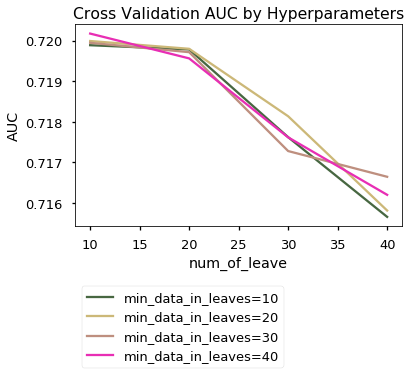

In [375]:
def r():
    return np.random.rand()

#Now plot            
fig = plt.figure(figsize = (6, 5))
ax = fig.add_subplot(111)

for s in min_data_in_leave_values:
    c = (r(),r(),r())
    plt.plot(leavenumber_values, res4mean[s], 
             color= c, label='min_data_in_leaves={}'.format(s))
   # plt.plot(leavenumber_values, np.asarray(res4mean[s])+np.asarray(res4std[s]), 
    #         '-.',color= c, label='min_data_in_leaves={}_mean+std'.format(s))
    #plt.plot(leavenumber_values, np.asarray(res4mean[s])-np.asarray(res4std[s]), 
     #      '--',  color= c, label='min_data_in_leaves={}_mean-std'.format(s))
    

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0, -0.5))
#plt.legend(loc=4, ncol=3, mode="expand")
ax.set_xlabel('num_of_leave')
ax.set_ylabel('AUC')
plt.title('Cross Validation AUC by Hyperparameters')

#n_estimator made to 600

Text(0.5,1,'Cross Validation AUC by Hyperparameters')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


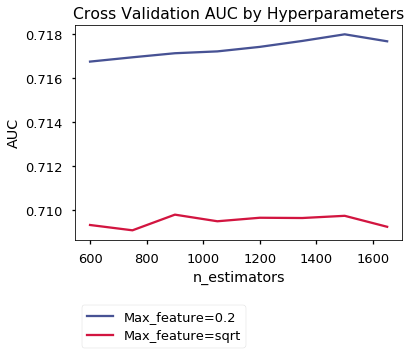

In [216]:

def r():
    return np.random.rand()

#Now plot            
fig = plt.figure(figsize = (6, 5))
ax = fig.add_subplot(111)

for s in max_features_values:
    c = (r(),r(),r())
    plt.plot(n_estimators_values, res3mean[s], 
             color= c, label='Max_feature={}'.format(s))
    #plt.plot(n_estimators_values, np.asarray(res3mean[s])+np.asarray(res3std[s]), 
           # '-.', color= c, label='Max_feature={}_mean+std'.format(s))
    #plt.plot(n_estimators_values, np.asarray(res3mean[s])-np.asarray(res3std[s]), 
            # '--',color= c, label='Max_feature={}_mean-std'.format(s))
    

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0, -0.4))
#plt.legend(loc=4, ncol=3, mode="expand")
ax.set_xlabel('n_estimators')
ax.set_ylabel('AUC')
plt.title('Cross Validation AUC by Hyperparameters')

#n_estimator made to 600

In [225]:
basetrain = pd.read_csv('trainset4.csv')
basetest = pd.read_csv('testset4.csv')

In [227]:
basetrain.columns.values


array(['HistCrit', 'Zipcode', 'Price', 'Rating', 'ReviewCount',
       'WeeklyOpenHr', 'WeeklyOvernightTimes', 'PriceMV',
       'DaysSinceLastInsp', 'InitialInsp', 'RatSighting', 'MouseSighting',
       'CondAttractRodents', 'RodentSigns', 'DaysSinceLastCrit',
       'WeeklyOpenDays', 'NoHistCrit', 'CritRate', 'AveTemp3dayMax',
       'MaxTemp3dayMax', 'AveHum3dayMax', 'AveTemp3dayAve',
       'MaxTemp3dayAve', 'AveHum3dayAve', 'AveTemp3dayRange',
       'MaxTemp3dayRange', 'AveHum3dayRange', 'SubBoroPct',
       'ChildUnder18', 'IncomeDiv', 'MedianIncome', 'Population',
       'PopDensity', 'PovertyRate', 'RacialDiv', 'UnemployRate',
       'MedianRentB', '25NoHighSchool', 'CrimeRate', 'CrimeRateViolent',
       'CrimeRateProperty', 'PriceOverRating', 'RatingOverPrice',
       'RatingCountProd', 'FoodType', 'Month', 'LastAction', 'LastScore',
       'LastScoreMV', 'LastGrade', 'TotalOpenDays', 'LastInspProgram',
       'LastInspCat', 'SubBoro', 'Reviews', 'RodentScore',
       'LastC

In [257]:
basetrax = basetrain[['LastScore','LastGrade','Zipcode','LastAction','Target','Reviews']]
basetray = basetrain['Target']
basetesx = basetest[['LastScore','LastGrade','Zipcode','LastAction','Reviews']]
basetesy = basetest['Target']

In [258]:
basetrax.head()

,LastScore,LastGrade,Zipcode,LastAction,Target,Reviews
0,11.0,LastGradeM,11231.0,LastActionCited,0.0,and This place is a gem for anybody that love...
1,10.0,LastGradeA,11206.0,LastActionCited,0.0,"and Hiiiii, soooo the pizza at this Domino's ..."
2,7.0,LastGradeA,11236.0,LastActionCited,0.0,and The best pizza I've ever tasted and the p...
3,21.0,LastGradeM,10031.0,LastActionCited,0.0,"and Good customer service \nClean place, is t..."
4,23.0,LastGradeM,11206.0,LastActionCited,0.0,"and My oh my, what a discovery! Newtown is s..."


In [ ]:
(basetrax,basetesx) = batchencoder(basetrax,basetesx,col = ['LastGrade','LastAction'], method = ['onehot','onehot'],targ = 'Target')


In [260]:
basetrax.drop('Target',1,inplace = True)
basetesx.drop('Target',1,inplace = True)

In [261]:
basetrax.head()

,LastScore,Zipcode,LastGradeA,LastGradeB,LastGradeC,LastGradeM,LastGradeNot Yet Graded,LastGradeP,LastGradeZ,LastActionCited,LastActionNoVio,LastActionReClosed,LastActionReOpened,LastActionclosed
0,11.0,11231.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10.0,11206.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,7.0,11236.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,21.0,10031.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,23.0,11206.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


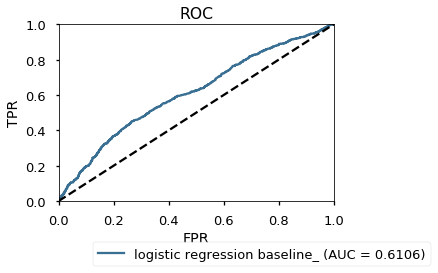

In [266]:
lr = LogisticRegression( ).fit(basetrax,basetray)
y_pred = lr.predict_proba(basetesx)[:,1]
plotAUC(basetesy,y_pred,'logistic regression baseline')

In [282]:
dfall = pd.read_csv('dataall.csv')

Number of Negative:  9128
Number of Positive :  3985
Positive ratio:  0.3038968962098681


/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


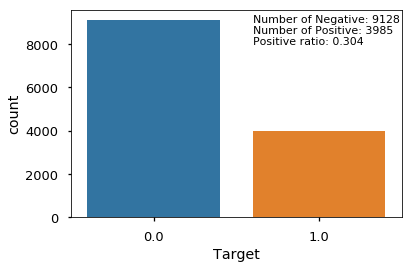

In [305]:
import seaborn as sns # data visualization library 
ax = sns.countplot(dfall.Target,label="Count")       
N, P = dfall.Target.value_counts()
ax.text(0.6, 9000,'Number of Negative: 9128', fontsize=11)
ax.text(0.6, 8500,'Number of Positive: 3985', fontsize=11)
ax.text(0.6,8000,'Positive ratio: 0.304',fontsize = 11)
print('Number of Negative: ',N)
print('Number of Positive : ',P)
print('Positive ratio: ',P/(P+N) )

In [316]:
dataset.shape

(10490, 354)

In [321]:
aucslr = xValSVM(dataset,'Target',10,'lr')

In [332]:
aucsrf = xValSVM(dataset,'Target',10,'rf')

In [363]:
aucslgm = xValSVM(dataset,'Target',10,'lgm')

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613853
[2]	training's binary_logloss: 0.612751
[3]	training's binary_logloss: 0.611694
[4]	training's binary_logloss: 0.610743
[5]	training's binary_logloss: 0.609774
[6]	training's binary_logloss: 0.608829
[7]	training's binary_logloss: 0.607922
[8]	training's binary_logloss: 0.607112
[9]	training's binary_logloss: 0.606234
[10]	training's binary_logloss: 0.605415
[11]	training's binary_logloss: 0.604601
[12]	training's binary_logloss: 0.60382
[13]	training's binary_logloss: 0.603087
[14]	training's binary_logloss: 0.602383
[15]	training's binary_logloss: 0.601686
[16]	training's binary_logloss: 0.601035
[17]	training's binary_logloss: 0.600402
[18]	training's binary_logloss: 0.599927
[19]	training's binary_logloss: 0.599321
[20]	training's binary_logloss: 0.598761
[21]	training's binary_logloss: 0.598142
[22]	training's binary_logloss: 0.597677
[23]	training's binary_logloss: 0.597192
[24]	training's binary_logloss: 0.596695
[25]	training's binary_log

[220]	training's binary_logloss: 0.587219
[221]	training's binary_logloss: 0.58719
[222]	training's binary_logloss: 0.587157
[223]	training's binary_logloss: 0.587132
[224]	training's binary_logloss: 0.587096
[225]	training's binary_logloss: 0.587072
[226]	training's binary_logloss: 0.587076
[227]	training's binary_logloss: 0.587081
[228]	training's binary_logloss: 0.587088
[229]	training's binary_logloss: 0.587093
[230]	training's binary_logloss: 0.587101
[231]	training's binary_logloss: 0.587073
[232]	training's binary_logloss: 0.587046
[233]	training's binary_logloss: 0.587022
[234]	training's binary_logloss: 0.586992
[235]	training's binary_logloss: 0.58696
[236]	training's binary_logloss: 0.586924
[237]	training's binary_logloss: 0.586896
[238]	training's binary_logloss: 0.586866
[239]	training's binary_logloss: 0.586837
[240]	training's binary_logloss: 0.586804
[241]	training's binary_logloss: 0.586791
[242]	training's binary_logloss: 0.586773
[243]	training's binary_logloss: 0.5

[423]	training's binary_logloss: 0.576018
[424]	training's binary_logloss: 0.575973
[425]	training's binary_logloss: 0.575914
[426]	training's binary_logloss: 0.575874
[427]	training's binary_logloss: 0.575838
[428]	training's binary_logloss: 0.575803
[429]	training's binary_logloss: 0.575766
[430]	training's binary_logloss: 0.575739
[431]	training's binary_logloss: 0.575712
[432]	training's binary_logloss: 0.575653
[433]	training's binary_logloss: 0.575591
[434]	training's binary_logloss: 0.575538
[435]	training's binary_logloss: 0.575483
[436]	training's binary_logloss: 0.575371
[437]	training's binary_logloss: 0.575256
[438]	training's binary_logloss: 0.57515
[439]	training's binary_logloss: 0.575046
[440]	training's binary_logloss: 0.574943
[441]	training's binary_logloss: 0.574872
[442]	training's binary_logloss: 0.574807
[443]	training's binary_logloss: 0.574739
[444]	training's binary_logloss: 0.574678
[445]	training's binary_logloss: 0.574609
[446]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.615244
[2]	training's binary_logloss: 0.614252
[3]	training's binary_logloss: 0.613134
[4]	training's binary_logloss: 0.612145
[5]	training's binary_logloss: 0.611241
[6]	training's binary_logloss: 0.610279
[7]	training's binary_logloss: 0.609355
[8]	training's binary_logloss: 0.608513
[9]	training's binary_logloss: 0.607655
[10]	training's binary_logloss: 0.606852
[11]	training's binary_logloss: 0.605992
[12]	training's binary_logloss: 0.605172
[13]	training's binary_logloss: 0.604382
[14]	training's binary_logloss: 0.603624
[15]	training's binary_logloss: 0.602875
[16]	training's binary_logloss: 0.6022
[17]	training's binary_logloss: 0.60155
[18]	training's binary_logloss: 0.601006
[19]	training's binary_logloss: 0.600479
[20]	training's binary_logloss: 0.599904
[21]	training's binary_logloss: 0.59927
[22]	training's binary_logloss: 0.59871
[23]	training's binary_logloss: 0.598169
[24]	training's binary_logloss: 0.597651
[25]	training's binary_logloss

[231]	training's binary_logloss: 0.585881
[232]	training's binary_logloss: 0.585841
[233]	training's binary_logloss: 0.585823
[234]	training's binary_logloss: 0.585773
[235]	training's binary_logloss: 0.585727
[236]	training's binary_logloss: 0.585703
[237]	training's binary_logloss: 0.585666
[238]	training's binary_logloss: 0.585649
[239]	training's binary_logloss: 0.585627
[240]	training's binary_logloss: 0.585606
[241]	training's binary_logloss: 0.585574
[242]	training's binary_logloss: 0.585535
[243]	training's binary_logloss: 0.585489
[244]	training's binary_logloss: 0.58546
[245]	training's binary_logloss: 0.585426
[246]	training's binary_logloss: 0.585373
[247]	training's binary_logloss: 0.58533
[248]	training's binary_logloss: 0.585279
[249]	training's binary_logloss: 0.585239
[250]	training's binary_logloss: 0.585173
[251]	training's binary_logloss: 0.585123
[252]	training's binary_logloss: 0.585089
[253]	training's binary_logloss: 0.585044
[254]	training's binary_logloss: 0.5

[441]	training's binary_logloss: 0.573271
[442]	training's binary_logloss: 0.573176
[443]	training's binary_logloss: 0.573094
[444]	training's binary_logloss: 0.573027
[445]	training's binary_logloss: 0.572961
[446]	training's binary_logloss: 0.57289
[447]	training's binary_logloss: 0.572825
[448]	training's binary_logloss: 0.572753
[449]	training's binary_logloss: 0.572691
[450]	training's binary_logloss: 0.572629
[451]	training's binary_logloss: 0.572549
[452]	training's binary_logloss: 0.572471
[453]	training's binary_logloss: 0.572402
[454]	training's binary_logloss: 0.572327
[455]	training's binary_logloss: 0.572269
[456]	training's binary_logloss: 0.572196
[457]	training's binary_logloss: 0.572122
[458]	training's binary_logloss: 0.572049
[459]	training's binary_logloss: 0.571981
[460]	training's binary_logloss: 0.571911
[461]	training's binary_logloss: 0.571808
[462]	training's binary_logloss: 0.571711
[463]	training's binary_logloss: 0.571619
[464]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613243
[2]	training's binary_logloss: 0.612095
[3]	training's binary_logloss: 0.610991
[4]	training's binary_logloss: 0.609988
[5]	training's binary_logloss: 0.609047
[6]	training's binary_logloss: 0.608066
[7]	training's binary_logloss: 0.607095
[8]	training's binary_logloss: 0.606282
[9]	training's binary_logloss: 0.605407
[10]	training's binary_logloss: 0.604572
[11]	training's binary_logloss: 0.603733
[12]	training's binary_logloss: 0.602929
[13]	training's binary_logloss: 0.602164
[14]	training's binary_logloss: 0.601425
[15]	training's binary_logloss: 0.600727
[16]	training's binary_logloss: 0.599977
[17]	training's binary_logloss: 0.599258
[18]	training's binary_logloss: 0.598705
[19]	training's binary_logloss: 0.598128
[20]	training's binary_logloss: 0.597478
[21]	training's binary_logloss: 0.596858
[22]	training's binary_logloss: 0.596348
[23]	training's binary_logloss: 0.59578
[24]	training's binary_logloss: 0.59522
[25]	training's binary_logl

[226]	training's binary_logloss: 0.583159
[227]	training's binary_logloss: 0.583156
[228]	training's binary_logloss: 0.583144
[229]	training's binary_logloss: 0.583135
[230]	training's binary_logloss: 0.583119
[231]	training's binary_logloss: 0.583101
[232]	training's binary_logloss: 0.583083
[233]	training's binary_logloss: 0.583088
[234]	training's binary_logloss: 0.583072
[235]	training's binary_logloss: 0.583063
[236]	training's binary_logloss: 0.58305
[237]	training's binary_logloss: 0.583052
[238]	training's binary_logloss: 0.583037
[239]	training's binary_logloss: 0.583026
[240]	training's binary_logloss: 0.583008
[241]	training's binary_logloss: 0.582964
[242]	training's binary_logloss: 0.582932
[243]	training's binary_logloss: 0.582895
[244]	training's binary_logloss: 0.582847
[245]	training's binary_logloss: 0.582819
[246]	training's binary_logloss: 0.582766
[247]	training's binary_logloss: 0.582712
[248]	training's binary_logloss: 0.58269
[249]	training's binary_logloss: 0.5

[442]	training's binary_logloss: 0.570396
[443]	training's binary_logloss: 0.570318
[444]	training's binary_logloss: 0.570231
[445]	training's binary_logloss: 0.570132
[446]	training's binary_logloss: 0.570052
[447]	training's binary_logloss: 0.569979
[448]	training's binary_logloss: 0.569903
[449]	training's binary_logloss: 0.569827
[450]	training's binary_logloss: 0.569768
[451]	training's binary_logloss: 0.569709
[452]	training's binary_logloss: 0.569661
[453]	training's binary_logloss: 0.569602
[454]	training's binary_logloss: 0.56953
[455]	training's binary_logloss: 0.569483
[456]	training's binary_logloss: 0.569399
[457]	training's binary_logloss: 0.569329
[458]	training's binary_logloss: 0.569247
[459]	training's binary_logloss: 0.569172
[460]	training's binary_logloss: 0.569107
[461]	training's binary_logloss: 0.569015
[462]	training's binary_logloss: 0.568907
[463]	training's binary_logloss: 0.568814
[464]	training's binary_logloss: 0.568727
[465]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.61551
[2]	training's binary_logloss: 0.61451
[3]	training's binary_logloss: 0.613525
[4]	training's binary_logloss: 0.612447
[5]	training's binary_logloss: 0.611445
[6]	training's binary_logloss: 0.610449
[7]	training's binary_logloss: 0.609609
[8]	training's binary_logloss: 0.608687
[9]	training's binary_logloss: 0.607791
[10]	training's binary_logloss: 0.606927
[11]	training's binary_logloss: 0.606118
[12]	training's binary_logloss: 0.605259
[13]	training's binary_logloss: 0.604435
[14]	training's binary_logloss: 0.603662
[15]	training's binary_logloss: 0.602926
[16]	training's binary_logloss: 0.602111
[17]	training's binary_logloss: 0.601444
[18]	training's binary_logloss: 0.600757
[19]	training's binary_logloss: 0.600099
[20]	training's binary_logloss: 0.599475
[21]	training's binary_logloss: 0.598823
[22]	training's binary_logloss: 0.598274
[23]	training's binary_logloss: 0.597666
[24]	training's binary_logloss: 0.597158
[25]	training's binary_logl

[240]	training's binary_logloss: 0.583207
[241]	training's binary_logloss: 0.583127
[242]	training's binary_logloss: 0.583083
[243]	training's binary_logloss: 0.583042
[244]	training's binary_logloss: 0.582967
[245]	training's binary_logloss: 0.582926
[246]	training's binary_logloss: 0.582856
[247]	training's binary_logloss: 0.582813
[248]	training's binary_logloss: 0.582775
[249]	training's binary_logloss: 0.582723
[250]	training's binary_logloss: 0.582658
[251]	training's binary_logloss: 0.582612
[252]	training's binary_logloss: 0.582566
[253]	training's binary_logloss: 0.582531
[254]	training's binary_logloss: 0.58249
[255]	training's binary_logloss: 0.582454
[256]	training's binary_logloss: 0.58242
[257]	training's binary_logloss: 0.582395
[258]	training's binary_logloss: 0.582357
[259]	training's binary_logloss: 0.582335
[260]	training's binary_logloss: 0.582314
[261]	training's binary_logloss: 0.582268
[262]	training's binary_logloss: 0.582252
[263]	training's binary_logloss: 0.5

[445]	training's binary_logloss: 0.570029
[446]	training's binary_logloss: 0.569974
[447]	training's binary_logloss: 0.569921
[448]	training's binary_logloss: 0.569875
[449]	training's binary_logloss: 0.569828
[450]	training's binary_logloss: 0.569782
[451]	training's binary_logloss: 0.569723
[452]	training's binary_logloss: 0.569666
[453]	training's binary_logloss: 0.569612
[454]	training's binary_logloss: 0.569546
[455]	training's binary_logloss: 0.569495
[456]	training's binary_logloss: 0.569414
[457]	training's binary_logloss: 0.569325
[458]	training's binary_logloss: 0.569241
[459]	training's binary_logloss: 0.569158
[460]	training's binary_logloss: 0.56908
[461]	training's binary_logloss: 0.568995
[462]	training's binary_logloss: 0.568908
[463]	training's binary_logloss: 0.568843
[464]	training's binary_logloss: 0.568763
[465]	training's binary_logloss: 0.568677
[466]	training's binary_logloss: 0.568576
[467]	training's binary_logloss: 0.568466
[468]	training's binary_logloss: 0.

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.61404
[2]	training's binary_logloss: 0.613027
[3]	training's binary_logloss: 0.612032
[4]	training's binary_logloss: 0.610959
[5]	training's binary_logloss: 0.60995
[6]	training's binary_logloss: 0.609008
[7]	training's binary_logloss: 0.608176
[8]	training's binary_logloss: 0.607283
[9]	training's binary_logloss: 0.606415
[10]	training's binary_logloss: 0.605549
[11]	training's binary_logloss: 0.604651
[12]	training's binary_logloss: 0.603798
[13]	training's binary_logloss: 0.602975
[14]	training's binary_logloss: 0.602169
[15]	training's binary_logloss: 0.601386
[16]	training's binary_logloss: 0.600661
[17]	training's binary_logloss: 0.600024
[18]	training's binary_logloss: 0.599326
[19]	training's binary_logloss: 0.598735
[20]	training's binary_logloss: 0.598149
[21]	training's binary_logloss: 0.597552
[22]	training's binary_logloss: 0.59707
[23]	training's binary_logloss: 0.596514
[24]	training's binary_logloss: 0.596071
[25]	training's binary_loglo

[202]	training's binary_logloss: 0.584016
[203]	training's binary_logloss: 0.583983
[204]	training's binary_logloss: 0.583965
[205]	training's binary_logloss: 0.583947
[206]	training's binary_logloss: 0.583945
[207]	training's binary_logloss: 0.583952
[208]	training's binary_logloss: 0.583944
[209]	training's binary_logloss: 0.583929
[210]	training's binary_logloss: 0.583935
[211]	training's binary_logloss: 0.58393
[212]	training's binary_logloss: 0.583913
[213]	training's binary_logloss: 0.583897
[214]	training's binary_logloss: 0.583872
[215]	training's binary_logloss: 0.583852
[216]	training's binary_logloss: 0.583858
[217]	training's binary_logloss: 0.583875
[218]	training's binary_logloss: 0.583889
[219]	training's binary_logloss: 0.583905
[220]	training's binary_logloss: 0.583923
[221]	training's binary_logloss: 0.583857
[222]	training's binary_logloss: 0.58379
[223]	training's binary_logloss: 0.583724
[224]	training's binary_logloss: 0.583663
[225]	training's binary_logloss: 0.5

[422]	training's binary_logloss: 0.571717
[423]	training's binary_logloss: 0.571676
[424]	training's binary_logloss: 0.57164
[425]	training's binary_logloss: 0.571603
[426]	training's binary_logloss: 0.57152
[427]	training's binary_logloss: 0.571453
[428]	training's binary_logloss: 0.571381
[429]	training's binary_logloss: 0.57131
[430]	training's binary_logloss: 0.571232
[431]	training's binary_logloss: 0.571203
[432]	training's binary_logloss: 0.57117
[433]	training's binary_logloss: 0.571135
[434]	training's binary_logloss: 0.571103
[435]	training's binary_logloss: 0.571076
[436]	training's binary_logloss: 0.570987
[437]	training's binary_logloss: 0.570891
[438]	training's binary_logloss: 0.570811
[439]	training's binary_logloss: 0.570746
[440]	training's binary_logloss: 0.570658
[441]	training's binary_logloss: 0.570577
[442]	training's binary_logloss: 0.570491
[443]	training's binary_logloss: 0.570402
[444]	training's binary_logloss: 0.570323
[445]	training's binary_logloss: 0.570

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.613947
[2]	training's binary_logloss: 0.612838
[3]	training's binary_logloss: 0.611823
[4]	training's binary_logloss: 0.610777
[5]	training's binary_logloss: 0.609833
[6]	training's binary_logloss: 0.608897
[7]	training's binary_logloss: 0.607985
[8]	training's binary_logloss: 0.607114
[9]	training's binary_logloss: 0.606356
[10]	training's binary_logloss: 0.605548
[11]	training's binary_logloss: 0.604695
[12]	training's binary_logloss: 0.603878
[13]	training's binary_logloss: 0.603168
[14]	training's binary_logloss: 0.602485
[15]	training's binary_logloss: 0.601758
[16]	training's binary_logloss: 0.601027
[17]	training's binary_logloss: 0.600465
[18]	training's binary_logloss: 0.599789
[19]	training's binary_logloss: 0.599216
[20]	training's binary_logloss: 0.59865
[21]	training's binary_logloss: 0.598086
[22]	training's binary_logloss: 0.597522
[23]	training's binary_logloss: 0.596949
[24]	training's binary_logloss: 0.596432
[25]	training's binary_log

[204]	training's binary_logloss: 0.584679
[205]	training's binary_logloss: 0.584665
[206]	training's binary_logloss: 0.584663
[207]	training's binary_logloss: 0.584664
[208]	training's binary_logloss: 0.584662
[209]	training's binary_logloss: 0.58464
[210]	training's binary_logloss: 0.584638
[211]	training's binary_logloss: 0.584624
[212]	training's binary_logloss: 0.584626
[213]	training's binary_logloss: 0.584619
[214]	training's binary_logloss: 0.5846
[215]	training's binary_logloss: 0.584585
[216]	training's binary_logloss: 0.584562
[217]	training's binary_logloss: 0.584525
[218]	training's binary_logloss: 0.5845
[219]	training's binary_logloss: 0.584466
[220]	training's binary_logloss: 0.584439
[221]	training's binary_logloss: 0.584379
[222]	training's binary_logloss: 0.584304
[223]	training's binary_logloss: 0.58429
[224]	training's binary_logloss: 0.58426
[225]	training's binary_logloss: 0.584188
[226]	training's binary_logloss: 0.584167
[227]	training's binary_logloss: 0.584155

[433]	training's binary_logloss: 0.571774
[434]	training's binary_logloss: 0.57171
[435]	training's binary_logloss: 0.571664
[436]	training's binary_logloss: 0.571582
[437]	training's binary_logloss: 0.571502
[438]	training's binary_logloss: 0.571421
[439]	training's binary_logloss: 0.571345
[440]	training's binary_logloss: 0.571285
[441]	training's binary_logloss: 0.571176
[442]	training's binary_logloss: 0.571064
[443]	training's binary_logloss: 0.570957
[444]	training's binary_logloss: 0.570855
[445]	training's binary_logloss: 0.570745
[446]	training's binary_logloss: 0.570639
[447]	training's binary_logloss: 0.57057
[448]	training's binary_logloss: 0.570504
[449]	training's binary_logloss: 0.570398
[450]	training's binary_logloss: 0.570333
[451]	training's binary_logloss: 0.570242
[452]	training's binary_logloss: 0.570177
[453]	training's binary_logloss: 0.570095
[454]	training's binary_logloss: 0.57001
[455]	training's binary_logloss: 0.569922
[456]	training's binary_logloss: 0.56

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614528
[2]	training's binary_logloss: 0.613409
[3]	training's binary_logloss: 0.612308
[4]	training's binary_logloss: 0.611273
[5]	training's binary_logloss: 0.610434
[6]	training's binary_logloss: 0.609441
[7]	training's binary_logloss: 0.608565
[8]	training's binary_logloss: 0.607725
[9]	training's binary_logloss: 0.606877
[10]	training's binary_logloss: 0.606073
[11]	training's binary_logloss: 0.605356
[12]	training's binary_logloss: 0.604533
[13]	training's binary_logloss: 0.603783
[14]	training's binary_logloss: 0.603021
[15]	training's binary_logloss: 0.602329
[16]	training's binary_logloss: 0.601659
[17]	training's binary_logloss: 0.600997
[18]	training's binary_logloss: 0.600364
[19]	training's binary_logloss: 0.599757
[20]	training's binary_logloss: 0.599096
[21]	training's binary_logloss: 0.59857
[22]	training's binary_logloss: 0.598047
[23]	training's binary_logloss: 0.597517
[24]	training's binary_logloss: 0.597056
[25]	training's binary_log

[212]	training's binary_logloss: 0.584536
[213]	training's binary_logloss: 0.584512
[214]	training's binary_logloss: 0.5845
[215]	training's binary_logloss: 0.584481
[216]	training's binary_logloss: 0.584463
[217]	training's binary_logloss: 0.58445
[218]	training's binary_logloss: 0.584437
[219]	training's binary_logloss: 0.584425
[220]	training's binary_logloss: 0.584412
[221]	training's binary_logloss: 0.584385
[222]	training's binary_logloss: 0.584347
[223]	training's binary_logloss: 0.584323
[224]	training's binary_logloss: 0.584297
[225]	training's binary_logloss: 0.584285
[226]	training's binary_logloss: 0.584287
[227]	training's binary_logloss: 0.584264
[228]	training's binary_logloss: 0.584245
[229]	training's binary_logloss: 0.584211
[230]	training's binary_logloss: 0.584199
[231]	training's binary_logloss: 0.584215
[232]	training's binary_logloss: 0.584199
[233]	training's binary_logloss: 0.584191
[234]	training's binary_logloss: 0.584176
[235]	training's binary_logloss: 0.58

[439]	training's binary_logloss: 0.571211
[440]	training's binary_logloss: 0.571136
[441]	training's binary_logloss: 0.571047
[442]	training's binary_logloss: 0.570971
[443]	training's binary_logloss: 0.570885
[444]	training's binary_logloss: 0.570803
[445]	training's binary_logloss: 0.570717
[446]	training's binary_logloss: 0.570634
[447]	training's binary_logloss: 0.570577
[448]	training's binary_logloss: 0.570508
[449]	training's binary_logloss: 0.570431
[450]	training's binary_logloss: 0.57038
[451]	training's binary_logloss: 0.570296
[452]	training's binary_logloss: 0.5702
[453]	training's binary_logloss: 0.570119
[454]	training's binary_logloss: 0.570021
[455]	training's binary_logloss: 0.569936
[456]	training's binary_logloss: 0.569874
[457]	training's binary_logloss: 0.569802
[458]	training's binary_logloss: 0.569731
[459]	training's binary_logloss: 0.569662
[460]	training's binary_logloss: 0.569606
[461]	training's binary_logloss: 0.569538
[462]	training's binary_logloss: 0.56

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.617535
[2]	training's binary_logloss: 0.616437
[3]	training's binary_logloss: 0.615347
[4]	training's binary_logloss: 0.614336
[5]	training's binary_logloss: 0.613364
[6]	training's binary_logloss: 0.612388
[7]	training's binary_logloss: 0.611511
[8]	training's binary_logloss: 0.610701
[9]	training's binary_logloss: 0.609829
[10]	training's binary_logloss: 0.60912
[11]	training's binary_logloss: 0.608313
[12]	training's binary_logloss: 0.6075
[13]	training's binary_logloss: 0.606803
[14]	training's binary_logloss: 0.606027
[15]	training's binary_logloss: 0.605334
[16]	training's binary_logloss: 0.604621
[17]	training's binary_logloss: 0.60402
[18]	training's binary_logloss: 0.603372
[19]	training's binary_logloss: 0.602839
[20]	training's binary_logloss: 0.602233
[21]	training's binary_logloss: 0.60176
[22]	training's binary_logloss: 0.601314
[23]	training's binary_logloss: 0.600781
[24]	training's binary_logloss: 0.600269
[25]	training's binary_logloss

[201]	training's binary_logloss: 0.587251
[202]	training's binary_logloss: 0.587232
[203]	training's binary_logloss: 0.587234
[204]	training's binary_logloss: 0.587213
[205]	training's binary_logloss: 0.587199
[206]	training's binary_logloss: 0.587184
[207]	training's binary_logloss: 0.587172
[208]	training's binary_logloss: 0.587166
[209]	training's binary_logloss: 0.587177
[210]	training's binary_logloss: 0.587164
[211]	training's binary_logloss: 0.587152
[212]	training's binary_logloss: 0.587132
[213]	training's binary_logloss: 0.587103
[214]	training's binary_logloss: 0.587087
[215]	training's binary_logloss: 0.587059
[216]	training's binary_logloss: 0.587044
[217]	training's binary_logloss: 0.587019
[218]	training's binary_logloss: 0.586984
[219]	training's binary_logloss: 0.586976
[220]	training's binary_logloss: 0.586948
[221]	training's binary_logloss: 0.586914
[222]	training's binary_logloss: 0.586889
[223]	training's binary_logloss: 0.586857
[224]	training's binary_logloss: 0

[436]	training's binary_logloss: 0.573095
[437]	training's binary_logloss: 0.573015
[438]	training's binary_logloss: 0.572934
[439]	training's binary_logloss: 0.572846
[440]	training's binary_logloss: 0.572767
[441]	training's binary_logloss: 0.572674
[442]	training's binary_logloss: 0.572583
[443]	training's binary_logloss: 0.5725
[444]	training's binary_logloss: 0.572418
[445]	training's binary_logloss: 0.572345
[446]	training's binary_logloss: 0.572251
[447]	training's binary_logloss: 0.572158
[448]	training's binary_logloss: 0.572077
[449]	training's binary_logloss: 0.571996
[450]	training's binary_logloss: 0.571914
[451]	training's binary_logloss: 0.571821
[452]	training's binary_logloss: 0.571737
[453]	training's binary_logloss: 0.571653
[454]	training's binary_logloss: 0.571565
[455]	training's binary_logloss: 0.571482
[456]	training's binary_logloss: 0.571398
[457]	training's binary_logloss: 0.571318
[458]	training's binary_logloss: 0.57123
[459]	training's binary_logloss: 0.57

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614074
[2]	training's binary_logloss: 0.61295
[3]	training's binary_logloss: 0.611871
[4]	training's binary_logloss: 0.610883
[5]	training's binary_logloss: 0.609941
[6]	training's binary_logloss: 0.608953
[7]	training's binary_logloss: 0.607992
[8]	training's binary_logloss: 0.607195
[9]	training's binary_logloss: 0.606304
[10]	training's binary_logloss: 0.60546
[11]	training's binary_logloss: 0.604648
[12]	training's binary_logloss: 0.603871
[13]	training's binary_logloss: 0.603125
[14]	training's binary_logloss: 0.602411
[15]	training's binary_logloss: 0.601747
[16]	training's binary_logloss: 0.601031
[17]	training's binary_logloss: 0.600348
[18]	training's binary_logloss: 0.59977
[19]	training's binary_logloss: 0.599253
[20]	training's binary_logloss: 0.598644
[21]	training's binary_logloss: 0.598069
[22]	training's binary_logloss: 0.597519
[23]	training's binary_logloss: 0.597002
[24]	training's binary_logloss: 0.596514
[25]	training's binary_loglo

[200]	training's binary_logloss: 0.585143
[201]	training's binary_logloss: 0.585146
[202]	training's binary_logloss: 0.585143
[203]	training's binary_logloss: 0.585161
[204]	training's binary_logloss: 0.585163
[205]	training's binary_logloss: 0.585167
[206]	training's binary_logloss: 0.585148
[207]	training's binary_logloss: 0.585108
[208]	training's binary_logloss: 0.585081
[209]	training's binary_logloss: 0.585054
[210]	training's binary_logloss: 0.585029
[211]	training's binary_logloss: 0.585012
[212]	training's binary_logloss: 0.584998
[213]	training's binary_logloss: 0.584975
[214]	training's binary_logloss: 0.584965
[215]	training's binary_logloss: 0.584956
[216]	training's binary_logloss: 0.584956
[217]	training's binary_logloss: 0.584938
[218]	training's binary_logloss: 0.584918
[219]	training's binary_logloss: 0.584913
[220]	training's binary_logloss: 0.584896
[221]	training's binary_logloss: 0.584882
[222]	training's binary_logloss: 0.584872
[223]	training's binary_logloss: 0

[424]	training's binary_logloss: 0.572806
[425]	training's binary_logloss: 0.572763
[426]	training's binary_logloss: 0.572707
[427]	training's binary_logloss: 0.572665
[428]	training's binary_logloss: 0.57263
[429]	training's binary_logloss: 0.572579
[430]	training's binary_logloss: 0.572524
[431]	training's binary_logloss: 0.572439
[432]	training's binary_logloss: 0.572362
[433]	training's binary_logloss: 0.572283
[434]	training's binary_logloss: 0.572211
[435]	training's binary_logloss: 0.572141
[436]	training's binary_logloss: 0.572061
[437]	training's binary_logloss: 0.571985
[438]	training's binary_logloss: 0.571919
[439]	training's binary_logloss: 0.57185
[440]	training's binary_logloss: 0.571777
[441]	training's binary_logloss: 0.571688
[442]	training's binary_logloss: 0.571599
[443]	training's binary_logloss: 0.571512
[444]	training's binary_logloss: 0.571435
[445]	training's binary_logloss: 0.571338
[446]	training's binary_logloss: 0.571257
[447]	training's binary_logloss: 0.5

/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's binary_logloss: 0.614476
[2]	training's binary_logloss: 0.613349
[3]	training's binary_logloss: 0.612322
[4]	training's binary_logloss: 0.611286
[5]	training's binary_logloss: 0.61042
[6]	training's binary_logloss: 0.609489
[7]	training's binary_logloss: 0.608633
[8]	training's binary_logloss: 0.607839
[9]	training's binary_logloss: 0.60703
[10]	training's binary_logloss: 0.606246
[11]	training's binary_logloss: 0.605402
[12]	training's binary_logloss: 0.6046
[13]	training's binary_logloss: 0.603894
[14]	training's binary_logloss: 0.603152
[15]	training's binary_logloss: 0.602448
[16]	training's binary_logloss: 0.601669
[17]	training's binary_logloss: 0.600998
[18]	training's binary_logloss: 0.600282
[19]	training's binary_logloss: 0.599729
[20]	training's binary_logloss: 0.599108
[21]	training's binary_logloss: 0.598632
[22]	training's binary_logloss: 0.598177
[23]	training's binary_logloss: 0.597596
[24]	training's binary_logloss: 0.597042
[25]	training's binary_loglos

[218]	training's binary_logloss: 0.585675
[219]	training's binary_logloss: 0.585677
[220]	training's binary_logloss: 0.585664
[221]	training's binary_logloss: 0.585627
[222]	training's binary_logloss: 0.585592
[223]	training's binary_logloss: 0.585552
[224]	training's binary_logloss: 0.585504
[225]	training's binary_logloss: 0.585461
[226]	training's binary_logloss: 0.585449
[227]	training's binary_logloss: 0.585441
[228]	training's binary_logloss: 0.585439
[229]	training's binary_logloss: 0.585431
[230]	training's binary_logloss: 0.585414
[231]	training's binary_logloss: 0.585427
[232]	training's binary_logloss: 0.58542
[233]	training's binary_logloss: 0.585405
[234]	training's binary_logloss: 0.585412
[235]	training's binary_logloss: 0.585422
[236]	training's binary_logloss: 0.585403
[237]	training's binary_logloss: 0.585402
[238]	training's binary_logloss: 0.585394
[239]	training's binary_logloss: 0.585397
[240]	training's binary_logloss: 0.585392
[241]	training's binary_logloss: 0.

[434]	training's binary_logloss: 0.572533
[435]	training's binary_logloss: 0.572454
[436]	training's binary_logloss: 0.572375
[437]	training's binary_logloss: 0.572294
[438]	training's binary_logloss: 0.57223
[439]	training's binary_logloss: 0.572163
[440]	training's binary_logloss: 0.572092
[441]	training's binary_logloss: 0.572
[442]	training's binary_logloss: 0.571915
[443]	training's binary_logloss: 0.571834
[444]	training's binary_logloss: 0.571761
[445]	training's binary_logloss: 0.571688
[446]	training's binary_logloss: 0.571601
[447]	training's binary_logloss: 0.571523
[448]	training's binary_logloss: 0.57143
[449]	training's binary_logloss: 0.57135
[450]	training's binary_logloss: 0.571266
[451]	training's binary_logloss: 0.571202
[452]	training's binary_logloss: 0.571127
[453]	training's binary_logloss: 0.571061
[454]	training's binary_logloss: 0.570998
[455]	training's binary_logloss: 0.570935
[456]	training's binary_logloss: 0.570875
[457]	training's binary_logloss: 0.57081

In [325]:
len(aucslr)

10

In [335]:
np.var(aucslr)

0.00020021294265729168

0.00026850282596599167


Text(0.5,1,'Fold AUC for LightGBM ')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


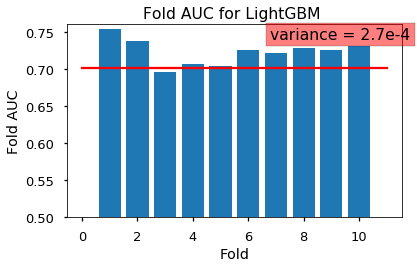

In [376]:
lgmmean = np.mean(aucslgm)
print(np.var(aucslgm))
plt.bar(np.arange(1,11),aucslgm)
plt.plot(np.ones(12)*lrmean,'r')
plt.xlabel('Fold')
plt.ylabel('Fold AUC')
plt.ylim([0.5,0.76])
plt.text(6.8, 0.74, 'variance = 2.7e-4', bbox=dict(facecolor='r', alpha=0.5))
plt.title('Fold AUC for LightGBM ')

0.00018471454437789134


Text(0.5,1,'Fold AUC for Random Forest ')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


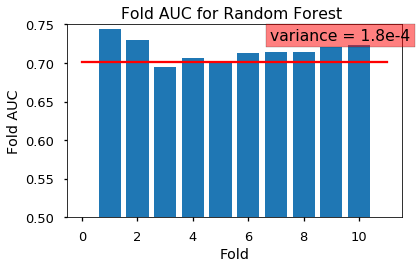

In [366]:
rfmean = np.mean(aucsrf)
print(np.var(aucsrf))
plt.bar(np.arange(1,11),aucsrf)
plt.plot(np.ones(12)*lrmean,'r')
plt.xlabel('Fold')
plt.ylabel('Fold AUC')
plt.ylim([0.5,0.75])
plt.text(6.8, 0.73, 'variance = 1.8e-4', bbox=dict(facecolor='r', alpha=0.5))
plt.title('Fold AUC for Random Forest ')

Text(0.5,1,'Fold AUC for Logistic Regression ')

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


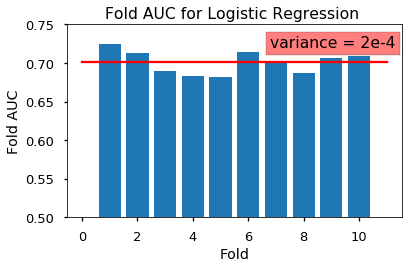

In [362]:
lrmean = np.mean(aucslr)

plt.bar(np.arange(1,11),aucslr)
plt.plot(np.ones(12)*lrmean,'r')
plt.xlabel('Fold')
plt.ylabel('Fold AUC')
plt.ylim([0.5,0.75])
plt.text(6.8, 0.72, 'variance = 2e-4', bbox=dict(facecolor='r', alpha=0.5))
plt.title('Fold AUC for Logistic Regression ')

In [320]:
def xValSVM(dataset, lab, k , model):
    '''
    Perform k-fold cross validation on SVM across a range of C,
    returns mean and var of auc avg.
    '''
    n_samp = dataset.shape[0]
    cv = KFold(n = n_samp, n_folds = k)
    aucs = [] #record auc for each fold return a list

    for train_index, test_index in cv:
        tr_k = dataset.iloc[train_index]
        va_k = dataset.iloc[test_index]
        
        test_p = getprediction(model,tr_k.drop(lab,1),tr_k[lab],va_k.drop(lab,1))[0]
        met = metrics.roc_auc_score(va_k[lab], test_p)
        
        aucs.append(met)
    
    return aucs

In [372]:
def getprediction(model,trainx,trainy,testx):
    if model == 'lgm':
        scalar = MinMaxScaler()
        scalar.fit(trainx)
        trainx = scalar.transform(trainx)
        testx = scalar.transform(testx)
        
        #created dataset for lightgbm
        lgb_train = lgb.Dataset(trainx, trainy)
        
    # specify your configurations as a dict
        params = {
            'colsample_bytree':0.4,
            
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'binary_logloss',
            'is_unbalance': 'true',         # base rate: 0.30
            'num_leaves': 12,
            "num_threads": 4,
            'learning_rate': 0.01,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'n_estimators': 500,
            'verbose': 0
        }

    # train
        
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=10,
                        valid_sets=lgb_train,  # eval training data
                        categorical_feature = 'auto')
# predict
        y_pred = gbm.predict(testx, num_iteration=gbm.best_iteration)
        trained = gbm
    
    elif model == 'lr':
        LRC = LogisticRegression(C= 0.1, penalty = 'l1').fit(trainx,trainy)
        y_pred = LRC.predict_proba(testx)[:,1]
        trained = LRC
        
    elif model == 'rf':
        RF = RandomForestClassifier(criterion='entropy', bootstrap=True, max_depth=30, n_estimators=1200, max_features=0.2, min_samples_split=20, min_samples_leaf=10, n_jobs = -1, oob_score=True).fit(trainx,trainy)
        y_pred = RF.predict_proba(testx)[:,1]
        trained = RF
        
    return y_pred,trained
        